In [1]:
import pandas
import sys
print(sys.version)
import psi4
import ase
import py3Dmol
import openbabel
import pybel
import matplotlib
import numpy as np
import rdkit
import sklearn

modules = [psi4,ase,rdkit,np,sklearn,pandas]
for m in modules:
    print(f"{m} version: {m.__version__}")

3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]
<module 'psi4' from '/home/keceli/.conda/envs/jhub_chembox/lib/python3.6/site-packages/psi4/__init__.py'> version: 1.3.2
<module 'ase' from '/home/keceli/.conda/envs/jhub_chembox/lib//python3.6/site-packages/ase/__init__.py'> version: 3.19.0
<module 'rdkit' from '/home/keceli/.conda/envs/jhub_chembox/lib//python3.6/site-packages/rdkit/__init__.py'> version: 2019.03.4
<module 'numpy' from '/home/keceli/.conda/envs/jhub_chembox/lib/python3.6/site-packages/numpy/__init__.py'> version: 1.17.0
<module 'sklearn' from '/home/keceli/.conda/envs/jhub_chembox/lib//python3.6/site-packages/sklearn/__init__.py'> version: 0.21.3
<module 'pandas' from '/home/keceli/.conda/envs/jhub_chembox/lib/python3.6/site-packages/pandas/__init__.py'> version: 0.25.1


Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [2]:
modulelist = []
for m in sys.modules:
    modulelist.append(m.split('.')[0])
moduleset = set(modulelist)
print(f'Chembox has {len(moduleset)} modules')

Chembox has 258 modules


In [5]:
# To install a new package or upgrade
#!source activate jhub_chembox; pip install --upgrade ase
!source activate jhub_chembox; pip install torchvision torchani

In [2]:
#PSI4 ASE test
from ase.calculators.psi4 import Psi4
from ase.build import molecule
import numpy as np

atoms = molecule('H2O')

calc = Psi4(atoms = atoms,
        method = 'b3lyp',
        memory = '500MB', # this is the default, be aware!
        basis = '6-311g_d_p_')

atoms.set_calculator(calc)
print(atoms.get_potential_energy())
print(atoms.get_forces())

-2080.239102768128
[[-6.05066742e-14  5.62955547e-10 -3.59067939e-01]
 [ 6.47557609e-14 -2.87779832e-01  1.78910936e-01]
 [ 2.98602933e-14  2.87779831e-01  1.78910936e-01]]


In [7]:
import ase
import ase.optimize
import torch
import torchani
import math
model = torchani.models.ANI1x().double()
d = 0.9575
t = math.pi / 180 * 104.51
molecule = ase.Atoms('H2O', positions=[
    (d, 0, 0),
    (d * math.cos(t), d * math.sin(t), 0),
    (0, 0, 0),
], calculator=model.ase())
opt = ase.optimize.BFGS(molecule)
opt.run(fmax=1e-6)
species = model.species_to_tensor(molecule.get_chemical_symbols()).unsqueeze(0)
coordinates = torch.from_numpy(molecule.get_positions()).unsqueeze(0).requires_grad_(True)
element_masses = torch.tensor([
    1.008,  # H
    12.011,  # C
    14.007,  # N
    15.999,  # O
], dtype=torch.double)
masses = element_masses[species]
energies = model((species, coordinates)).energies
hessian = torchani.utils.hessian(coordinates, energies=energies)
freq, modes = torchani.utils.vibrational_analysis(masses, hessian)
freq = freq[-3:]
modes = modes[-3:]

print('Frequencies (cm^-1):', freq)
print('Modes:', modes)

      Step     Time          Energy         fmax
BFGS:    0 19:19:48    -2078.633392        0.6576
BFGS:    1 19:19:48    -2078.637244        0.1905
BFGS:    2 19:19:48    -2078.637801        0.0292
BFGS:    3 19:19:48    -2078.637827        0.0183
BFGS:    4 19:19:48    -2078.637849        0.0014
BFGS:    5 19:19:48    -2078.637849        0.0001
BFGS:    6 19:19:48    -2078.637849        0.0000
BFGS:    7 19:19:48    -2078.637849        0.0000
Frequencies (cm^-1): tensor([1913.2332, 3882.4718, 3911.2534], dtype=torch.float64)
Modes: tensor([[[ 1.4982e-02,  6.7708e-01,  4.2438e-17],
         [ 6.5173e-01,  1.8415e-01, -1.2995e-17],
         [-4.2006e-02, -5.4261e-02, -9.2618e-19]],

        [[-6.8921e-01,  5.3705e-02, -6.0187e-17],
         [ 2.2467e-01, -6.5377e-01, -6.5097e-18],
         [ 2.9268e-02,  3.7806e-02,  2.4074e-18]],

        [[-6.7842e-01, -6.3755e-03,  2.2713e-17],
         [-1.6381e-01,  6.5838e-01, -4.5657e-17],
         [ 5.3064e-02, -4.1079e-02,  9.0403e-19]]], dtyp

In [28]:
#!rm -f obtools.py;wget https://raw.githubusercontent.com/keceli/QTC/master/qtc/obtools.py
import obtools as ob
ob.get_xyz('C')
def get_ase_atoms_input(x):
    """
    Return atomic symbols and coordinates that can be used as inputs
    for ASE Atoms constructor.
    >>> symbols, coords = get_ase_atoms_input('C')
    >>> 'C' in symbols
    >>> True
    >>> print(len(symbols))
    >>> 5
    >>> print(len(coords[0]))
    >>> 3
    >>> print(len(coords))
    >>> 5
    """
    xyz = ob.get_xyz(x)
    lines = xyz.splitlines()                                                        
    n = int(lines[0])
    symbols = ['X']*n
    coords = [[0.,0.,0.]]*n                                                             
    for i,line in enumerate(lines[2:2+n]):
        items = line.split()
        symbols[i] = items[0]
        coords[i] = [float(c) for c in items[1:4]]
    return symbols, coords

print(get_ase_atoms('C'))
molecule=ase.Atoms(*get_ase_atoms('C'))
molecule.get_positions()

(['C', 'H', 'H', 'H', 'H'], [[1.0917, 0.03984, 0.00186], [2.1839, 0.03984, 0.00186], [0.72764, 0.95576, 0.47244], [0.72763, -0.82565, 0.55978], [0.72763, -0.01058, -1.02664]])


array([[ 0.98503, -0.09686, -0.01985],
       [ 2.07723, -0.09686, -0.01985],
       [ 0.62096, -0.87299, -0.69659],
       [ 0.62096,  0.87728, -0.35362],
       [ 0.62096, -0.29487,  0.99067]])

In [31]:
coords = [[0.,0.,0.]]*3                                                            
len(coords[0])

3

In [6]:
# Test py3Dmol
import py3Dmol
p = py3Dmol.view(query='pdb:1ycr')
p.setStyle({'cartoon': {'color':'spectrum'}})
p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
from ase import io
gdb9 = io.read('/lus/theta-fs0/projects/datascience/keceli/chem_datasets/134kmolecules/C7O2H10nsd/test.xyz',format='xyz')

In [8]:
gdb9.get_positions()

array([[-1.83961301,  0.52929557,  3.18206792],
       [-2.14653613, -0.16446749,  1.84251139],
       [-3.58660018,  0.13265872,  1.38668197],
       [-1.94526687, -1.57364172,  1.95806872],
       [-1.16446158,  0.26895851,  0.79100457],
       [-0.24711624, -0.39756228,  0.04289842],
       [ 0.38520951,  0.58702844, -0.78836776],
       [-0.19714008,  1.77247527, -0.48015995],
       [-1.14642858,  1.59774107,  0.48275977],
       [-2.56554969,  0.2227697 ,  3.94442331],
       [-0.83769961,  0.25523887,  3.52159237],
       [-1.89109763,  1.61663672,  3.08094481],
       [-4.30117115, -0.17126025,  2.16077728],
       [-3.72488956,  1.20033228,  1.19658441],
       [-3.80748337, -0.4187666 ,  0.46941271],
       [-2.56198471, -1.89787641,  2.62209366],
       [-0.05151729, -1.45582614,  0.08373829],
       [ 1.16669159,  0.4258948 , -1.51446231],
       [-0.06722314,  2.78381413, -0.82781742]])

In [3]:
def get_psi4_geometry(xyz):
    """
    Return geometry for a given xyz
    """
    lines = xyz.splitlines()
    natom = int(lines[0])
    geo = ''
    for line in lines[2:2+natom]:
        items = line.split()
        geoline = " ".join(items[0:4])
        geo += f"{geoline}\n"
    return geo

def get_ase_atoms(xyz):
    """
    Return geometry for a given xyz
    """
    import ase
    atoms = ase.Atoms(pbc=False)
    lines = xyz.splitlines()
    natom = int(lines[0])
    geo = []
    symbols = []
    for line in lines[2:2+natom]:
        items = line.split()
        symbols.append(items[0].decode("utf-8"))
        geo.append([float(x) for x in items[1:4]])
    print(symbols)
    print(geo)
    return ase.Atoms(symbols=symbols,positions=geo,pbc=False)


In [46]:
atoms = get_ase_atoms(df.iloc[0].xyz)

import ase.io
from dscribe.descriptors import MBTR
from dscribe.descriptors import CoulombMatrix
from dscribe.descriptors import SineMatrix

from dscribe.utils import stats
mystats = stats.system_stats([atoms])
natoms = mystats['n_atoms_max']
cdesc = CoulombMatrix(natoms,permutation='eigenspectrum')
cdesc.create(atoms)

array([[ 1.97580198e+02,  7.47005146e+01,  3.94450256e+01,
         3.23899128e+01,  2.55734875e+01,  2.42119869e+01,
         1.03633162e+01,  6.29845272e+00,  3.55152438e+00,
        -9.51289557e-01, -8.38804101e-01, -8.15705958e-01,
        -5.07107730e-01, -4.86270030e-01, -1.91852676e-01,
        -1.32158003e-01, -1.04502246e-01, -3.98786131e-02,
        -6.72450300e-03]])

In [62]:
filename = '/lus/theta-fs0/projects/datascience/keceli/chem_datasets/134kmolecules/C7O2H10nsd/1.xyz'
def parse_134k_data(filename):
    """
    Return a dict of parsed values for 134k molecules data
    Line       Content
----       -------
1          Number of atoms na
2          Properties 1-17 (see below)
3,...,na+2 Element type, coordinate (x,y,z) (Angstrom), and Mulliken partial charge (e) of atom
na+3       Frequencies (3na-5 or 3na-6)
na+4       SMILES from GDB9 and for relaxed geometry
na+5       InChI for GDB9 and for relaxed geometry

The properties stored in the second line of each file:

I.  Property  Unit         Description
--  --------  -----------  --------------
 1  tag       -            "gdb9"; string constant to ease extraction via grep
 2  index     -            Consecutive, 1-based integer identifier of molecule
 3  A         GHz          Rotational constant A
 4  B         GHz          Rotational constant B
 5  C         GHz          Rotational constant C
 6  mu        Debye        Dipole moment
 7  alpha     Bohr^3       Isotropic polarizability
 8  homo      Hartree      Energy of Highest occupied molecular orbital (HOMO)
 9  lumo      Hartree      Energy of Lowest occupied molecular orbital (LUMO)
10  gap       Hartree      Gap, difference between LUMO and HOMO
11  r2        Bohr^2       Electronic spatial extent
12  zpve      Hartree      Zero point vibrational energy
13  U0        Hartree      Internal energy at 0 K
14  U         Hartree      Internal energy at 298.15 K
15  H         Hartree      Enthalpy at 298.15 K
16  G         Hartree      Free energy at 298.15 K
17  Cv        cal/(mol K)  Heat capacity at 298.15 K

I. = Property index (properties are given in this order)
For the 6095 isomers, properties 12-16 were calculated at the G4MP2 level of theory.
All other calculations were done at the DFT/B3LYP/6-31G(2df,p) level of theory.

Notes
-----

Out of the 133885 molecules, geometries of the 11 molecules with indices 
21725, 87037, 59827, 117523, 128113, 129053, 129152, 129158, 130535, 6620, 59818 
were difficult to converge.
Low threshold convergence was possible for 21725, 59827, 128113, 129053, 129152, 130535.
Molecules 6620 and 59818 converged to very low-lying saddlepoints, with lowest frequency < 10i cm^-1.
    """
    from collections import OrderedDict
    from dscribe.descriptors import CoulombMatrix
    from dscribe.utils import stats

    d = {}
    try:
        with open(filename, "rb") as f:
            lines = f.readlines()
    except:
        lines = filename.readlines()
    d['natom'] = int(lines[0])
    properties = lines[1].split()
    d['tag'] = properties[0]
    d['index'] = int(properties[1])
    keys = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv'] 
    for k,v in zip(keys,properties[2:]):
        d[k] = float(v)
   # d['xyz'] = f"{lines[0]}\n{lines[1]}\n{lines[2:d['natom']+2]}"
    d['xyz'] = b"".join(lines[:d['natom']+2])
    charges = [0]*d['natom']
    for i,line in enumerate(lines[2:d['natom']+2]):
        charges[i] = float(line.split()[-1])
    d['Mulliken_charges'] = charges
    d['Frequencies'] = [float(v) for v in lines[d['natom']+2].split()]
    d['SMILES'], d['SMILES_relaxed'] = lines[d['natom']+3].split()
    d['InChI'], d['InChI_relaxed'] = lines[d['natom']+4].split()
    geo = get_psi4_geometry(d['xyz'].decode("utf-8"))
    mol = psi4.geometry(geo)
    d['nre'] = mol.nuclear_repulsion_energy()
    atoms = get_ase_atoms(d['xyz'])
    natoms = 19 #mystats['n_atoms_max']
    cdesc = CoulombMatrix(natoms,permutation='eigenspectrum')
    coulomb = cdesc.create(atoms)
    for i,c in enumerate(coulomb[0]):
        d[f'coulomb_{i+1}'] = c
    return d
pprint.pprint(parse_134k_data(filename))

['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-1.8396130083, 0.5292955664, 3.1820679223], [-2.146536134, -0.1644674918, 1.8425113894], [-3.586600184, 0.1326587167, 1.3866819689], [-1.9452668697, -1.5736417154, 1.9580687171], [-1.1644615826, 0.2689585055, 0.7910045705], [-0.2471162449, -0.3975622829, 0.0428984233], [0.3852095134, 0.5870284364, -0.7883677644], [-0.1971400753, 1.7724752692, -0.4801599455], [-1.1464285779, 1.5977410694, 0.4827597736], [-2.5655496903, 0.2227697011, 3.9444233135], [-0.8376996067, 0.2552388729, 3.5215923743], [-1.8910976269, 1.6166367216, 3.0809448095], [-4.3011711473, -0.171260251, 2.1607772826], [-3.7248895561, 1.2003322827, 1.1965844054], [-3.807483374, -0.4187666041, 0.469412708], [-2.5619847116, -1.8978764082, 2.6220936647], [-0.0515172885, -1.45582614, 0.0837382916], [1.1666915942, 0.4258947957, -1.5144623143], [-0.0672231395, 2.7838141258, -0.8278174205]]
{'A': 3.1580357,
 'B': 1.2436329,
 'C': 1.1060

In [64]:
import bz2
import tarfile
mytar = tarfile.open('/lus/theta-fs0/projects/datascience/keceli/chem_datasets/134kmolecules/C7O2H10nsd/dsC7O2H10nsd.xyz.tar.bz2','r:bz2')
import pandas as pd
dlist = []
for m in mytar.getnames():
    try:
        d = parse_134k_data(mytar.extractfile(m))
        dlist.append(d)
    except Exception as e:
        print(f'Parsing error for {m}')
        print(e)
df = pd.DataFrame(dlist)

['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-1.8396130083, 0.5292955664, 3.1820679223], [-2.146536134, -0.1644674918, 1.8425113894], [-3.586600184, 0.1326587167, 1.3866819689], [-1.9452668697, -1.5736417154, 1.9580687171], [-1.1644615826, 0.2689585055, 0.7910045705], [-0.2471162449, -0.3975622829, 0.0428984233], [0.3852095134, 0.5870284364, -0.7883677644], [-0.1971400753, 1.7724752692, -0.4801599455], [-1.1464285779, 1.5977410694, 0.4827597736], [-2.5655496903, 0.2227697011, 3.9444233135], [-0.8376996067, 0.2552388729, 3.5215923743], [-1.8910976269, 1.6166367216, 3.0809448095], [-4.3011711473, -0.171260251, 2.1607772826], [-3.7248895561, 1.2003322827, 1.1965844054], [-3.807483374, -0.4187666041, 0.469412708], [-2.5619847116, -1.8978764082, 2.6220936647], [-0.0515172885, -1.45582614, 0.0837382916], [1.1666915942, 0.4258947957, -1.5144623143], [-0.0672231395, 2.7838141258, -0.8278174205]]
['C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[4.2205366757, 0.3190896445, 2.9163527176], [2.8174856755, 0.3126508036, 2.4242988222], [2.2313851797, -0.040344758, 1.2458166408], [2.8809855419, -0.5648542897, 0.0018514327], [0.8137841429, 0.1938820151, 1.420325462], [-0.2689552584, -0.0735472847, 0.4242158067], [-0.3512934826, -1.4511265293, 0.0551243215], [0.6671145685, 0.6621147817, 2.6866147689], [1.8680743335, 0.7473345364, 3.3126955422], [4.3305780638, -0.2899014919, 3.8209185467], [4.8905155612, -0.0811939285, 2.1526044703], [4.5566231905, 1.3330468766, 3.1630081283], [2.337162366, -1.4358711964, -0.3751068756], [2.8787082857, 0.1837076518, -0.8004472521], [3.9209591959, -0.8531665296, 0.1769126405], [-1.2314810037, 0.29178368, 0.8138136097], [-0.0795933076, 0.4577513069, -0.5151472718], [-0.4020470914, -1.9570747373, 0.8731227448], [-0.1896740172, 0.9751324989, 3.2619905647]]
['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'H', 'H'

['C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.1510293115, 0.1757470715, -0.021627087], [1.0456415601, 0.0773785103, 0.0263695697], [2.4937614793, -0.0436118739, 0.1218722467], [2.9697801839, -0.160604814, 1.5734995865], [4.3789320683, -0.2717208198, 1.5492451951], [4.9610089804, -0.3492548329, 2.8205352846], [6.4868301576, -0.5176640763, 2.7781475115], [6.4191356789, -1.7134187434, 3.5828958439], [4.9776991887, -1.726728335, 3.5308083183], [-1.2076081473, 0.2630517295, -0.0800013416], [2.8405553589, -0.9240931288, -0.4317559292], [2.9812572108, 0.8246871558, -0.3368564287], [2.6592973393, 0.7260605381, 2.1478188338], [2.5105870411, -1.0403784946, 2.0488719721], [4.6095859574, 0.4723084697, 3.4601012026], [6.8578678763, -0.7134866488, 1.7643807524], [7.0911738813, 0.264855725, 3.2493983195], [4.5903223193, -2.5402795999, 2.9027174836], [4.5316745773, -1.7866867725, 4.5299989662]]
['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'H', 'H

['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.6105191244, 0.2713058509, -3.6271686425], [2.3357619765, 0.8131963108, -2.3969318917], [2.0228595654, 0.0147135773, -1.1123455443], [1.4721372635, 0.9433625951, -0.0112320297], [0.94334153, 0.1626747628, 1.0584633668], [0.1327064499, 0.3510216163, -0.1120704961], [0.6143847096, -0.7130177776, -1.1190415769], [-0.0733267357, -0.8540356586, -2.4738676048], [0.2173396435, 0.1889579775, -3.3850759041], [1.7411104947, 0.9426358421, -4.4810167648], [2.0034169809, -0.719797167, -3.9129339598], [3.4159041026, 0.8373876474, -2.5759436361], [2.0147780399, 1.8539418412, -2.2666473069], [2.8639791648, -0.6153414844, -0.8125763644], [1.791006873, 1.9551952874, 0.2171681882], [-0.8537350786, 0.7798187414, 0.0266609064], [0.639124565, -1.6947992361, -0.6361928007], [0.2193854604, -1.8198207401, -2.9207000734], [-1.1620882198, -0.8648364465, -2.3526855654]]
['C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'C', 

['C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.2549665992, 1.1978624486, 0.1306948437], [0.1830625114, 0.7961904323, -0.8391729168], [0.4002560906, -0.659831188, -1.2687125811], [1.8090455084, -0.2621440597, -1.8098969451], [2.0396228127, -0.4489212047, -3.3145807792], [3.4507160286, -0.5541821656, -3.4149370332], [3.8234160095, -1.2875583596, -2.2759443038], [2.9264021854, -0.9401208122, -1.2369970906], [1.5825163287, 1.1765478057, -1.3366062799], [1.1543073489, 2.1890747698, 0.560981766], [1.6987881214, 0.462112636, 0.7960522562], [-0.7411664919, 1.3488738107, -0.9467112405], [0.4015403328, -1.4042340508, -0.4671442671], [-0.2676705698, -0.9967325774, -2.0670752344], [1.5474721355, -1.3691788445, -3.6701029485], [1.7075612306, 0.3944665967, -3.9228801117], [3.7610908134, -2.3741534034, -2.4672820409], [4.8481889169, -1.0143042968, -2.0022976442], [1.9149376678, 2.0625189328, -1.8656106486]]
['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 

['C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-1.8445195298, 0.2358747921, -0.9582549652], [-0.9416521232, 1.0708157851, 0.0119029112], [0.1918913166, 0.3323123741, 0.7100686232], [1.0126973306, -0.370929099, -0.2068340427], [1.6678315423, 0.4836967515, -1.1225371924], [0.7109517235, 1.3303473854, -1.946027251], [-0.1759324281, 0.544182628, -2.7811043873], [-1.3476566384, 1.0935912861, -2.1447843428], [-0.4825407394, 1.9534706096, -1.1878484893], [-1.587571145, -0.8210320177, -1.0511267118], [-2.9134253689, 0.3387715415, -0.7538043248], [-1.5211266488, 1.6317637149, 0.7499943753], [0.8004922039, 1.0457746196, 1.2941907115], [-0.1992921977, -0.4209129009, 1.40186821], [2.3658863572, 1.1586434263, -0.5940354254], [2.2526815726, -0.1640889949, -1.7829651613], [1.2851831911, 2.043653297, -2.5533561015], [-2.0726496394, 1.4753138887, -2.8677038397], [-0.526660849, 3.0373933325, -1.0960424059]]
['C', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 'C', 

['C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.4375958881, 1.3231253961, -0.7604439721], [-0.3454462503, 0.3440044559, -1.9336371087], [0.7657643362, -0.6771346585, -1.8403207897], [1.2633677148, -1.0114719875, -0.5360304728], [2.1669108694, -0.421239646, -1.4794093306], [2.8483999956, 0.8847903123, -1.1343951783], [2.0870155661, 2.1681938926, -0.8847272194], [1.2964057253, 2.7309737119, -1.939665093], [0.6433598603, 2.3792239378, -0.7107174491], [-1.4027582972, 1.839010183, -0.8253129494], [-0.4363446419, 0.7718791971, 0.1859334084], [-1.2939521548, -0.2024916286, -1.9934724578], [-0.2388521727, 0.896813558, -2.873072554], [0.602200196, -1.5516584535, -2.4748829844], [2.88869372, -1.1438634586, -1.8701677362], [3.4614299418, 0.6960915444, -0.2418613245], [3.5670359872, 1.0944156178, -1.9391712784], [2.7284806115, 2.9126004893, -0.4049054169], [0.3707821007, 3.2472495864, -0.1053821333]]
['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O',

['C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-1.0426184899, -0.92476839, 0.4578409986], [-0.2953011949, -0.2020841086, 1.5791541979], [-0.9563449472, 0.8698522632, 2.4309288569], [-1.5313910077, 1.9218666233, 1.6638510289], [-0.6014685079, 2.5172342486, 0.7684860147], [-0.3278774802, 1.5494585367, -0.3806361135], [1.0891936354, 1.3965084732, -0.9821396656], [1.1648422977, 0.0088435787, -0.5596700518], [-0.0651492956, 0.1466479754, 0.1410434243], [-0.7441842524, -1.9515090636, 0.2740707117], [-2.0969201734, -0.7155416891, 0.2984578394], [0.473489357, -0.7854690575, 2.0766189642], [-1.7774746318, 0.4651189875, 3.0321716398], [-0.2048151713, 1.2884839028, 3.1217973009], [-1.0558447421, 3.4524498024, 0.4302191406], [0.3349670624, 2.7619042044, 1.2974372077], [-1.1177146282, 1.5992288674, -1.1341012911], [1.1742147992, 1.4917399394, -2.0689661754], [1.863894681, 2.0068034257, -0.5001906683]]
['C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', '

['C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.6081814041, 1.3538421502, -0.318475401], [1.4205710134, 0.0984348244, -0.0255434153], [-0.0703618393, 0.0725113299, 0.0229389374], [-0.7982253702, -0.1231407154, 1.2403868329], [-1.7657981138, -0.9692705511, 0.5665396192], [-3.130488069, -0.31260144, 0.3905696674], [-2.8866459604, 0.6416655686, -0.7911937495], [-1.9457002121, -0.0318850927, -1.6324594379], [-1.0625539041, -0.748583886, -0.7990592799], [0.605718052, 2.1300204353, 0.4394511535], [0.538293467, 1.7094620615, -1.3411613802], [1.9230179412, -0.4044151532, -0.8460505814], [1.9435818291, 0.0574630612, 0.9238985624], [-1.7915432381, -1.9718877476, 1.0003238744], [-3.8699968058, -1.075421107, 0.1246807174], [-3.4613433014, 0.1982281601, 1.297604141], [-3.776933141, 0.8467296099, -1.3898248926], [-2.4725537165, 1.5952508872, -0.4370981709], [-0.6620715349, -1.5931378353, -1.3612844768]]
['C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C',

['C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.8420964991, 2.8735407996, -3.6351468111], [1.7807080511, 3.5782756263, -2.8288092211], [1.8468304256, 2.1399249749, -2.8413185929], [1.5418834442, 1.4269490497, -1.5788099135], [2.2377568006, 0.3484162187, -1.2100090945], [1.9256085621, -0.419451766, 0.0445859082], [0.563646283, 0.0091003749, 0.5961037443], [0.4441580536, 1.4208183804, 0.6037056144], [0.4332613902, 1.9634632856, -0.6999410617], [-0.1924120179, 2.9186794697, -3.2995307687], [0.9816298813, 2.9660936613, -4.711786677], [2.7092928979, 1.747044968, -3.3811998276], [3.0635709813, 0.000717401, -1.8273692342], [1.9248420708, -1.4989640808, -0.1546334047], [2.7099111114, -0.2466374471, 0.7944872468], [-0.2418834413, -0.4380162262, -0.0104354221], [0.4281541659, -0.317494963, 1.6307166111], [-0.5469751914, 1.7831493899, -1.1793540892], [0.5455942724, 3.0465398133, -0.5910093168]]
['C', 'O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 

['C', 'O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.3473576337, 1.4407202328, -0.0548158883], [-0.346792253, 0.005680863, -0.2043996349], [1.0798056795, -0.0607340109, 0.0008325468], [1.19317433, 1.4744978591, -0.0682217078], [1.838864177, 2.1290151847, 1.032044477], [2.7751993642, 2.9940470105, 0.3581368964], [1.9220783684, 3.6165846406, -0.7736024262], [1.9242815961, 2.1258498545, -1.2442302225], [3.3945048943, 2.0675070227, -0.7161939667], [-0.8662142947, 1.9456910755, -0.8791622987], [-0.775572926, 1.7613916098, 0.9033421302], [1.3423876432, -0.4668173944, 0.985927815], [1.5875925977, -0.6358513087, -0.7834805923], [3.3442620391, 3.5621296593, 1.0914888387], [0.9720441766, 4.0747576725, -0.4882079191], [2.4874649239, 4.2696812621, -1.4402126572], [1.6351966625, 1.8139110353, -2.2468812446], [3.7923837638, 1.1075998504, -0.3782467643], [4.099999551, 2.5732018013, -1.3773417313]]
['C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'H', 'H', 

['C', 'O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.0515826342, 2.4782089322, -2.3960711053], [0.0809848437, 3.7576265502, -1.728796407], [0.8870350966, 3.1848551046, -0.6702655278], [0.0961062705, 2.8924017837, 0.6186510103], [-0.3028358448, 1.4976173565, 0.0444271589], [0.3634145105, 0.2648684106, 0.6680169521], [1.6765657983, 0.1889886429, 0.1106288168], [1.5751904293, 0.610547974, -1.2463179164], [0.5960090886, 1.7603147147, -1.2151790675], [-1.0949046378, 2.2308021907, -2.6277727282], [0.5364590289, 2.4514025044, -3.3247811732], [1.8759514889, 3.6488117894, -0.6042328908], [0.7343253351, 2.8236180786, 1.5053691382], [-0.7225766277, 3.5878750612, 0.8149168461], [-1.3694458853, 1.3488792723, -0.1353126404], [0.4709916579, 0.3160109578, 1.7553589866], [-0.2093466118, -0.6427498839, 0.4173537362], [2.578806965, 0.8821425374, -1.5862365137], [1.1992804983, -0.2052970972, -1.8892737149]]
['C', 'O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H', 

['C', 'O', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-1.0110436615, -0.5820204496, -0.7747731736], [-1.4832046094, -0.8593569784, 0.5494793181], [-0.7794725734, -0.065436313, 1.4681587815], [0.3992140824, -0.7145044025, 1.9666770193], [1.516942077, -0.0540972728, 1.3500573189], [1.4870803781, -0.3389785856, -0.1625034128], [0.1672224451, 0.3784004526, -0.6006533191], [-0.2218700822, 1.1513011783, 0.6979404871], [1.1045007662, 1.4236289027, 1.4133571156], [-0.7279397461, -1.5205142552, -1.2643707439], [-1.8251347515, -0.1255256637, -1.3541240667], [-1.4475854724, 0.1214662836, 2.3119408082], [2.4231575396, -0.3571490899, 1.8740257905], [2.3641108867, 0.0906814212, -0.6568911172], [1.4699789557, -1.4117517039, -0.3704753204], [0.3073485764, 1.0191016142, -1.4727963705], [-0.9278064368, 1.9711825002, 0.5696259844], [1.7713752707, 2.0929401479, 0.8627174159], [0.9844965254, 1.7838153539, 2.4380833647]]
['C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'O

['O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-1.9622838211, -1.471356993, -0.8295038526], [-1.348984623, -0.4238950246, -0.8561165494], [-0.8797020939, 0.2495842817, 0.4345037242], [0.629708735, 0.3302528413, 0.5373421505], [1.3033621932, 1.4475675654, 1.2105199897], [1.2792771288, 1.3593547067, -0.2158096027], [-1.0196022795, 0.2724637613, -2.1307308186], [-0.7978146899, -0.5986830989, -3.3605879656], [-2.0541083193, 0.1898575281, -3.2484748854], [-1.2873418033, 1.2669438857, 0.4759739172], [-1.2795602992, -0.327132966, 1.2735943045], [1.1478854729, -0.6291066259, 0.5058303386], [0.705207558, 2.2503799518, 1.6397793018], [2.2783888041, 1.2966237837, 1.6708338966], [-0.4354830618, 1.1798203129, -2.0455213362], [-0.0325605142, -0.2756950457, -4.0566576143], [-0.8632499417, -1.6673558276, -3.192273193], [-2.1812431939, 1.0719243054, -3.8653684796], [-2.9622030314, -0.3496235123, -3.0048688556]]
['O', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.1229544958, 0.0221143252, 0.2591006796], [-0.061865938, -0.0156380977, 0.0277039959], [-0.8542181215, -1.3105961135, -0.0660758045], [-1.969288948, -1.2393442583, -1.1271882283], [-2.7207469908, 0.0671200588, -1.0006178994], [-4.0881715119, 0.2531638454, -1.5669905621], [-3.8970483104, 0.2077241561, -0.0607716501], [-1.8747786808, 1.1809793219, -1.141137384], [-0.888705105, 1.2634852046, -0.1216681763], [-0.1612703014, -2.1392134219, -0.2301689935], [-1.3125563533, -1.4578023822, 0.9229405685], [-1.5299632991, -1.2946030046, -2.1304587249], [-2.6502818425, -2.0898212064, -1.0227598502], [-4.3004711434, 1.2189840456, -2.0104281855], [-4.5616549467, -0.5901500295, -2.0577758135], [-3.9953062657, 1.1449610416, 0.4753626365], [-4.2433282381, -0.66643049, 0.4805933423], [-0.224300155, 2.0916315208, -0.3742878342], [-1.3555505144, 1.4763057343, 0.856658994]]
['O', 'C', 'C', 'C', 'C', 'C', 'O',

['O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.0553205792, 0.1615334823, 1.6265504831], [-0.416607097, 0.1256914869, 0.5140105742], [-0.724414185, 1.40004872, -0.274133478], [-1.7294307523, 1.206114915, -1.4278866978], [-2.7815795473, 0.14879546, -1.0544051149], [-2.0829530735, -1.2031930006, -0.9590826247], [-2.6608598035, -2.129468239, -0.0145921992], [-1.411338215, -2.2679477319, 0.7016123237], [-0.747966963, -1.1883028594, -0.1728060266], [-1.094214132, 2.1278253187, 0.4558821953], [0.228863645, 1.8017746448, -0.6406261491], [-2.2031390259, 2.162053115, -1.6694176129], [-1.206602501, 0.8870302737, -2.338957171], [-3.2249619633, 0.3860828463, -0.0794606378], [-3.5971019058, 0.1185451572, -1.7830943746], [-1.9994753804, -1.6614105755, -1.9544215022], [-1.5027315363, -2.0176244112, 1.7632236229], [-0.9918777638, -3.2756128805, 0.5991727118], [0.1310726209, -1.5105450418, -0.7396185922]]
['O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.0761110651, 0.0246967388, 0.9986585291], [0.3420213002, -0.0122433134, -0.1761386171], [-0.2885663852, 0.876829654, -1.2171297199], [-0.9047237792, 2.2147302824, -0.7218896724], [-2.287097312, 1.8143964788, -1.3062713406], [-1.7154888891, 0.4376591083, -1.7497808686], [-1.4768724683, 0.2243286535, -3.2473502487], [-0.2137940284, 1.0567692956, -3.5160186838], [0.5750336653, 0.9385215401, -2.3333227006], [1.0686342331, -0.7413316696, -0.5980276555], [-0.8830401098, 2.2861264373, 0.3669818207], [-0.431044049, 3.0978941902, -1.1553819375], [-3.0923472297, 1.7509411775, -0.5721143519], [-2.631252914, 2.4367616086, -2.1372571485], [-2.1660117092, -0.4253207939, -1.2582535543], [-1.2799386675, -0.8324624709, -3.4527184284], [-2.3251856881, 0.5398446594, -3.861626012], [0.3872878139, 0.696402605, -4.35443369], [-0.468301158, 2.1106270183, -3.7051171098]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 

['O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.3989046615, -0.0715341841, -0.8607597003], [0.5061599013, 0.1441037452, -0.0828176894], [0.3598497158, 1.4015883768, 0.746453461], [-0.958784865, 2.1267307261, 0.3603760993], [-1.5235686869, 2.8960460395, 1.4143227377], [-1.2896186714, 2.3623821141, 2.7116395747], [0.2260185934, 2.4091765475, 3.0353422551], [0.3098594552, 1.064904371, 2.2573339452], [-1.1651809706, 0.8138493039, 2.6999140996], [-0.3001027602, -0.6096020889, 0.085617516], [1.2312636776, 2.0309009186, 0.5417322785], [-0.7920262225, 2.8119662238, -0.4744456076], [-1.6924891481, 1.3779177548, 0.0225457965], [-2.0044520439, 2.8483327488, 3.3774935046], [0.785231779, 3.2660610153, 2.6520365377], [0.4246183532, 2.2750377028, 4.1018648871], [1.0782060763, 0.3417446904, 2.539964669], [-1.8365020268, 0.2380595356, 2.0590451371], [-1.2107385177, 0.4148480386, 3.7156620785]]
['O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.5483022188, 0.1704669087, 0.4428118406], [0.3597163045, 0.2554443319, 0.2686839335], [-0.2941267142, 0.7794726242, -0.9904816417], [-1.1738541942, 2.0017239062, -0.7101105753], [-2.0170956373, 2.5740324323, -1.8837316928], [-3.1958594222, 2.7895056478, -0.8673840344], [-2.4834463189, 1.8298724705, 0.1127249102], [-4.5575551527, 2.4082939743, -1.3768131373], [-5.1240339637, 1.3772837715, -1.1119216308], [-0.3560711782, -0.050703478, 1.0666754728], [0.4907886468, 1.0141651159, -1.7164081902], [-0.9222207229, -0.0223024445, -1.4050656052], [-0.5600005965, 2.7989233905, -0.2770063326], [-1.6334291549, 3.4527715238, -2.4052070789], [-2.2602510981, 1.8022120869, -2.6207246704], [-3.216702432, 3.8290266357, -0.5232046425], [-2.4632198982, 2.1129559608, 1.1666708607], [-2.9081499444, 0.8257813204, 0.024091868], [-5.0166085017, 3.1475013912, -2.0735539938]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C'

['O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[3.6681643775, 0.0694128861, -0.3962498735], [2.6544373809, 0.0945930811, 0.2491308627], [1.3202299557, 0.5682265078, -0.2990233448], [0.3616041522, 0.4532958213, 0.7272332187], [-0.9147160812, 0.8740758903, 0.3507286435], [-2.0133341202, 0.2268976649, 1.1275558355], [-3.3582911304, 0.8654329695, 0.7667599355], [-3.1180812222, 0.491622731, -0.7367111947], [-1.7797074557, -0.1444925815, -0.3478634465], [2.6092745128, -0.2301706627, 1.3120217887], [1.4293403863, 1.6099673028, -0.6433034646], [1.0585129553, -0.0371123977, -1.181052207], [-0.9697881428, 1.9316362107, 0.0717641253], [-1.781298328, -0.3407002622, 2.0202403704], [-4.2094127927, 0.3302922406, 1.1921758701], [-3.4638247433, 1.9299690133, 1.0013221119], [-3.848142261, -0.2317866369, -1.1050351283], [-3.0641123517, 1.3230463883, -1.4480025718], [-1.3452629716, -1.0465888267, -0.7617907414]]
['O', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'C'

['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.3638691249, -0.1371906522, 0.0206541621], [-0.0908122027, -0.1130850707, 0.072226446], [-1.2961540444, -0.0627645094, 0.0857240599], [-2.7494993597, -0.0487530647, 0.1584546446], [-3.3948414111, -0.8191826238, -0.8820840682], [-3.8672930354, -1.8275225381, 0.0544723631], [-3.2327346688, -3.185395569, -0.1716031968], [-3.3496098771, -0.9882642027, 1.2576217953], [-2.4836114373, -1.5669444756, 2.1841503509], [1.7971554908, 0.1011909264, 0.9979769171], [1.7356893054, -1.1230063526, -0.278202799], [1.7431290385, 0.5957674683, -0.6994182385], [-3.1228727325, 0.9821526552, 0.1741562092], [-4.9609030798, -1.9025823405, 0.0039855915], [-3.581698413, -3.8976661349, 0.5827922792], [-3.5053844698, -3.5643668927, -1.1610727514], [-2.1422977507, -3.1298321309, -0.1158687485], [-4.1563683616, -0.5125843682, 1.8198438861], [-1.6015776857, -1.5899252938, 1.7887396474]]
['C', 'C', 'C', 'C', 'O', 'C', 'C'

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.0996280263, -1.4056514779, 0.9689036344], [0.6783827305, -2.8164670311, 0.5880252803], [-0.2716676883, -3.3442488817, 1.130016667], [1.4637608492, -3.5705454293, -0.4414898226], [1.8699825542, -2.8558073764, -1.7322752333], [2.9133314388, -3.2170194951, -0.7287152486], [1.0396038802, -5.0086330347, -0.5750635709], [1.7770420706, -6.1089153366, 0.0528719992], [1.8920898112, -5.8509585617, -1.3530657583], [1.9521371808, -1.4579667586, 1.6562381432], [1.4085849088, -0.7988700859, 0.1141075277], [0.2701907093, -0.9228431579, 1.4868230212], [1.810710054, -3.4567316523, -2.6325595896], [1.5878229727, -1.8172729812, -1.857767815], [3.5574046216, -4.054977001, -0.9677609517], [3.3731794013, -2.4301783742, -0.1429898534], [-0.0237664183, -5.15042537, -0.7566853868], [2.6692485895, -5.8905372648, 0.6373978456], [1.2574551375, -7.0282047199, 0.3156793315]]
['C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', '

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-4.696652919, -1.5922804572, 0.4689063559], [-3.3951686191, -1.6923511694, -0.3011967534], [-3.249821895, -2.4633271683, -1.2224102858], [-2.2779263879, -0.740648952, 0.1198188408], [-2.3397507343, 0.5824795043, -0.7092130561], [-0.9305471065, 1.1747571517, -0.5803742534], [-0.0022726872, -0.0351162669, -0.4013532707], [1.1998439608, -0.0080168761, -0.431874575], [-0.8680033959, -1.2724077142, -0.1627303835], [-4.5407504693, -1.9419361556, 1.4967020465], [-5.0287325775, -0.5504386592, 0.5381987605], [-5.4658159936, -2.2006312788, -0.0078598796], [-2.3926186714, -0.4902294355, 1.1812050897], [-2.5493017451, 0.3324452578, -1.7551924502], [-3.1276882953, 1.256110882, -0.3642000451], [-0.6127051132, 1.7924680446, -1.4235501459], [-0.8382219398, 1.7917384645, 0.3230430015], [-0.8931130524, -1.86425294, -1.0871434602], [-0.4460777482, -1.9070109316, 0.619533414]]
['C', 'C', 'O', 'C', 'O', 'C', '

[[2.6943657624, -0.6857761193, 2.6070419795], [3.1321938538, -0.9768295748, 1.1826656121], [4.6341435626, -1.2804152377, 0.9620472699], [4.1412876594, -2.657264377, 0.477662747], [2.7663586712, -2.3183074246, 0.7645353227], [2.5814032445, 0.0475852483, 0.1581837738], [3.1521085216, 1.3365514446, 0.377679807], [1.1195839515, 0.0899570985, 0.1411751509], [-0.0799504984, 0.1683475533, 0.1611013773], [3.1060418053, -1.435219413, 3.287864522], [3.0542181914, 0.2990079262, 2.9235550771], [1.603844988, -0.706653414, 2.6865987949], [5.1329628523, -0.6519283818, 0.2233321161], [5.2287754476, -1.297550475, 1.876654091], [4.2954489533, -2.8701254522, -0.5872912297], [4.4761231337, -3.5227990682, 1.0608085003], [2.9357434611, -0.2684745816, -0.830243354], [2.5975498153, 1.7963772195, 1.0164485574], [-1.1407611666, 0.223370149, 0.1609023447]]
['C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[2.5216727452, 0.4403698959, -2.4088981839], [3.0815176831, 0

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[4.730708469, 0.1520064378, 1.7970255397], [3.2131294273, 0.2127541782, 1.6225627452], [2.5738121963, -0.8334551204, 2.3441504649], [2.7804605071, 0.0181448243, 0.154141684], [1.3276105889, -0.0112627323, 0.0009817753], [0.1384834418, 0.0212230495, -0.1719128058], [3.3163194991, 1.1334000238, -0.7814082032], [3.3015863566, 0.8117190048, -2.2603331499], [3.7111891144, 2.1869173669, -0.3452259438], [4.9858173738, 0.2352650827, 2.8594082186], [5.1205519218, -0.8047976505, 1.433380079], [5.2246400196, 0.9713368807, 1.271263758], [2.8461068354, 1.1949945846, 1.949335458], [2.780502416, -0.7156750321, 3.2764395296], [3.1842980903, -0.9438101453, -0.1930912704], [-0.9158185164, 0.0255365789, -0.2989710115], [4.0583248147, 0.0459567584, -2.4705378453], [2.3329630821, 0.3989303666, -2.5552980033], [3.5277014822, 1.7081239834, -2.8385812293]]
['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.0708560698, 1.226383185, -0.9877990974], [-0.4215481379, 0.0007582676, -0.2273116842], [0.1256799031, -1.1365103566, -0.8921106611], [0.0205416526, 0.0195460174, 1.2315263466], [-0.6976153101, 0.9419996944, 2.2836406036], [-0.0964010122, -0.016178746, 3.3685362971], [-0.5942375008, -1.0041089763, 2.2593639188], [-1.8351884357, -0.093682226, 2.2227852977], [-3.0242257328, -0.1578824395, 2.1885756916], [-0.3395792197, 2.1438070412, -0.5564862611], [1.1637432564, 1.2812190705, -0.9541033211], [-0.2352471278, 1.1652919544, -2.0351253531], [-1.5222965436, -0.0283521265, -0.2739650891], [-0.2344107576, -1.9267603932, -0.4770068598], [1.1121971702, 0.0685619402, 1.3022333518], [-0.7422779017, 2.0285893357, 2.3044051113], [0.9897128797, 0.040705378, 3.466848787], [-0.5940466718, -0.0555309285, 4.3388181186], [-0.5207260399, -2.0902208517, 2.2575303828]]
['C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', '

['O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.7637092072, -1.0154438453, -1.6024225697], [-0.2274690575, -1.032632441, -0.5847840032], [0.2900442028, -1.7951838489, 0.6296347744], [-0.0527044174, -1.597787256, 1.7666095233], [-1.4630725722, -1.7440469029, -1.1625815666], [-1.9973629885, -1.0685673357, -2.4560249232], [-3.5402072953, -1.1940597696, -2.3792719883], [-3.7893893243, -1.4358951356, -0.9100466674], [-2.6720303948, -1.733335838, -0.2500190203], [1.4839509546, -0.4428112872, -1.3201003164], [-0.5125536312, -0.0194432845, -0.2664424334], [1.0306306273, -2.5851178195, 0.3611651593], [-1.1598257297, -2.781441431, -1.3748528186], [-1.7133916253, -0.0112472995, -2.4473243957], [-1.5718889523, -1.505697696, -3.3605942784], [-4.0518367386, -0.3028848512, -2.7599898469], [-3.9116428595, -2.0380023991, -2.9777225324], [-4.7804582566, -1.4043230979, -0.470499585], [-2.6042438787, -1.9717836012, 0.8047672686]]
['C', 'C', 'C', 'O', 'C'

['C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[3.1965464873, -2.5075350266, -0.2592449757], [1.7991756177, -2.1897369223, -0.8270125114], [1.081193525, -1.1568516654, 0.0526877328], [-0.1093197382, -0.7608631711, -0.5906848346], [-0.891255917, 0.1278814131, 0.1623102326], [-2.1516598823, 0.4355006152, -0.6283756925], [-2.9869591284, 1.2214815876, -0.2693568597], [1.0000503774, -3.4044783499, -0.9770157786], [0.3669069109, -4.4210090975, -1.0777914595], [3.1202484232, -2.9380103021, 0.7437781928], [3.7123702491, -3.2295472008, -0.8958841446], [3.8042647153, -1.5991310949, -0.2024796689], [1.9189273736, -1.729971728, -1.8169764187], [0.8623417386, -1.592278991, 1.0409401518], [1.741797289, -0.2877746169, 0.2081130016], [-1.1839118307, -0.303141529, 1.1354245721], [-0.3641215521, 1.0732017388, 0.375482147], [-2.2333943592, -0.1417744086, -1.5752641872], [-0.2018507092, -5.3118363006, -1.1799402292]]
['C', 'C', 'O', 'C', 'C', 'C', 'O', 'C'

[[0.2198657395, -0.4815156702, 0.2475535947], [1.4741157967, 0.3606575618, 0.4364851224], [2.4267729712, -0.3750207744, 1.1806405729], [1.346764487, 1.8968919308, 0.7797846956], [2.8206744232, 2.042852046, 0.2678830623], [2.1277827078, 1.097064106, -0.775726088], [0.9569522755, 2.0876069812, -0.6917645841], [-0.2428412775, 2.3943016097, -1.4549899489], [0.8689221723, 3.3168288065, -1.3712398111], [-0.2287949557, -0.7150551384, 1.2217410237], [-0.5422859801, 0.0170939855, -0.3528297492], [0.4793731442, -1.4299123797, -0.2326982331], [2.003199962, -0.6684775389, 1.9938085225], [0.8913626583, 2.3518733877, 1.660268626], [3.0973650271, 3.030592325, -0.1006336684], [3.5904952061, 1.5888211519, 0.8854838793], [2.5648634371, 0.641676078, -1.6642166277], [-0.39937755, 1.9492210553, -2.437121679], [-1.1504910845, 2.7196666762, -0.9473898098]]
['C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.001656752, -0.2771369789, 0.1001662981], [1.331128550

['C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-1.9763325436, -1.0126852956, -2.166900973], [-2.0630391889, -0.7433402358, -0.6629385735], [-3.15293967, -1.5841986142, -0.0048161946], [-0.7888457865, -1.1307896592, -0.0725174636], [0.0172169263, -0.0521316888, 0.1701194896], [1.1821395824, -0.1669735886, 0.4210678139], [-0.8024960717, 1.1954329407, 0.0779662838], [-1.9912224721, 1.2142322364, 1.0247784672], [-2.1684726114, 0.7586763099, -0.3884463894], [-1.7461785393, -2.0654407869, -2.3498855987], [-2.926798637, -0.7744693289, -2.6552366633], [-1.1910692196, -0.4034718769, -2.623908732], [-3.1868470722, -1.4134794968, 1.0735291068], [-4.130341195, -1.3287549812, -0.4254568771], [-2.9702665432, -2.6482078279, -0.1785806215], [-0.3078632275, 2.1150448141, -0.2017513763], [-2.0171257255, 0.491011292, 1.8327217596], [-2.3768744641, 2.1935636115, 1.2838135604], [-2.7518784811, 1.3574362761, -1.077507298]]
['C', 'C', 'O', 'C', 'C', 'O', 'C'

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.0030541529, -0.2205819738, 0.042778743], [1.512428805, -0.0124794806, 0.0655730008], [2.0303065355, -0.141535328, 1.3782617242], [1.97751294, 1.3335326808, -0.5784965359], [2.745716952, 0.5657695812, -1.6589634769], [3.7446437231, -0.3374175546, -1.0451184944], [2.2880451611, -0.7844448937, -1.0309851976], [1.9001250238, -2.0096002686, -1.7307086078], [1.0034061775, -2.7539231786, -1.4010290371], [-0.4688519717, 0.4947480936, 0.723405224], [-0.403480188, -0.0730035329, -0.9618778378], [-0.2552512758, -1.2379319525, 0.3481232148], [1.7481968856, -0.9958293052, 1.7244786117], [1.1412060629, 1.9197628984, -0.9633736972], [2.5915233882, 1.9594052666, 0.0740171546], [2.7545067777, 0.804500613, -2.715309476], [4.3833111071, -0.8888499456, -1.7284002974], [4.1947926466, -0.0961530177, -0.0870500971], [2.5213411864, -2.2280657716, -2.6323992981]]
['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'H'

['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.0293683606, -0.0399427598, 0.0379805878], [1.4152445242, 0.3114297248, 0.4068444845], [1.9824731728, -0.7962720597, 1.2570409526], [2.3265469153, -0.6967828773, 2.4087518935], [1.6421839231, 1.8053013581, 0.778522831], [3.1536686174, 1.9325986558, 1.0450318738], [3.6439592034, 1.1377705594, -0.2103380293], [2.2543870712, 0.8373044014, -0.8086371255], [1.5744233688, 2.1161134831, -0.6549705937], [-0.6594752461, -0.0907264039, 0.9321163759], [-0.4334812489, 0.7202511623, -0.6326032827], [-0.0832161816, -1.0127963641, -0.4635819812], [2.0394120078, -1.7796063823, 0.7304708537], [0.9383497961, 2.3705070515, 1.3887006811], [3.4586695713, 2.9801583968, 1.0180960866], [3.4570651762, 1.4894953476, 1.9931152014], [4.2427453571, 1.7445870174, -0.8918872513], [4.2092992101, 0.2345659861, 0.0376757951], [2.1763219625, 0.4053555228, -1.8070773033]]
['O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'H', 

[[0.316436079, -2.9456421669, -1.0834805056], [-0.9357495752, -2.0963109888, -1.0988456487], [-2.1641108814, -2.596888148, -1.7325516044], [-1.3452832941, -1.6252146675, -2.39259684], [-1.0271479077, -1.0620361337, 0.0064476651], [-2.120574142, 0.0491868705, -0.0501504567], [-1.0462476906, 1.1471193824, 0.2131005797], [0.0282375937, 0.0725322295, 0.0024642239], [1.2114343008, 0.0979061226, -0.1759086099], [0.357938537, -3.5528483457, -0.1723783332], [0.3343066617, -3.6128765474, -1.9486076041], [1.2048492932, -2.3089811887, -1.1044099938], [-2.1675431294, -3.5873791691, -2.1860937424], [-3.1369965462, -2.2374003042, -1.3998187696], [-1.0026107978, -1.5705235351, 0.9790464768], [-2.546490573, 0.1284838512, -1.0513556521], [-2.9200823276, -0.0270172132, 0.6869910458], [-1.0057298005, 1.9974660669, -0.4720090144], [-1.0397576499, 1.5281552353, 1.2396950136]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.8972886299, -1.4553032257, -2.5

['C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-1.0193173979, 1.6704037716, -2.3271345238], [-2.0586255372, 1.832303608, -1.2249842013], [-3.1585227021, 2.8649290346, -1.5433457312], [-2.530558271, 3.8482246312, -0.6972010488], [-1.664312413, 2.8490615695, -0.1173687602], [-2.6400506696, 0.6137155686, -0.7949007876], [-1.7664643191, -0.4555060095, -0.4773894672], [-0.7997526934, -0.1681703293, 0.5863486174], [0.0071421516, 0.059361057, 1.4480034135], [-1.4296957068, 1.100052052, -3.1671813391], [-0.7250205839, 2.6580572961, -2.6929577705], [-0.1154755124, 1.1699647884, -1.9666913964], [-3.2477839324, 3.2023514921, -2.5820321496], [-4.1404697955, 2.5532897737, -1.1652948121], [-0.620955649, 3.1790577414, -0.0771708151], [-1.9973264395, 2.5394916227, 0.8796855156], [-2.4234388832, -1.2734488684, -0.1636115489], [-1.2240266354, -0.8049398405, -1.3677784477], [0.7143929999, 0.2571411108, 2.2156306832]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', '

['O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.4312518262, 0.6371360538, 0.2430864942], [-0.8383699767, 0.4608030497, 0.7572378184], [-1.4442924761, 0.7024891937, 2.1440113694], [-2.2874725453, -0.5619615035, 2.0243069841], [-1.7544058184, -0.7595596887, 0.555997092], [-2.7078964573, -0.6926990574, -0.4846733903], [-3.0289216197, 0.6256245172, -0.9195114073], [-3.0737005631, 1.6551265739, 0.2188243282], [-1.7430736998, 1.6295245995, 0.9679876752], [0.9860254777, -0.0909859886, 0.5447692933], [-0.9727602638, 1.084194952, 3.0410048187], [-1.9553630703, -1.3642524534, 2.6884297474], [-3.3724277098, -0.4577693506, 2.1112489184], [-1.2209697427, -1.706597125, 0.4321051193], [-2.2845936143, 0.9600825538, -1.6588235672], [-3.9945831656, 0.5444611857, -1.4275821307], [-3.2458478505, 2.644652515, -0.2166408228], [-3.9193086906, 1.4533976463, 0.8856932999], [-1.2021492799, 2.5683631466, 1.0361034698]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', '

['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[2.6105969199, -0.1852067536, -2.4334754386], [2.44337316, -0.3136784062, -0.953372691], [2.5771958494, -1.5399907375, -0.0103697786], [2.470532582, -0.2677956219, 0.8603439267], [3.4019373456, 0.4105810114, -0.0674036412], [1.3046562387, 0.2081697154, -0.032015264], [-0.1671120261, -0.2370397018, 0.0026121254], [-0.4579279048, 1.2754100481, -0.0356030199], [0.9531590236, 1.5872003754, -0.0744435825], [1.8665092852, -0.7962514753, -2.9547020857], [2.4791509337, 0.8585144855, -2.7335798412], [3.6067540097, -0.5170108557, -2.7404159122], [1.7681219826, -2.2753750788, 0.0189066084], [3.5684388941, -1.993509239, -0.0102108716], [2.6367588033, -0.135306184, 1.9293654861], [-0.5043074681, -0.8030427487, -0.8679598558], [-0.478521057, -0.7555822118, 0.9111394177], [-0.9791998339, 1.640806522, -0.9275131334], [-0.940168778, 1.6903404763, 0.8566878816]]
['C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.8843339923, 2.2530532196, 0.8248396076], [-1.0370119401, 1.0193485278, -0.0286873435], [-1.47234005, 1.2593410925, -1.4954700793], [-2.1744392456, -0.0071488133, -2.0394001879], [-1.5581739411, -1.3157371255, -1.4897854197], [-1.1029408519, -1.0635115452, -0.0375866647], [-1.915342672, -0.0069890202, 0.5544861341], [0.0556017568, -0.0624893945, -0.0493574707], [1.2479105601, -0.0937987562, -0.0007509499], [-0.5574740523, 1.9921063405, 1.8342706768], [-0.1409858096, 2.9217901877, 0.3798813203], [-1.8348494198, 2.7919794486, 0.8914059193], [-2.1522039975, 2.1169261773, -1.5492696227], [-0.587397733, 1.5190777109, -2.0890732432], [-3.2189543884, 0.0285247194, -1.7223068413], [-2.1735938817, -0.0095526245, -3.1329554477], [-2.2952862996, -2.1236567801, -1.5284897828], [-0.6949647663, -1.6415250877, -2.0825298021], [-1.0428233858, -1.9565145572, 0.5884119872]]
['O', 'C', 'C', 'C', 'C', 'C', 

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.4869283272, -1.5192850363, -1.5960045761], [-0.5353623537, -0.1539914468, -1.7488953231], [-0.9056261306, 0.7368905097, -0.6257598499], [0.5540447397, 0.7933027196, -1.1018677399], [0.9087236565, 1.8609245544, -2.1212455702], [-0.2128040501, 1.7847789422, -3.1906383346], [-0.7230102444, 0.3280582232, -3.1730763765], [1.5568655253, 0.1017001188, -0.3003445031], [1.3068343903, -0.8430602596, 0.4329447061], [-0.0918993784, -1.7000882366, -0.7256094545], [-1.509042224, 1.6231585876, -0.7945652469], [-1.0477959767, 0.2589607709, 0.3379948916], [0.9841064443, 2.8650839186, -1.6893075281], [1.8836705633, 1.6272549351, -2.5662188222], [-1.0248159967, 2.4696891084, -2.9271904933], [0.1384737904, 2.0857701597, -4.180344071], [-1.7621205907, 0.2442827422, -3.5076154923], [-0.117446602, -0.3170327664, -3.8186653692], [2.6059052246, 0.4411943952, -0.4349596668]]
['C', 'C', 'C', 'C', 'O', 'C', 'C', '

['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-2.7338356704, -2.1990150276, -1.2821613907], [-2.0373941068, -1.0652442747, -0.5854738634], [-1.7801922176, -1.1038429492, 0.9138244951], [-0.8344699526, -0.070912041, 1.1807182498], [-0.1160567433, 0.2110628549, -0.000565907], [0.7826131764, 1.4008780933, 0.0233658882], [1.3784060581, 0.0035244716, -0.0256062092], [-0.9802211998, -0.2128756121, -1.1418950527], [-2.3300452956, 0.2683496424, -1.0333470304], [-3.7610694818, -2.3061894939, -0.9166441439], [-2.7761022609, -2.016366933, -2.3584409028], [-2.2132342244, -3.1458804738, -1.1054330638], [-2.6754379097, -0.9001436954, 1.5105389138], [-1.3856000582, -2.0932853171, 1.1956933381], [0.8387054431, 2.0257109125, -0.8611602358], [0.8461850839, 1.936347522, 0.9638275471], [1.8506244385, -0.3311303662, -0.9440638513], [1.8265606174, -0.3767844005, 0.885195379], [-0.5779013563, -0.315697432, -2.1459614501]]
['O', 'C', 'C', 'C', 'C', 'C', 'C',

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.2169611551, 0.1220452134, 0.9794147038], [-0.9329187446, 0.4953189257, 0.2645062056], [-2.2568509817, 0.4786007988, 0.9692534305], [-1.5282768575, 1.8042498038, 0.6968427549], [-2.0573378834, 2.8499481766, -0.2098618461], [-2.2999091698, 2.8097942378, -1.5218149867], [-2.1209992403, 1.6686010473, -2.4845617063], [-2.0362001815, 0.3752028863, -1.9209850768], [-0.8519416464, 0.1077598459, -1.2034734759], [0.1775406051, -0.8301379175, 1.1263706463], [-3.1357927906, 0.2738269776, 0.3697028654], [-2.2816772629, 0.1303018971, 1.9960898986], [-1.0417866612, 2.205134741, 1.5808167245], [-2.2688127239, 3.7915795992, 0.2932648294], [-2.6782245767, 3.715095309, -1.9944424171], [-2.9849910321, 1.6329639682, -3.1593776635], [-1.2374961336, 1.8589133303, -3.1219427164], [-0.6890427375, -0.9767945133, -1.266618395], [0.0177596635, 0.5989985529, -1.6662953553]]
['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', '

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-2.0599995891, -2.3758361216, -2.0045196921], [-1.9351610021, -1.2795833622, -1.1368407591], [-3.2039978378, -0.6984485117, -0.5583808823], [-2.4528461334, 0.0170212227, -1.673089639], [-1.6501870752, 1.2803479833, -1.4199795941], [-1.0064018003, 1.3127981867, -0.0269386093], [-0.3130545371, 0.0223764779, 0.4089388621], [0.4741596333, 0.0160370155, 1.3258925488], [-0.6381441257, -1.264061068, -0.3504784744], [-2.1977706107, -3.1647883361, -1.4677085223], [-4.1288105455, -1.190414535, -0.8371853305], [-3.1968281483, -0.2920685213, 0.4477429117], [-2.9161274993, -0.0497316357, -2.652380318], [-0.8687873732, 1.3558848974, -2.1873906707], [-2.2858331648, 2.1647288786, -1.5427149792], [-0.2798902946, 2.1249418263, 0.0653530887], [-1.7703177302, 1.514795429, 0.7357842902], [0.1846488604, -1.4158508242, -1.0644132688], [-0.5782457364, -2.0940445514, 0.3632893485]]
['C', 'C', 'C', 'C', 'O', 'C', '

['C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.039550052, -0.230026131, -0.1465227333], [1.3018204848, 0.4343524873, -0.0315102791], [1.906273327, 0.9991665813, 1.2595137768], [3.3276675766, 0.8065239435, 0.63517006], [4.3179476695, 0.175867688, 1.3929711365], [3.7456842281, 2.0872901124, -0.1031076637], [2.6830721704, 2.3155751872, -1.0301871662], [2.0215225842, 1.0744299899, -1.2047014762], [2.6902272688, -0.0472067535, -0.491179153], [-0.1476061022, -1.0374967022, 0.5868879336], [-0.8507212551, 0.4876246414, 0.0249270533], [-0.1852617137, -0.6637129692, -1.1416793651], [1.6143922628, 2.0107854736, 1.5652934073], [1.771345164, 0.3014765634, 2.0911404495], [4.5390999018, 0.7461406946, 2.1374973089], [3.8265970211, 2.9607630305, 0.5547667803], [4.7034082813, 1.9368165114, -0.6239805475], [1.5980006814, 0.9523661439, -2.1948923869], [3.0538170612, -0.9827064722, -0.895655455]]
['C', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', '

['O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.6572964084, 0.1785892625, 0.1251641373], [-0.5690395715, 0.4154219027, 0.737227408], [-1.8578908438, 0.0819205714, -0.046324721], [-2.4995832789, 1.0610082424, 0.9628107723], [-1.1727284406, 1.870757245, 0.9466295259], [-1.0455412287, 2.4961217933, 2.3314762249], [-1.8884385925, 1.6808760289, 3.1628159881], [-2.1915126389, 0.5192669631, 2.3872858661], [-0.8730073334, -0.2510105995, 2.0962032204], [1.3503608946, 0.2431209408, 0.7906170728], [-1.8430848317, 0.4920736485, -1.0587548079], [-2.1881094139, -0.9607402806, -0.0650311495], [-3.4701778022, 1.5270520842, 0.8060879426], [-1.0115545155, 2.5277672148, 0.0925192023], [-0.0136059704, 2.4942843264, 2.7124993519], [-1.4122755505, 3.5287991386, 2.3630217923], [-2.9732518439, -0.0353273621, 2.9056493678], [-0.132366039, -0.0523429581, 2.8773292457], [-0.9938684776, -1.3333956523, 1.99299441]]
['O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H

['C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[2.5011475991, -1.1311248574, -1.8960330797], [2.2993003492, 0.0785416262, -1.0097005814], [0.867629806, 0.6360918529, -0.7825975702], [1.3064757721, 1.4321406331, 0.4557672861], [1.6485799354, 0.3212978353, 1.3009305399], [2.7834472098, -0.0535089229, 0.5413572439], [3.6337635533, 1.0605631941, 0.744232581], [2.7846951967, 1.9826071892, 0.041228181], [2.9833322488, 1.423939831, -1.3759112404], [1.9564633074, -2.0004208119, -1.5113311332], [2.1435998305, -0.9414097808, -2.9140705043], [3.5606818229, -1.4017281039, -1.9631418698], [0.5078965964, 1.2188792763, -1.6336947506], [0.1192706518, -0.1071676346, -0.5027515215], [0.6231977639, 2.1144050813, 0.9561144514], [3.2274609823, -0.9834621899, 0.8897941302], [3.037118372, 3.0133214404, 0.2791603332], [2.465966169, 1.9480531618, -2.1827896275], [4.0481754433, 1.3558626696, -1.6045262982]]
['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H',

['C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.1370298203, -0.4208467645, 0.3089832714], [1.5833552742, -0.1131043766, -0.0194062839], [2.0420073869, -0.6316006325, -1.3989080391], [3.5463244156, -0.5987002627, -1.5020591791], [4.2998865402, -0.2396624024, -0.4645499904], [3.6180888474, 0.1260519614, 0.8334153198], [3.0037734799, 1.5372895554, 0.7657712099], [1.8040970348, 1.3090586852, 0.0297174618], [2.4250578077, -0.6518346679, 0.9839110366], [-0.1122705049, -0.0019960435, 1.2861065575], [-0.5200975305, 0.0210098488, -0.4445878208], [-0.0265298932, -1.5013941263, 0.3300179215], [1.6679783753, -1.6507756495, -1.5670462403], [1.5904855239, 0.000148592, -2.173261765], [3.9942736382, -0.8840520614, -2.4501090247], [5.3821135983, -0.1840139334, -0.5239450409], [4.2471646344, -0.0409624508, 1.7095047966], [2.7740207316, 1.919937364, 1.7695104624], [3.6276877698, 2.2613264446, 0.2332957068]]
['C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 

['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.0033772893, -0.0261766266, -0.1355828121], [1.4996211994, -0.0324525027, 0.0317445402], [2.1626201659, -0.7422807369, 1.2456407227], [3.0542626155, 0.5063922043, 1.4292638312], [2.46457927, 1.5219371385, 2.2848446854], [2.1115523358, 2.3576203705, 1.1497967583], [2.4238362144, 1.213598537, 0.2052540879], [2.8673292121, 0.9664650683, -1.2211331333], [2.2003359416, -0.3221346541, -1.217375346], [-0.4903574809, 0.2857178557, 0.7903673525], [-0.3018008594, 0.6462587898, -0.9432325293], [-0.3487374403, -1.0338776258, -0.3838666542], [1.5085267475, -0.9353964359, 2.0997444637], [2.6922614302, -1.6562449572, 0.965503044], [4.1285156798, 0.3933101641, 1.6051214942], [1.0749570972, 2.7123210072, 1.1971288897], [2.7840528421, 3.223266844, 1.0670501066], [2.4287010849, 1.64267981, -1.9686863336], [3.9443560349, 0.8802268297, -1.4071887578]]
['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'H', 'H', 'H

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-3.2688440909, 0.6741816414, -0.0718929194], [-2.5354500711, 1.953362207, -0.3125645204], [-3.0428738479, 3.124369228, 0.3496882204], [-2.7689539002, 3.9337769653, -0.8257524317], [-2.1136372113, 2.7575706803, -1.5299348943], [-1.0704169659, 2.1534542718, -0.6009599483], [-0.2560121502, 0.9952888131, -1.1559493416], [0.2008022703, 0.0622215687, -0.0531547538], [-0.0754136704, -1.108011206, 0.0113601691], [-3.2746240343, 0.4501574403, 1.000938777], [-4.3081345305, 0.7500751113, -0.4056572985], [-2.7918673975, -0.1656466972, -0.5824478877], [-3.7046338092, 4.2633811681, -1.292072055], [-2.1438093383, 4.8052995402, -0.596405469], [-2.1576754361, 2.5266733763, -2.586389678], [-0.5267672584, 2.8248906953, 0.0631201681], [-0.8234713687, 0.4121863556, -1.886856671], [0.6354272068, 1.3924913259, -1.6622988321], [0.8207461438, 0.5485788345, 0.7355725863]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O

['O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.0887441061, -0.0593693745, 0.6684964107], [-0.1580175773, 1.203297262, 1.188070733], [-1.3780312251, 1.8926743497, 0.5836692871], [-1.3562440748, 3.1333098212, 1.310463753], [-0.2130710767, 2.9600239164, 2.1468802507], [0.9065601423, 2.3614454816, 1.2497034345], [1.9843342829, 1.8600224703, 2.211135887], [1.0780954763, 1.2271346793, 3.3185642907], [-0.299752571, 1.519079404, 2.7238808124], [0.8691686114, -0.4272076728, 1.0956681178], [-1.2774365694, 2.0717183553, -0.4932005204], [-2.3117122522, 1.3494582644, 0.7706972822], [-0.0596330407, 3.8374497781, 2.7737797683], [1.2140179743, 2.8803674889, 0.3405982284], [2.6543256098, 1.131034097, 1.7412712154], [2.6132457124, 2.6689768194, 2.5934916135], [1.2548176595, 0.1536998376, 3.4511940656], [1.219611361, 1.6955145464, 4.2966835166], [-1.1870585089, 1.2037087955, 3.2747974735]]
['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', 'H

['O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.0174791193, 0.2387555276, -0.0668706218], [-0.6350444496, 1.0220106334, 0.9452697283], [-1.1542309006, 0.1632485141, 2.1213912442], [-2.3526641053, 0.7824645424, 2.5496293639], [-3.0418654914, 1.1369441773, 1.3559406592], [-1.9534746068, 1.6448509961, 0.378924163], [-1.7116095754, 3.1291116374, 0.4225046244], [-0.5369685011, 3.4452620585, 0.9621238628], [0.2482051615, 2.2305237292, 1.3808479755], [0.8137212291, -0.1001881432, 0.2823006765], [-1.3400496227, -0.8568123681, 1.7455134604], [-0.4763516178, 0.1110313094, 2.9783134013], [-3.5568185668, 0.2574466648, 0.9374515731], [-3.7902775121, 1.8911105328, 1.6120535422], [-2.1379430909, 1.2806385601, -0.636409167], [-2.4430488153, 3.8413804205, 0.0551639924], [-0.1633943812, 4.4539090301, 1.1026092523], [1.2247177092, 2.1797230493, 0.88152836], [0.4426222864, 2.2314428982, 2.4608815493]]
['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', '

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-1.3544620579, 5.1474893881, -2.7349645115], [-1.0934839166, 3.9992498319, -1.8159632125], [-1.6230368912, 2.778611674, -1.8214328176], [-1.0565421327, 1.9505994005, -0.7017100541], [-0.3304017644, 0.6721165832, -1.1715525025], [0.3035944134, -0.0801131752, -0.020821708], [0.097434036, -1.2413005547, 0.2281145738], [-0.1293519575, 2.8192781873, -0.0418263971], [-0.1227553942, 4.0988030014, -0.6662718651], [-1.7318102715, 6.0175435741, -2.1832565061], [-0.4331296089, 5.4707863174, -3.2354427475], [-2.0864915893, 4.8886423041, -3.5036713312], [-2.3596127357, 2.3972730733, -2.5178240928], [-1.8398347898, 1.6578695126, 0.0172874533], [-1.0220894468, 0.0014404542, -1.6902263411], [0.4633837182, 0.9729955154, -1.8679784269], [0.9914192628, 0.5311817203, 0.6010630117], [-0.4214195663, 4.8733110762, 0.0589231474], [0.8969394024, 4.3485900458, -1.0001539719]]
['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C'

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.5805940185, 2.6131209349, 2.541356404], [-1.6019741754, 2.5214260172, 1.452924152], [-2.7661232368, 3.1664442006, 1.3562576414], [-3.5151423509, 2.85938937, 0.0843611639], [-2.7297487198, 1.6603690952, -0.5028945896], [-1.3714580524, 1.672304219, 0.2204033233], [-1.0100756237, 0.300456164, 0.5618589641], [0.2844452123, -0.0327361992, 0.504886416], [1.206223384, 0.6873593459, 0.2291228391], [-0.4225998812, 1.6376090356, 3.0166893914], [0.3920066906, 2.9254059476, 2.1436617904], [-0.8858662288, 3.3210972346, 3.3160960996], [-3.1330725638, 3.8772476784, 2.0899222789], [-4.5720416983, 2.6264198734, 0.2570098851], [-3.5003114853, 3.7219765959, -0.5955488022], [-3.2314734498, 0.7215514611, -0.2526623974], [-2.6269916579, 1.700934651, -1.5894670968], [-0.5516079904, 2.0684728178, -0.3858413041], [0.3791987361, -1.1014859531, 0.7558599608]]
['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'H', 'H'

['C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.8759097048, 2.2735171515, 0.3769587515], [2.0416026876, 0.9304137522, 1.0414229399], [2.4897926519, 1.0433222226, 2.3707796939], [2.6026896608, -0.2811544879, 0.3528027038], [3.5223136959, -1.0569539874, 1.0279792155], [1.1040455605, -0.2663748253, 0.7468843984], [0.0626022563, -0.176344232, -0.3587632097], [0.70827331, -1.0097248386, 1.9068319994], [0.3724669242, -1.574986966, 2.9171930583], [1.0639000932, 2.8426439651, 0.8418192403], [2.7999022402, 2.8494593761, 0.4893894452], [1.6648088836, 2.177216864, -0.6901797713], [1.8259796537, 0.6453403302, 2.952497509], [2.7913469374, -0.2394800431, -0.7171291859], [3.6512987962, -0.6198088501, 1.8840386395], [-0.2577278386, -1.179570734, -0.6549528068], [-0.8220854628, 0.3796024297, -0.0323380228], [0.4663769185, 0.3191061206, -1.245229598], [0.0768620665, -2.1204679877, 3.7791746999]]
['C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'H', 'H', '

['C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.6934918242, 0.8254789668, 0.1344874829], [0.9705967805, -0.6650715284, 0.2805579817], [2.2350908564, -1.0420366758, 1.151710679], [3.0288464568, 0.0378147145, 1.603193678], [2.8957869684, -1.6918127984, -0.0900245322], [2.5953104799, -3.1883623688, -0.3421950685], [1.2691079667, -3.4591303366, 0.1356602147], [1.4123649339, -2.8561312895, -1.1572920824], [1.6451045743, -1.3363382329, -0.9557643359], [0.3412586678, 1.2612702013, 1.0768070381], [1.5920060646, 1.3717433381, -0.1659360658], [-0.0834063395, 1.0003812922, -0.6175037257], [0.0730220403, -1.193862245, 0.6112363129], [2.0128420326, -1.7429382771, 1.965087554], [2.5649730439, 0.4688009985, 2.3282387986], [3.8938322382, -1.3412146139, -0.3484899501], [3.2795343321, -4.0289047966, -0.3749584708], [0.9453107791, -3.3733003092, -1.9882120195], [1.7396621895, -0.7531029291, -1.872381439]]
['O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'H

['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-3.1472550758, 0.2191960838, 1.2396151518], [-2.0325317063, 0.016904557, 0.2574600581], [-0.9907604753, 1.0756765497, -0.1385485033], [0.0741215214, -0.0482819056, -0.0780454113], [1.2744299947, -0.0325731914, -0.0647319092], [-0.9293006322, -1.1141991023, 0.2244126006], [-0.6786895709, -2.3543643831, 1.0320573658], [-2.046379656, -1.0214838907, -0.816806389], [-2.959744936, -2.0737286204, -0.7026450053], [-3.6783355342, -0.7185843717, 1.4224949863], [-2.7726135948, 0.5921529527, 2.19866029], [-3.8717980231, 0.9526210045, 0.8638225114], [-1.1371445705, 1.5871544475, -1.0962282147], [-0.7983983172, 1.8215869593, 0.6391086838], [-1.5879814219, -2.9500721904, 1.1281970794], [0.0821233864, -2.9714087565, 0.5419741159], [-0.3075536973, -2.1068692938, 2.0314562608], [-1.8087610319, -0.7496806391, -1.8485146056], [-3.8151445589, -1.7604104496, -1.0151233854]]
['C', 'C', 'C', 'C', 'C', 'C', 'O', '

[[-1.7708366571, -2.6497024729, -2.0097398623], [-1.484976556, -1.2741681602, -1.4481840413], [-0.7262335889, -1.1938818128, -0.1061859134], [0.0540286867, 0.0449473065, 0.1521609899], [1.1733669841, 0.1129819208, 0.6001707703], [-0.8461813139, 1.2522227998, -0.1722285815], [-2.291601298, 0.7277605039, -0.0480062962], [-2.2015120637, -0.7861706716, -0.2444960943], [-3.2438533632, -1.5703527381, 0.2319977098], [-2.0676238737, -3.3441125025, -1.2214005342], [-2.5892743135, -2.6040190183, -2.7357116453], [-0.8892011143, -3.0521158032, -2.5182426535], [-1.2172551001, -0.5318209764, -2.1968529688], [-0.409386531, -2.1275543012, 0.3420699261], [-0.6129639166, 2.082527955, 0.4964652605], [-0.6243698484, 1.5915595969, -1.1911249361], [-2.6730662455, 0.9221360443, 0.9624391657], [-2.9901674389, 1.1908737843, -0.7519110459], [-3.3012695981, -1.4505257843, 1.1866437706]]
['C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-2.1463801279, -2.8137959242,

['O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-4.926573065, -0.213174944, 2.3358185248], [-3.646503727, 0.2710033203, 2.0407575287], [-2.9177878555, 1.0246291395, 3.1142526774], [-2.4751939442, -0.4042718051, 2.6988167448], [-1.116120354, 0.1521759669, 2.224920551], [-0.9644317196, 0.6257094922, 0.7404705378], [0.3175318112, 0.4952130252, 0.1689705082], [-1.3869287176, 2.072266554, 1.1760072192], [-1.5574384168, 1.5861122335, 2.6469559689], [-4.9450491705, -0.4930086355, 3.2573473781], [-3.6284361335, 0.5840198495, 1.00205405], [-3.4540363248, 1.3558979148, 3.9976666437], [-2.618098426, -1.3533707215, 3.2051942468], [-0.2378764041, -0.3307290605, 2.657278658], [-1.6413723236, 0.1363256204, 0.0360809973], [0.9546349187, 0.911022179, 0.7599705394], [-0.5578795016, 2.7763523235, 1.0532565939], [-2.2672185846, 2.496991744, 0.686559322], [-1.0176831315, 2.1371040836, 3.4176632801]]
['C', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.3308304679, -0.5284760404, -1.084910361], [1.072598821, 0.09379075, 0.2820911689], [1.8279638692, 1.4118043378, 0.5164672809], [2.1017450848, 1.5533628623, 2.0184012924], [3.0184912522, 0.7272169369, 1.1314186651], [1.9586118288, -0.4645834561, 1.4148025049], [2.1892618028, -1.8123666924, 1.5249255015], [1.5312808135, 0.3131562261, 2.6863505231], [2.2537922088, -0.1425151574, 3.8221531619], [0.9752475603, -1.5626403371, -1.1110116107], [0.8140799446, 0.0293059329, -1.8731394116], [2.4004799658, -0.5339922504, -1.3191857887], [-0.003872336, 0.0944885773, 0.5028453139], [1.8356495678, 2.2832892779, -0.1259819396], [2.2939438295, 2.5181096416, 2.4715545786], [4.0749310873, 0.7908255528, 0.9151491705], [2.41789177, -1.967061978, 2.4538236383], [0.4730712552, 0.2781337212, 2.9679718503], [3.1660168065, 0.1560286447, 3.7175111514]]
['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', '

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[4.2420111173, -1.532521266, 0.4827597924], [3.0701873645, -0.5984050054, 0.2016719764], [2.2376266727, -0.8984325656, -1.0394702572], [0.9128315327, -0.07952215, -0.8388080811], [0.0965257566, -1.357803291, -1.1337702898], [1.3402321264, -2.1299153875, -0.6379809899], [1.3808193897, -2.0939038912, 0.8012484348], [1.8295791107, -0.7777896934, 1.0985045961], [0.9066067743, 0.1697005535, 0.5809681285], [4.7029160511, -1.3022297172, 1.4492794231], [3.9200918221, -2.5767615441, 0.5060347728], [5.0161544278, -1.4296185704, -0.2844084741], [3.3867216441, 0.4489710225, 0.224575945], [2.6958005735, -0.8999610441, -2.0253844922], [0.7141864498, 0.8539583259, -1.3666280467], [-0.832803051, -1.497526275, -0.5788320829], [-0.0672180344, -1.497460899, -2.2070712064], [1.5450984082, -3.1457715107, -0.9769901189], [1.9118165539, -0.6566484511, 2.1774145502]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', '

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.3263447088, -0.6706466102, -1.1744552105], [0.9429867208, 0.092587717, 0.072835014], [1.6954494929, 1.3754907762, 0.4449540331], [0.9437237137, 2.2997762217, 1.346866553], [0.7016365856, 1.7396794728, 2.5349782978], [1.3194878016, 0.3571150044, 2.6452913103], [0.4378298959, -0.664060567, 3.1014396362], [1.9044529026, 0.1215715677, 1.246638826], [3.1139902857, -0.5668979314, 1.1590416986], [0.9954267354, -1.713948756, -1.1143008571], [0.8659402308, -0.2286232013, -2.0642610812], [2.4101506123, -0.6757501217, -1.3114083342], [-0.1224091345, 0.1057544213, 0.2970894055], [2.4507553267, 1.7418308996, -0.2412364969], [0.6129801911, 3.2843302786, 1.0342061853], [0.1373118569, 2.1785369475, 3.3494953613], [2.1417976454, 0.345649339, 3.3723946892], [-0.3234482995, -0.6693784934, 2.5101620093], [2.9463886778, -1.4797782648, 1.4216810502]]
['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H'

['C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.2907161711, -2.1439074849, 1.2115203519], [-0.8314764887, -1.3431775953, 0.0165315894], [-2.3291255871, -1.0530163959, 0.1460034426], [-2.8048415081, 0.0060872288, -0.8671866207], [-2.3490409579, 0.9686435205, 0.2486674892], [-0.8577835826, 1.2757676246, 0.1504218197], [-0.0637088087, -0.0117183526, -0.119307748], [1.1064144842, 0.0131883864, -0.4144421813], [-2.5144786276, -0.0956786844, 1.2304216145], [-0.7413915306, -3.1410740963, 1.241072767], [0.7933437349, -2.2536194001, 1.1342964815], [-0.5293867556, -1.6328945103, 2.1485798656], [-0.6392000349, -1.9066490783, -0.9059489908], [-2.9263082488, -1.9579172405, 0.2901017946], [-2.3062252623, 0.0599547252, -1.8384786808], [-3.8879025258, 0.0023404862, -0.9953029157], [-2.9606107249, 1.8441135673, 0.4797919709], [-0.6230956734, 2.0034022175, -0.6342520331], [-0.502219941, 1.6974018122, 1.0981128636]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.0908169587, -0.288484531, -0.1539482192], [1.4006825857, -0.0672639382, 0.0199986486], [2.192795157, -0.8604422518, 1.0969943376], [3.4665020475, -0.5636196002, 0.2734431658], [2.4584254009, -0.8074678747, -0.9047927998], [2.0964214816, -2.2725225283, -0.6419831422], [1.9036830399, -2.2334514816, 0.7932595699], [2.7288908748, -0.3549325383, -2.2966772388], [2.6228143175, -1.0535623403, -3.2755895351], [-0.6476685005, 0.3054544235, 0.5784969505], [-0.427819602, 0.0154699503, -1.1506688916], [-0.3576900668, -1.3364741065, -0.001154826], [1.645278631, 0.9977347357, 0.0639678474], [2.1004589206, -0.6947126205, 2.1694287545], [3.8044407554, 0.4716786864, 0.3387144723], [4.3008434199, -1.2613910579, 0.3692435596], [1.1805381171, -2.5961149738, -1.1441794779], [2.90457417, -2.9642536614, -0.8993692154], [3.0395308491, 0.7120639585, -2.3843548203]]
['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 

['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.0147915032, 0.0481366373, 0.0092396672], [1.5069876349, 0.0461708518, 0.0241870964], [2.146075924, -1.0139214491, 0.9680294534], [1.8951707718, -2.0166548923, -0.0667985127], [2.1655507754, -0.9234563288, -1.000123298], [3.7266575391, -0.6849155979, -0.9751131949], [4.3543808917, -1.7395610942, -0.029725928], [3.7071579928, -0.7755128301, 0.995837848], [3.9888819226, 0.3150675667, 0.0611010672], [-0.4094391879, 0.5285460415, 0.9113729375], [-0.3920252042, 0.6102231366, -0.8522296537], [-0.4122761394, -0.9686204255, -0.0417483563], [1.9139532691, 1.0535514358, 0.074513575], [1.7004861599, -1.277255302, 1.9300911292], [1.7392850823, -1.0970249915, -1.9908948489], [4.1689427971, -0.4231432399, -1.9379188383], [4.0302684312, -2.7753521158, -0.080543352], [5.4400863373, -1.6437934493, -0.0145818663], [4.1301067957, -0.6035632432, 1.9871417552]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', '

['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.5895755365, 2.1329582122, 1.274477713], [-0.7928940024, 1.2825601433, 0.0122934967], [-2.1828449811, 0.7013001503, -0.1345600494], [-2.3580377264, -0.0330132374, -1.3512407352], [-2.1331628592, -0.7740239306, -0.1468509182], [-0.7071766651, -1.2628260888, -0.0089061233], [-0.4464069345, -2.1185003612, 1.2390707948], [0.1247994556, 0.0391068276, 0.0282030529], [1.323753368, 0.0786992487, 0.1222646249], [-0.8929826181, 1.5901248289, 2.1761781618], [0.4658522099, 2.3955584925, 1.3770280917], [-1.1760671219, 3.0549902068, 1.2226484283], [-0.5353637872, 1.8785213028, -0.8710910617], [-3.0531156586, 1.2563285881, 0.208019892], [-2.9639329577, -1.391962393, 0.1859584199], [-0.410633197, -1.8253345425, -0.9019377395], [-0.9695749096, -3.0769063421, 1.171580911], [0.6243521338, -2.3111781032, 1.3378311257], [-0.7851384622, -1.6123821525, 2.1495063444]]
['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.1386365073, -2.4237155887, 0.4031719051], [-0.8543194097, -1.2934326875, -0.0022288942], [-2.2120050995, -1.1783459047, 0.6907320576], [-3.4914336711, -1.15328269, -0.1022887638], [-2.9451376248, 0.129398161, 0.4714417852], [-2.2114751333, 1.1372986851, -0.4069453935], [-0.7597606159, 1.3069344581, 0.0761043091], [-0.0483332262, -0.0214494132, 0.2848399444], [1.0925402764, -0.1115806286, 0.6851800177], [0.7332341682, -2.0847062701, 0.6673479004], [-1.0151356724, -1.3130166823, -1.0966949428], [-2.2217243485, -1.6288846886, 1.677208774], [-3.4239930968, -1.2998089905, -1.176919255], [-4.3789440327, -1.5811721284, 0.3503962061], [-3.4694651811, 0.5492603866, 1.3244976874], [-2.2118659219, 0.7974647817, -1.4489856688], [-2.7226759957, 2.1045674349, -0.404131086], [-0.1612506689, 1.9135622427, -0.6131887529], [-0.7301935788, 1.8309057427, 1.0397532701]]
['C', 'C', 'C', 'C', 'C', 'C', 'O', '

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-2.9177801041, 2.6093095453, 0.5935238559], [-2.5104616722, 1.2203970632, 0.9592044831], [-3.1582196916, 0.1679648694, 1.8479344389], [-3.0988536061, -0.8954422977, 0.7537470276], [-1.9641757153, -0.0324753933, 0.1417762351], [-0.7985571959, -0.1405292878, 1.1757745413], [0.3812656291, 0.5444876473, 0.8211186404], [-1.7162296127, 0.6470322593, 2.1076460826], [-1.360350073, 1.3417921593, 3.2460206503], [-3.1802505514, 3.1765403498, 1.4927441473], [-2.1099755942, 3.1497239006, 0.0858890275], [-3.7876447834, 2.6150043697, -0.073209565], [-3.9176433715, 0.337633604, 2.6028433403], [-2.8490831084, -1.9272120705, 1.0296863667], [-4.0030144774, -0.8940919033, 0.1378395932], [-1.7236237122, -0.0485329627, -0.9192980386], [-0.4920696949, -1.1561914742, 1.4551015423], [0.2163771583, 1.4889021344, 0.9207020532], [-1.3438640431, 0.729379787, 3.9904354079]]
['C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C',

['C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-1.8299208704, -1.5130421719, 1.7542776813], [-1.5837866011, -0.0278428766, 1.8587169924], [-0.5475908301, 0.6627483035, 1.0090372415], [0.2251214623, -0.1808811879, 0.2015923682], [-0.3389233173, 0.586892555, 2.5052410218], [-0.7563140946, 1.7435108932, 3.4180086415], [-2.2573037765, 1.9002819556, 3.2167183529], [-2.6405031361, 2.2346874487, 1.8755841721], [-2.7354368073, 0.8612764471, 2.2885375188], [-2.1577778714, -1.9324884894, 2.7122215307], [-2.6041697166, -1.7328039474, 1.0099281594], [-0.9187941347, -2.0279020128, 1.4446767984], [-0.8182390335, 1.617643926, 0.5657716491], [1.1008661116, 0.210907836, 0.120666508], [0.4641964206, -0.0673650697, 2.8298202519], [-0.5591186195, 1.4844002465, 4.4648292627], [-0.224271647, 2.6785856449, 3.2084803255], [-2.8740809873, 2.3453886662, 3.9944346051], [-3.7436348713, 0.4548529632, 2.3100400187]]
['C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'H'

['C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.1593487937, -0.0025449877, 0.1592741032], [1.3524252239, 0.0861192861, 0.009797759], [2.2498142496, -0.5266020722, 1.1214333254], [3.6401393265, -0.2386488459, 0.4399620678], [3.4613301865, 1.1192693352, -0.1140880132], [2.1869210408, 1.3602149709, 0.4446889955], [1.391191013, 2.5450093329, 0.9723400972], [1.0309779659, 1.6953143565, 2.1173506188], [2.1935053683, 0.8336196702, 1.8697106598], [-0.4986776562, 0.2289358339, 1.1682197465], [-0.6584756939, 0.6820253269, -0.5363143355], [-0.4910301415, -1.0154581338, -0.0961565855], [1.6365684591, -0.2189979991, -1.0023806453], [2.1264130073, -1.5254098569, 1.546175105], [4.4846142911, -0.2282286557, 1.1378624393], [3.8441891589, -0.9388605999, -0.3743585947], [1.9929750048, 3.4039806065, 1.2929137171], [0.5097383599, 2.8758872442, 0.4159436527], [2.9900114794, 1.0627735778, 2.5836327669]]
['C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 'H', 'H

['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-1.076318233, 2.0754491047, 1.1281933865], [-1.0776379762, 1.0863297508, -0.0389629436], [-2.1730772704, -0.0164503739, -0.0236453856], [-2.5059263706, -0.4785035171, -1.3446579137], [-1.5551190388, -1.5599722865, -1.264154837], [-1.0999419958, -1.1488787066, 0.1625053417], [-1.0138992194, -2.2044644809, 1.240780389], [-0.0320601973, -0.0426542644, 0.1216738994], [1.1542897303, -0.0481699998, 0.2885232756], [-1.1845887028, 1.5619813239, 2.0898693237], [-0.1338104402, 2.6291815659, 1.1537620687], [-1.8986685589, 2.7908039028, 1.0330754358], [-1.027032922, 1.6098562422, -0.998684566], [-3.0466577132, 0.132768975, 0.6157567604], [-2.0565830597, -2.5360057351, -1.2852878787], [-0.8025522046, -1.5261273741, -2.0605960012], [-0.1455198294, -2.8496682388, 1.0690475163], [-0.8968488149, -1.7570061607, 2.2327096372], [-1.9098974031, -2.8333876777, 1.2521322116]]
['C', 'C', 'C', 'C', 'O', 'C', 'C', 

['O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.7085815249, 0.6504071029, 0.6686668752], [-0.6784537046, 0.4879483948, 0.7952573095], [-1.326204005, 0.2485738878, 2.2027247851], [-0.3767558936, -0.6368031271, 3.0027129603], [0.1064633059, -1.6885135288, 2.1489961031], [-0.8851942359, -2.06052786, 1.190230594], [-2.2952882542, -2.141599511, 1.8318345115], [-2.4237297294, -0.6425383338, 1.4988927415], [-1.3669629016, -0.8095867198, 0.3529987905], [1.107598616, -0.1652246835, 0.9980399853], [-1.1409979546, 1.3477055034, 0.3007637605], [-1.6587949179, 1.113421446, 2.7801091527], [0.5032743639, -0.077699279, 3.3343192954], [-0.8666713743, -1.0596364059, 3.8900284706], [-0.4887646923, -2.9240765636, 0.6553195673], [-2.9735635801, -2.7329276238, 1.2097067638], [-2.3660151102, -2.4909356325, 2.8658632683], [-3.3988621399, -0.1760952269, 1.3602124794], [-1.615969497, -1.0038785391, -0.691409444]]
['O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', '

['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.3145795109, 1.0342967968, 0.2725908688], [-0.026936682, 0.3737135045, 0.2565264381], [-1.1870043746, 0.896274633, -0.1478862874], [-2.3501608926, -0.032887232, 0.0736564435], [-3.2497621064, -0.0453632344, -1.0210753891], [-1.6408870638, -1.3905520684, 0.3011172492], [-0.2150726264, -1.0373401617, 0.7879816377], [-2.432949969, -2.3611305369, 1.1362324604], [-3.6258478011, -2.273486928, 1.3077264004], [1.7133367334, 1.0982265049, 1.2932964626], [2.0451170746, 0.4589920147, -0.3102849767], [1.269900033, 2.0463229758, -0.1379098584], [-1.3267512323, 1.8996650886, -0.5340795532], [-2.8958156174, 0.2566896174, 0.9869323391], [-4.0205759499, -0.5461673673, -0.7305782126], [-1.5541687092, -1.8532910917, -0.6936034232], [-0.1443414948, -1.0478334989, 1.8858498816], [0.5493673974, -1.7341757035, 0.4246242176], [-1.8576348596, -3.203762393, 1.5837213816]]
['C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', '

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.4251032507, 0.4518999252, 0.8403633725], [-0.8115545257, 1.0964592186, 0.5516198429], [-1.901055675, 0.0765970493, 0.292581688], [-2.4128220631, -0.0805014112, -0.9281424084], [-1.9322314815, 0.7990259751, -2.0616251276], [-2.6774426288, 2.1536005537, -2.0550328731], [-1.936754342, 2.9032740442, -0.9169111736], [-0.6801846551, 2.0269446033, -0.665713423], [-0.5758855086, 1.1886464402, -1.8268027308], [0.6545542718, -0.0365294469, 0.0397757179], [-1.043276401, 1.6895255742, 1.4443708635], [-2.2026123296, -0.5515312655, 1.1257946176], [-3.196042713, -0.8049307282, -1.1346208991], [-1.9673431071, 0.2813047193, -3.0229740772], [-2.5350253592, 2.65639404, -3.0152175492], [-3.7497619557, 2.0497386081, -1.8758489395], [-1.6561442616, 3.9131922205, -1.222110172], [-2.5480455373, 2.9903690902, -0.0150287594], [0.2478261619, 2.5971692798, -0.5872380996]]
['O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C

[[-2.9765332122, -1.1713151696, -1.2268661608], [-2.3666076753, -0.8007214353, 0.1295854364], [-0.8692784706, -1.2108680043, 0.2139735513], [-0.1043776267, 0.057787298, -0.1471495435], [0.9558124669, 0.1504305165, -0.7262129459], [-0.9407079892, 1.2426969374, 0.1827373892], [-0.5758225578, 2.4327466039, -0.4134103405], [-1.6211702786, 1.2412597009, 1.5371267402], [-2.3645704919, 0.7191586414, 0.3389657627], [-2.9743362952, -2.2554961487, -1.3769092799], [-4.0117511453, -0.8225305384, -1.2999650074], [-2.4124780038, -0.7166791336, -2.0493425983], [-2.9439657947, -1.2893619406, 0.9236005132], [-0.5820001719, -1.5292828105, 1.2229046398], [-0.6025783751, -2.0224283405, -0.4661719554], [0.2622897331, 2.2371106548, -0.8611514379], [-1.2969725032, 0.565405436, 2.3229110963], [-1.8919124245, 2.2352701936, 1.8761295123], [-3.197163224, 1.3007587788, -0.041858882]]
['C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-3.1562271744, -1.6127141674, -0.

['C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.4156833624, 0.8056518188, 0.3194215094], [0.0701349919, 0.1561926803, 0.2989350107], [-0.1964054784, -1.138452825, 0.0814276745], [-1.6492164647, -1.399939799, 0.1616723234], [-2.3640468585, -2.6313680185, -0.171100981], [-2.1378917588, -2.2892288693, 1.2059362854], [-2.3322197523, -0.0210989133, 0.1335642517], [-3.5021346609, 0.0131532294, 0.9100464831], [-1.1975163472, 0.9455451847, 0.5632320611], [1.6031561125, 1.2842896335, 1.2888404873], [2.2179729725, 0.0876363072, 0.1300420995], [1.4789486264, 1.6003594673, -0.4346042965], [0.5381477968, -1.9166322687, -0.0902637735], [-3.4020007037, -2.5692739122, -0.4968655865], [-1.8174426515, -3.5054202423, -0.5229577119], [-2.6128543465, 0.2085575962, -0.9024724947], [-3.4187591867, -0.7238007746, 1.5342573056], [-1.225809492, 1.8958769289, 0.0186707942], [-1.2927744711, 1.1893626067, 1.6294688684]]
['C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'C

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.7480981617, 1.406080352, 1.5421711572], [3.0064650194, 1.1394075385, 0.7171637458], [3.136770396, -0.2679164442, 0.4651355836], [3.3010498252, -0.5227062059, -0.9294998338], [3.1749764883, 0.8288487301, -1.582749707], [3.0096455891, 1.7623338137, -0.6543282366], [2.2531277988, -1.5202562051, -1.3867014943], [2.5416221557, -2.9551075645, -1.4626699261], [2.5110296005, -2.1482672338, -2.643545743], [1.7829221292, 0.8362814923, 2.4748889764], [1.6699688235, 2.46950766, 1.7918848592], [0.8543377409, 1.1100605696, 0.9851264942], [3.8834987857, 1.4730323152, 1.297410914], [4.2921251963, -0.9680852035, -1.1194798891], [3.2206239117, 0.9624804087, -2.6556425273], [2.8968056394, 2.8274710487, -0.8139460502], [1.221916066, -1.1984089366, -1.2354763778], [3.5261037019, -3.3183537703, -1.1707169162], [1.7305059907, -3.6749767747, -1.3680638391]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H'

['O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-4.7868714382, 2.1192969741, 0.2800143382], [-3.4599448591, 2.6291398648, 0.246238612], [-2.3874367643, 1.5928903556, -0.1832792832], [-1.1340381459, 1.8813842387, 0.6842488295], [-0.3726037253, 0.6354966131, 1.1469342726], [0.3461887736, -0.1072131618, 0.0439364771], [0.3816985565, 0.2380217141, -1.1099424055], [-1.700888178, 2.7080626906, 1.8190736458], [-2.945242426, 3.1170458676, 1.5813941022], [-4.8124031791, 1.4335654022, 0.95690333], [-3.5168992146, 3.4590828329, -0.4697195793], [-2.7782385103, 0.5946374065, 0.0526549563], [-2.1742265578, 1.6079585483, -1.2525380008], [-0.4271107931, 2.4925139915, 0.1062670038], [0.3884374934, 0.8903278529, 1.9012925711], [-1.0398350898, -0.0787772034, 1.6526204551], [0.872791125, -1.0307740948, 0.3785010342], [-1.1139206595, 2.957890586, 2.6979335866], [-3.5433136375, 3.7543295211, 2.2235309044]]
['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', '

[[0.1035975225, 2.435327844, 3.9052829561], [0.0804903977, 1.688109783, 2.5953499726], [-0.4094447536, 2.3663549922, 1.4418943185], [0.9621250151, 1.9353333191, 1.4197082938], [1.9509754744, 3.0635526413, 1.4984030858], [3.1056067607, 2.963861671, 1.1696911082], [1.3133783555, 0.8312572054, 0.4690323437], [0.8325503674, 0.8997015458, -0.9601670664], [0.2619488258, -0.1289174916, -0.0168136428], [0.7733181142, 1.9352621201, 4.6125564939], [0.4282445422, 3.4703650998, 3.7892558791], [-0.8997349567, 2.4417859165, 4.3437461354], [-0.2716503846, 0.6573632345, 2.668610933], [1.5255188812, 4.0166304218, 1.8783650111], [2.3165150201, 0.4485614139, 0.6213517756], [0.1876421969, 1.7282072771, -1.2311022425], [1.5116980252, 0.5777972707, -1.7409022763], [-0.7563667123, 0.0315481206, 0.319295962], [0.5422890084, -1.1683065452, -0.1443757408]]
['O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-2.4079893219, 1.5926539459, 0.9917720559], [-1.8011542293,

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.1083083413, -0.2477181554, -0.392628836], [0.9666715129, 0.4814677612, 0.6081725738], [2.0890772334, -0.256824748, 1.1580745294], [2.3507507749, 0.8577890911, 0.3460803823], [3.3022635492, 0.8436041233, -0.8575174051], [2.9618405752, 2.1684953457, -1.5724435825], [2.9517351554, 3.0901213456, -0.3029831222], [3.2903753133, 2.0033538398, 0.7382601457], [4.3602297226, 1.2606558005, 0.0662290809], [-0.5320865957, -0.9794494601, 0.1104371734], [-0.5408870966, 0.4553355406, -0.9259480231], [0.7249089064, -0.7779569746, -1.1229793146], [0.422568346, 1.0531470687, 1.3626094605], [3.5351183412, -0.0494949375, -1.435246027], [3.7405116969, 2.4444304187, -2.2858477778], [2.0016162095, 2.1380370342, -2.0944069729], [3.7241194825, 3.8606583287, -0.3367815975], [1.9856222715, 3.568800537, -0.1214121757], [3.5080581701, 2.2764934006, 1.7696951383]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H'

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.1113018321, -3.0011226331, -1.2399516797], [-1.0610251051, -2.4030943341, -0.5095322497], [-0.9234666829, -2.218036294, 0.9001302731], [-1.0176670463, -1.0550434493, 0.0997635334], [-2.0948851065, 0.03827903, 0.1981633245], [-1.0068002446, 1.1232709635, -0.1087508703], [-1.1105019048, 1.8802422831, -1.4317002667], [0.0617603169, 0.0039370564, -0.0711960544], [1.2570556095, -0.01389103, -0.1517110084], [1.0416954455, -2.5239112185, -0.9256324418], [0.1751768461, -4.0752405578, -1.0368584134], [-0.0070599504, -2.8697297428, -2.3207370005], [-2.0503840493, -2.7583346337, -0.8056977661], [-2.8993699061, -0.033200722, -0.5375581851], [-2.5287420475, 0.1172813453, 1.1971945875], [-0.8606249521, 1.8262585371, 0.7183591425], [-1.2693763099, 1.193822642, -2.2704579589], [-1.9460497117, 2.5866942528, -1.4132669138], [-0.191460123, 2.440822925, -1.6262041623]]
['C', 'C', 'O', 'C', 'C', 'C', 'O', 'C

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.684814819, 0.6875141525, 0.6620863181], [-0.6958436744, 0.5160583916, 0.7034656334], [-1.3319412561, -0.1903309668, 1.8987178935], [-1.441742286, 1.2923121261, 1.7381704865], [-2.60494944, 2.2719661506, 1.6521751795], [-1.6686196677, 3.1883069806, 2.4360727934], [-1.9351313487, 4.1525134915, 3.5373247051], [-1.3151920678, 4.6209546403, 2.2238535684], [-0.6549676037, 2.1731785182, 2.5603741882], [0.8772460286, 1.4462572188, 1.2321789595], [-1.1409615163, 0.3641845946, -0.27738945], [-2.2176218456, -0.7967530805, 1.7348605257], [-0.6554562496, -0.5479921455, 2.668355525], [-2.875872994, 2.6049335361, 0.6479038167], [-3.5019627334, 1.9663857199, 2.1964858532], [-2.9639848514, 4.4203640643, 3.7552832065], [-1.2842782605, 4.1025746926, 4.403576924], [-1.9202608982, 5.2090236707, 1.5412843579], [-0.261608484, 4.8787056947, 2.2364676956]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 

['C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-4.6528015086, -1.2547699426, -2.5782512181], [-4.198446708, -0.549027886, -1.32046286], [-4.0401379577, 0.9476695353, -1.2837220904], [-2.8159735346, 0.0619030729, -1.2413900208], [-2.023742613, -0.0594468367, 0.0181262062], [-0.8967206642, -1.1106739013, 0.086920481], [0.0150575777, 0.1072961399, 0.2321445775], [1.1742376601, 0.3309825783, 0.3708335118], [-1.0105186203, 1.0126764118, 0.1566212762], [-4.3091873804, -2.2947386248, -2.6007590762], [-5.7455770855, -1.2618358283, -2.6528655394], [-4.2632855337, -0.7556161902, -3.4716340711], [-4.5584268219, -1.0000903707, -0.3982438944], [-4.2220363972, 1.5037449612, -2.1970991069], [-4.3145585437, 1.4781891138, -0.3780372251], [-2.2174991096, 0.020297763, -2.1485212971], [-2.6735103918, -0.0403673138, 0.8982120334], [-0.8990919, -1.7791392276, 0.9491319534], [-0.7320770674, -1.6882223942, -0.8247283398]]
['C', 'C', 'O', 'C', 'C', 'C', 'C', '

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-2.2783456921, -3.6854530103, 2.4637957652], [-1.6512843601, -3.2966240574, 1.2768121716], [-0.1470970326, -3.2586286555, 1.2017477225], [-0.9466413633, -1.9722019618, 1.3034938476], [-1.0288223616, -1.0163202635, 0.14751988], [-2.1013648008, 0.1248208555, 0.1395621303], [-1.021061065, 1.1594409302, -0.295655285], [0.0412963538, 0.0954550227, 0.0299540422], [1.2195758109, 0.1304001459, 0.2328693344], [-2.1648717752, -4.636831014, 2.5613775011], [-2.1932934823, -3.5537740105, 0.3655448276], [0.4008247087, -3.5652923454, 2.0855957552], [0.3348136974, -3.4970054505, 0.2594173988], [-0.9287396181, -1.5044887294, 2.2841824886], [-1.0550064416, -1.5697312471, -0.8008866336], [-2.9432463701, -0.0131604968, -0.5394971247], [-2.4864128452, 0.3244932602, 1.1423146702], [-1.0429925982, 1.3912757501, -1.3656884055], [-0.9459344447, 2.0974210877, 0.2596512635]]
['C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 

['C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.9934454282, 1.7416330049, 1.2065721736], [1.9021510288, 0.4550945037, 0.3841823399], [2.0432273145, -0.855626944, 1.2253878257], [3.2335099784, -1.4897639391, 0.5337815333], [3.6654475369, -2.7071139867, 1.0117618619], [4.2685291561, -0.3825078577, 0.1254644631], [4.6326738391, -1.1621726816, -1.0744843574], [3.1587815528, -1.2209090466, -1.0116215424], [3.0623788728, 0.2678424723, -0.6009187022], [1.1717473627, 1.8074276724, 1.927085277], [2.9329418665, 1.7866013762, 1.7692124487], [1.9474920354, 2.6275684497, 0.5642019713], [0.9516248166, 0.4532329619, -0.1618034214], [2.2505275647, -0.655983698, 2.2816496779], [1.158127308, -1.4964611698, 1.1771081666], [4.4201042813, -2.9513242854, 0.4558935195], [5.0789439002, 0.0707824434, 0.6975178601], [2.6377117651, -1.7683130634, -1.7984327923], [3.266255362, 1.0243849078, -1.3574195626]]
['C', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 

[[-2.1060315758, 3.2662802014, -1.6625884814], [-1.7514515491, 1.9953533217, -0.9294336927], [-1.2984884023, 2.1354427811, 0.5117151452], [-0.8336188451, 0.802672026, 1.1305637657], [0.469722152, 0.4474507376, 0.6758720551], [-1.8246233316, -0.309737927, 0.8586020942], [-2.5250316608, -0.3529826247, -0.276690845], [-2.3713596008, 0.70520281, -1.3032654323], [-1.0089763142, 1.0351766729, -1.7040492137], [-2.9131370396, 3.7983823787, -1.1482405035], [-1.2397527695, 3.9350188469, -1.7101160529], [-2.4257939045, 3.0483510683, -2.6846694755], [-0.4673998754, 2.8466975331, 0.5759953993], [-2.1301712294, 2.5488220232, 1.0965742206], [-0.727717409, 0.9401044055, 2.21148049], [0.3847542877, 0.3575784249, -0.28415488], [-1.9077044242, -1.1047785556, 1.5932770578], [-3.214834521, -1.1642134789, -0.4889587897], [-3.0619604874, 0.685181775, -2.1436839212]]
['O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.509660585, 0.7789109384, 0.5141218834], [-0.

['O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.0483881248, 0.1300082692, -0.068375883], [-0.5232131857, 0.9160314266, 0.9592416597], [-1.9214708381, 1.5225620592, 0.652118807], [-2.5817465288, 0.4642303137, 1.5952730372], [-1.1553928746, 0.1307165237, 2.1428622146], [-3.4884949341, 0.9943648434, 2.5562067008], [-4.7263802062, 0.2898884852, 2.5346032999], [-4.5573592357, -0.7565436172, 1.470734448], [-3.3433871186, -0.6530012308, 0.9435594059], [-0.5955033055, -0.5273531412, -0.3512322379], [0.2541797198, 1.633073708, 1.2292199724], [-2.048843954, 2.5240142594, 1.0704399667], [-2.2260759383, 1.5292105956, -0.3983624677], [-1.0026270989, 0.6231995148, 3.1063175172], [-0.8761771395, -0.9233473112, 2.2284626925], [-4.9280521797, -0.1459493412, 3.5256467027], [-5.5509035137, 0.9856748675, 2.3136149965], [-5.3291550445, -1.4670312437, 1.2039995349], [-2.9289891886, -1.2697023107, 0.1548157525]]
['C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'C',

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[2.465593796, -0.2473389338, -1.6883830534], [1.9172686753, -0.0496635735, -0.2779713867], [2.8153383415, -0.6562313252, 0.8546962734], [3.121116082, 0.6609638396, 1.5970344825], [1.7211946171, 1.3335056015, 1.7223352526], [1.9833179962, 1.4207299232, 0.2059247573], [3.4095388928, 1.5881401921, 0.5032360123], [4.1025692889, 0.6965471419, 2.7282701524], [4.2433598344, -0.2034305913, 3.5172250535], [2.5338098044, -1.3105942287, -1.9397288597], [1.8235241867, 0.2316183432, -2.4358441376], [3.4668493654, 0.1864793527, -1.768009658], [0.8905167049, -0.425923247, -0.218281039], [2.3082773229, -1.3858261036, 1.4883042255], [3.7297986617, -1.1085044597, 0.4645650188], [0.8875015248, 0.7358200707, 2.0973125019], [1.7769990163, 2.3075813388, 2.2093791007], [1.570282974, 2.2042399209, -0.4301717154], [4.6792692345, 1.6450399781, 2.799186019]]
['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H'

['C', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.0121881036, 0.0891506452, 0.0894642283], [1.5202592169, 0.0351836078, 0.1142360574], [2.0555919576, -0.711404872, -1.0655922594], [2.9770528659, -1.3155972966, -0.1606945451], [3.558159737, -2.5913737926, 0.4742496687], [3.6422511707, -1.3489958936, 1.5438442993], [4.210210208, -1.3782131343, 2.7958654725], [4.1898139545, -0.4997000811, 0.4029107613], [2.1665739901, -1.0205733578, 1.0884212391], [-0.3573755994, 0.6240454816, 0.9709513202], [-0.3354927766, 0.6139247739, -0.8055702752], [-0.4132362472, -0.9183187987, 0.0831501161], [1.955800001, 1.0380805492, 0.1309103225], [2.8483897762, -3.3863503438, 0.713063753], [4.5211427217, -2.9776092165, 0.1283433695], [3.6858814701, -1.9588455465, 3.3581869415], [4.065997998, 0.5794309468, 0.4964017386], [5.1780217832, -0.7647483869, 0.0226039467], [1.4301198785, -1.7889343139, 1.3424510849]]
['O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H'

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.3682184578, -0.1668990348, 0.3063983104], [-0.7794894799, 0.4406713542, 0.8504533766], [-2.0433648664, 0.1643280831, -0.0272699041], [-2.365309988, 1.6458744428, 0.1134852847], [-2.9336050427, 2.8532662722, -0.6191714958], [-2.3685447158, 3.9144966891, 0.4067643854], [-1.7370188466, 2.931222935, 1.444881742], [-2.7830907747, 1.9195212279, 1.5109858695], [-0.9221416547, 1.9889456621, 0.5567954728], [1.1145627688, 0.0331327407, 0.8808370207], [-0.9254075491, 0.1776794556, 1.9023405616], [-1.7276265074, -0.0947773442, -1.042010408], [-2.7828914315, -0.5521355282, 0.3350530924], [-2.5272489169, 2.9711014627, -1.6267249794], [-4.0245787383, 2.860667201, -0.6704790435], [-1.6414656792, 4.5973599402, -0.041937156], [-3.1612176458, 4.5033913409, 0.8726839839], [-1.4325433504, 3.3364393478, 2.412734152], [-0.1788660491, 2.3717855022, -0.1458566855]]
['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', '

['C', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.2093926245, 1.3116074834, 0.0091681436], [0.9474748633, -0.1739189691, 0.1499748952], [1.2953244424, -0.8786148592, -1.0863964043], [2.3494234223, -1.5598146539, -0.4127394123], [1.8042056302, -2.4842278721, 0.6588615665], [0.4957138854, -3.1679580753, 0.535086918], [0.2396663801, -4.2182727619, 1.0774258154], [2.0083388807, -0.9756339687, 0.9232493713], [2.8339410334, -0.4882609693, 2.0778092858], [0.9875596453, 1.8346286519, 0.9456308203], [2.2509934493, 1.5037491992, -0.2640901014], [0.5667683252, 1.7244941736, -0.7736752267], [-0.0981581485, -0.3544588392, 0.425209147], [3.2773942119, -1.7320426635, -0.9467999847], [2.5562030927, -3.0855136858, 1.1630530931], [-0.2470645401, -2.6632381684, -0.1145500033], [2.252664229, -0.482613821, 3.0067673997], [3.7016300962, -1.1351905614, 2.2375367821], [3.2028529868, 0.5278017106, 1.9044921446]]
['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'H'

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.259716699, -0.4315847411, -0.3167833221], [0.7927594501, 0.7470104336, 0.4711039797], [2.1019650813, 1.1707829498, -0.0352109675], [2.7211867545, 0.7970372721, 1.1955485876], [1.3860640707, 0.4274692088, 1.8416214637], [2.1815238686, 1.6118810757, 2.3196043805], [1.8934034476, 3.1021978943, 2.4404313577], [2.6488461565, 2.9623911398, 3.7814523477], [2.8058098514, 1.5313101707, 3.5994474745], [-0.703328146, -0.7587622499, 0.0908536059], [0.112676662, -0.1478853318, -1.3632805128], [0.9602307159, -1.2707655125, -0.2782383852], [0.0827196934, 1.5846920867, 0.4446458562], [3.6952953107, 0.3206075315, 1.17640281], [1.1105459218, -0.3900299561, 2.4954342579], [2.3623868851, 3.7312450036, 1.6830520351], [0.8378669305, 3.3659194411, 2.5334019885], [3.6192767515, 3.4688474952, 3.8292896873], [2.0756461358, 3.1892898386, 4.6862072754]]
['C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', '

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.2699414151, -0.4187022178, -0.6801750557], [0.7084372505, 0.3255135866, 0.5575493413], [1.3834035594, 1.5454337549, 0.1851726436], [2.2880482401, 1.7405566814, 1.2609159825], [3.8552917262, 1.782194271, 1.2385875931], [3.7501443244, 0.8732825616, 2.5417249211], [2.7308300599, 0.3246134637, 1.5023481164], [3.8386733436, 0.4821355139, 0.4080622567], [1.6158279631, -0.4941442332, 1.3677414968], [-0.2474232541, -1.3382783884, -0.3953253065], [-0.4132341947, 0.2038209008, -1.2644255572], [1.1367592468, -0.6729514518, -1.2945835787], [-0.1443150881, 0.5722477417, 1.2076825849], [1.8130497036, 2.2856010483, 2.0852344], [4.5088555073, 2.6436070986, 1.1201015325], [4.6309877449, 0.2659770225, 2.7568800208], [3.3433486432, 1.3426129076, 3.4405779501], [4.7131882629, -0.1652706007, 0.4998911404], [3.4903983957, 0.5665194093, -0.6201959019]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.4555553102, 0.088609493, 0.2526934748], [-0.7976880912, 0.3567580729, 0.8389525872], [-2.0301258715, 0.0757531142, -0.0861005961], [-2.8637118349, 1.3503740841, 0.0359969609], [-2.2053004032, 2.6558222176, -0.5203813656], [-2.7979581655, 3.4140398551, 0.6862190819], [-2.4934930019, 2.0652162862, 1.3853580277], [-0.9834720247, 1.8491290876, 1.155351957], [-0.8217593945, 2.5089059733, -0.1365067674], [0.5634926204, 0.7624062013, -0.4323383955], [-0.8424538854, -0.2487711729, 1.7509122118], [-1.6920158252, -0.1177939065, -1.1084835688], [-2.5921438174, -0.8030081426, 0.2430946775], [-3.9302439381, 1.2742223375, -0.1755733301], [-2.2692248067, 2.9879013609, -1.5559193551], [-2.2720620428, 4.3147578785, 1.0101953138], [-3.8715152121, 3.5944620875, 0.599143255], [-2.9057381007, 1.7761460806, 2.3513128545], [-0.2799665247, 2.2692100416, 1.8760304565]]
['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O

[[0.4037689267, 0.6216581345, 0.0507051747], [0.927194209, -0.7366457188, -0.3718932839], [2.2663384726, -0.6322269954, -0.9472201412], [2.8107694776, -1.5390949264, 0.014445602], [2.7845317443, -3.0489970924, -0.3747929383], [1.5900835381, -3.2824786766, -1.1240006298], [1.4779359374, -3.2139426386, 0.2945676472], [1.4468578465, -1.7159610326, 0.7276563203], [1.2231951845, -1.4644958601, 2.2004318565], [1.0789345871, 1.1142830172, 0.7559917418], [0.3063808466, 1.26669583, -0.8280944196], [-0.5844795703, 0.5288367221, 0.5145119275], [0.24708103, -1.2105553062, -1.0870502119], [3.7209530973, -1.1836288623, 0.5063239169], [3.6065905866, -3.7390579093, -0.5305233126], [1.0383571403, -4.0649105819, 0.8047965712], [1.8459236789, -2.1334840327, 2.805437824], [1.470497685, -0.4375750695, 2.4827055558], [0.1789317318, -1.6486890811, 2.4794429894]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.5074639692, 0.6666012588, 0.1979755534], [-0.012

['C', 'C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.7081626748, -1.5638991061, -2.4728385063], [-1.6649601738, -1.5063556956, -1.2903040909], [-2.7001295909, -0.3358401961, -1.2149976664], [-2.1396919932, 0.0644584659, 0.1606306911], [-1.0528367277, 1.0388784315, 0.0335877424], [-0.09785786, 0.0462090277, 0.0299358824], [1.0831549415, 0.1786281689, -0.0285254923], [-1.1069698297, -1.0976110936, 0.1270068318], [-0.8746283296, -2.1645067161, 1.1711523259], [0.0426665159, -2.349656255, -2.3391858909], [-1.2551575945, -1.7774046682, -3.3973986331], [-0.1766298681, -0.6169288532, -2.609079984], [-2.1773688867, -2.4680918384, -1.1863565911], [-2.5960131905, 0.4468614437, -1.9699487306], [-3.7401249612, -0.6688598742, -1.1897725222], [-2.7933261482, 0.3120800569, 0.9958896963], [-0.0081003892, -2.7765132604, 0.8989894422], [-0.6760123729, -1.7297641376, 2.1558969254], [-1.7422364565, -2.8265407204, 1.2571857402]]
['C', 'C', 'O', 'C', 'C', 'C', 

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.0008739318, -2.8975250973, -3.439571271], [1.4021606524, -1.8470992288, -2.418827915], [1.6686551107, -0.7066010227, -2.741629628], [1.4564132672, -2.2824410548, -1.0018657947], [1.2053575686, -1.2717100528, 0.1045103475], [2.5423134778, -1.9076939323, 0.050268895], [2.4812823248, -3.3202454212, 0.6367383695], [1.4104189011, -3.7013554872, -0.4484538046], [0.1209092314, -4.0938950202, -0.0299503867], [0.8277976574, -2.4198728988, -4.4044472997], [1.798561755, -3.6420342821, -3.5489213656], [0.1045626425, -3.4337059585, -3.1105109551], [1.1487010997, -0.2552802527, -0.2676300665], [0.5019146341, -1.5341979919, 0.8888870531], [3.4412517734, -1.3447875536, -0.1655129046], [3.4067285917, -3.8908697847, 0.5357161955], [2.1308938121, -3.378161346, 1.672008172], [1.8277205067, -4.4243054717, -1.1619806892], [0.1755431616, -4.9855759828, 0.3291799882]]
['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'O

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.3862924633, 0.1746738503, 0.6210594289], [-0.0373894593, -0.1522179253, 0.319001123], [-0.714563561, -1.3027680225, 0.3985327574], [-2.1594980064, -0.9676507033, 0.0467169024], [-2.7825734713, -0.211169835, 1.2582245021], [-1.9783925193, 1.1239093576, 1.2060773799], [-1.2503592532, 1.4485351657, 2.3740485706], [-1.0968302065, 0.8781122805, -0.0755001458], [-1.9957782989, 0.1176747531, -0.8846317461], [1.4516499865, 0.9456566057, 1.3982569143], [1.9433359226, -0.7045130486, 0.9566720391], [1.8921229327, 0.5825585622, -0.2631813795], [-0.3567437918, -2.2713883776, 0.723217331], [-2.7666165311, -1.7605242236, -0.388451099], [-3.8496792709, -0.0435173183, 1.0962563161], [-2.655962086, -0.7274013917, 2.2134160123], [-2.6399418048, 1.9742810165, 1.0298980965], [-0.7588698548, 0.6617666377, 2.6342457507], [-0.7600680698, 1.7757175267, -0.5935430538]]
['C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'C'

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.0461367918, 2.0874253782, -3.9536221463], [1.2552845352, 1.2812534788, -2.8117783907], [1.6282376137, -0.2140830505, -3.0912720444], [0.5051684579, -0.9087942189, -2.2931566408], [-0.7402160124, -0.0764116765, -2.7156875649], [-0.0067151859, 1.0608496411, -1.9451211401], [0.4604087972, -0.083446359, -0.9730563353], [1.660342061, 0.1105971192, -0.0899935892], [2.7311026471, -0.4279772349, -0.2292142238], [0.4022177251, 1.6506132169, -4.520548978], [2.0395698197, 1.7981422388, -2.2522736713], [1.5663999899, -0.4311919245, -4.1625846926], [2.6242484241, -0.4790784939, -2.7374721541], [0.4922393506, -1.9978142786, -2.2792759183], [-0.9266020767, 0.0558730013, -3.7870107631], [-1.661745288, -0.3919483544, -2.222004034], [-0.5197535162, 1.9516684902, -1.5838357343], [-0.3813384847, -0.3724993492, -0.3308912829], [1.4876854507, 0.8164728061, 0.7572186941]]
['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-1.8813291187, 2.4334052999, 2.0104872409], [-1.7546430651, 1.2568416607, 1.2243213144], [-1.7770658971, -0.0089923673, 2.0908008014], [-1.6213775803, -1.2867445891, 1.2841909304], [-2.2925925114, -1.4334409608, -0.0448536159], [-0.7752814983, -1.2556746344, 0.0234315252], [-0.1598024452, 0.0255370647, -0.4351421983], [0.6388773887, 0.0520679318, -1.3447661365], [-0.4999351712, 1.3008499083, 0.3441318921], [-1.117900651, 2.4802038014, 2.5972068819], [-2.6456779348, 1.2760026757, 0.587634313], [-0.9536994144, 0.0569685069, 2.8175904283], [-2.7078542361, -0.029151751, 2.6681424187], [-1.5352736836, -2.1902712437, 1.8803422557], [-2.6400366684, -2.4141372768, -0.3484778333], [-2.8903516169, -0.617463902, -0.4336130668], [-0.1861735291, -2.1261923372, -0.2419130275], [0.371761918, 1.4696178334, 0.9964815978], [-0.528951625, 2.1443110695, -0.3502377017]]
['C', 'C', 'C', 'C', 'O', 'C', 'C', 'O',

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.2204735893, -2.4252135275, -0.3125523716], [-0.8278996814, -1.3463556051, -0.0721415846], [-1.5482827123, -1.1436069505, -1.2866906405], [-2.5503019244, -0.1779401028, -1.1465950676], [-2.5243066889, 0.9507467011, -2.1290648635], [-2.0534765526, 1.1777715626, -0.7073463819], [-0.5649779463, 1.2071853797, -0.3766175368], [-0.1832266678, -0.0371144786, 0.4173059347], [0.5635668264, -0.0237294807, 1.3665757021], [0.8176178271, -2.5587902284, 0.5913235965], [-0.2620900763, -3.3695127903, -0.5750381792], [0.8825314396, -2.1353400403, -1.1339297309], [-1.5172160852, -1.6778462244, 0.722753561], [-3.5041262439, -0.5593762061, -0.7829957148], [-1.7720035329, 0.9026306056, -2.909007005], [-3.4707848473, 1.3857889811, -2.4295830815], [-2.6922794497, 1.7646235799, -0.0561415341], [0.0347819106, 1.2055083889, -1.2955584067], [-0.2770921938, 2.089694436, 0.1977975243]]
['O', 'C', 'C', 'C', 'C', 'C', 

['C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.0139941232, 0.1460873283, -0.1019892827], [1.4988913032, 0.1274561852, -0.2711931554], [1.9543227656, -1.2369606571, -0.2842157203], [2.7834487902, -1.5011215801, -1.4076988107], [3.9334738201, -0.6649309741, -1.3664785641], [3.5698471887, 0.7138000811, -1.4750031463], [2.0303923559, 0.8312682871, -1.551721981], [1.5931366477, 0.0300837272, -2.7521013637], [2.0087295232, -1.2345432504, -2.6788016635], [-0.2921832755, -0.4317513921, 0.7838119468], [-0.378612908, 1.1708858763, 0.0268164192], [-0.5075341669, -0.3002301866, -0.9692624799], [1.9680767615, 0.6196945149, 0.593882004], [3.1405693787, -2.5243925308, -1.2969854189], [3.9464917369, 1.2399019542, -0.5878405034], [4.044055046, 1.144817692, -2.3659203624], [1.7201825603, 1.877740855, -1.5752147891], [1.0179614247, 0.455768722, -3.5660795175], [1.8339552309, -2.0104615923, -3.4140747911]]
['O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 

['O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.1069156791, 1.4207818357, -0.096227038], [0.0576265307, 0.005115093, -0.0258629497], [-1.3881162534, -0.5803787331, 0.0507229901], [-1.2264072839, -1.8489730353, 0.8932035474], [-2.226264303, -2.0868254575, 1.8810643644], [-1.588175725, -2.8320710323, 2.9207134288], [-0.0823277715, -2.4026660816, 2.9575330449], [0.0130303731, -1.5834841468, 1.7062621501], [0.723111316, -0.5727040409, 1.2149641303], [-0.2896769142, 1.7620425386, 0.7135686384], [0.5604953219, -0.320698057, -0.9453375402], [-2.0168692357, 0.122072089, 0.609028767], [-1.840597795, -0.7404795486, -0.9301257095], [-1.1174255405, -2.7450954681, 0.2560730623], [-2.1173435957, -2.6191365799, 3.8528410909], [-1.6689804719, -3.9107050512, 2.7193620832], [0.1639404518, -1.8200488109, 3.8494184837], [0.5757969471, -3.2781471646, 2.9479829555], [1.63571364, -0.1471592287, 1.6177473404]]
['C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'C', 'H

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.0507185031, 2.3964065618, 0.3057057255], [-0.8284930964, 1.1917658991, -0.0432020778], [-2.1272301854, 1.1592549015, 0.7378516059], [-2.6804845706, 0.0543034397, 1.2328079146], [-2.087052886, -1.3219548497, 1.0862785725], [-0.9802178172, -1.3737795244, 0.0278519565], [-1.6185825457, -1.3909059339, -1.2493860274], [-0.0905245605, -0.1306640776, 0.1433897492], [1.0951553675, -0.2100373338, 0.3662230958], [0.3370705016, 2.3774780276, 1.3611710779], [0.9684572498, 2.3911777284, -0.286099717], [-0.4863734786, 3.3297564744, 0.1113596209], [-1.0909116499, 1.2400776283, -1.1124305146], [-2.6123540863, 2.1217700364, 0.8837666305], [-3.6131261876, 0.1242600727, 1.7868283385], [-1.6824494593, -1.6621011083, 2.0493790387], [-2.8569705838, -2.0496339837, 0.8020503319], [-0.3492562476, -2.2602549416, 0.1690390144], [-0.9389157371, -1.5324246267, -1.916928426]]
['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 

['O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.6370869616, 0.2384648383, 0.6288653459], [-0.6685253447, -0.1897132433, 0.9107311387], [-1.8166356687, 0.2263789001, -0.0423077609], [-2.5564655835, 0.8280458404, 1.0439488783], [-1.4849875361, 0.5685452425, 1.9609132702], [-1.6491948504, 0.2521533973, 3.3988518211], [-2.7832867552, 1.0975021079, 3.9946446575], [-2.0602980572, 2.399923628, 3.5197029517], [-0.9261705281, 1.5516299502, 2.9305075707], [0.6188515775, 1.196779445, 0.5264940402], [-0.5996303731, -1.2659809641, 1.084458989], [-1.5119204777, 0.9632858244, -0.7977432345], [-2.3795737095, -0.5791826742, -0.525302681], [-1.235508808, -0.6515172251, 3.8346083469], [-3.7763971125, 0.9083513246, 3.5784806852], [-2.8347994692, 1.0276607481, 5.082846868], [-2.5997041441, 3.0224904243, 2.8006016608], [-1.7351547215, 3.0222253355, 4.3554904144], [0.1311354103, 1.7949840702, 2.9511491778]]
['C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'O', 'H',

['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-2.5710688592, 2.1998532126, 1.6886520543], [-1.2064104102, 2.0955134213, 1.0148353055], [-0.9763883635, 3.0936753039, -0.1594614783], [-1.3323969645, 1.9655754872, -1.1670463049], [-1.1183246641, 0.9424517288, -0.0312772168], [-1.9637930565, -0.2210875979, 0.0825298704], [-0.8614845358, -1.1525574225, 0.1142235044], [0.1058456018, 0.0295954942, -0.0314008227], [1.2875766958, 0.1802732732, -0.1092466514], [-2.7618521855, 1.3327803893, 2.3271783016], [-2.6184406024, 3.1020510362, 2.3072330832], [-3.381466621, 2.2512203561, 0.9543234815], [-0.4145907514, 2.0731281383, 1.7698877415], [-1.6138512329, 3.9805731636, -0.1702659568], [0.0668201968, 3.4054646186, -0.2410394794], [-2.3846300172, 1.98023637, -1.4622260354], [-0.7124350795, 1.853458451, -2.0592279357], [-0.7903806231, -1.704653528, 1.0596708529], [-0.8743225776, -1.8609893856, -0.7230159039]]
['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', '

['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.6953817015, 1.5846931454, 0.0928002503], [1.679092056, 0.0567358175, 0.0099594309], [2.4826279967, -0.5234283245, -1.1825370135], [2.936138473, -1.9353437855, -0.7476304083], [3.0438067791, -1.8305180799, 0.7594088786], [3.7193957276, -0.6444309521, 1.2310377963], [2.2967097995, -0.6327357032, 1.2172549893], [3.1895622763, -3.0178353211, 1.6397683454], [3.0541941418, -4.1559065074, 1.2644357476], [1.0990491149, 1.9481013426, 0.9362108644], [2.7195716236, 1.9499605691, 0.218858875], [1.2864812654, 2.02898315, -0.8201882757], [0.6376659039, -0.2899900005, -0.0477802216], [1.897731885, -0.5360669769, -2.1052598001], [3.3598551404, 0.1044218869, -1.360001874], [2.1897107937, -2.7016647471, -0.9818925983], [3.8755957772, -2.244613415, -1.2139466023], [1.823287337, -0.5753122317, 2.1960858706], [3.4367437473, -2.7613584666, 2.6934922754]]
['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'H', 'H',

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.1509065977, 0.23358794, 0.049956458], [1.3162651934, -0.7270739898, 0.2740290828], [2.494723844, -0.0212414757, 0.7530652005], [2.5465165793, -0.0661816261, 2.18634559], [1.8986600496, -1.3831924555, 2.5264643627], [2.2405449525, -2.6334790855, 1.7898616397], [1.0667664206, -1.7870309875, 1.3296957774], [-0.0655124864, -1.8937088861, 2.3633765888], [0.829194828, -1.5547251018, 3.4651214769], [-0.1442185771, 0.7343606118, 0.977224257], [0.4442493499, 1.0019380057, -0.6696047547], [-0.7216642956, -0.2963164585, -0.3466288535], [1.6237768837, -1.1522284459, -0.6879474771], [3.6002810197, 0.0351442356, 2.4619896417], [1.9764316092, 0.7479011424, 2.6579514353], [3.1195728971, -2.5915814525, 1.1560839602], [2.0480831759, -3.5886344735, 2.2670745247], [-0.8498000246, -1.1388982601, 2.2524232518], [-0.5210068669, -2.8811535369, 2.4988061376]]
['C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-4.1743773569, -0.4798879384, 1.05682936], [-2.7793612705, 0.0870768472, 1.3550569539], [-1.9358222938, -0.8398862327, 2.2672705219], [-1.2901357421, -1.8655722691, 1.3090594598], [-1.0190488911, -1.0629859924, 0.0241489909], [-1.9465330063, 0.1768951312, 0.0764195505], [-0.7676734395, 1.047718158, 0.2324597039], [0.0932138617, -0.0188226637, 0.1556394324], [1.2811367343, 0.002832562, 0.2033925696], [-4.7550140543, -0.578805386, 1.9786729043], [-4.7307696673, 0.174215683, 0.3776015948], [-4.1215513519, -1.4704141232, 0.5914425057], [-2.8864170568, 1.0836882625, 1.7950546928], [-1.1559991342, -0.2561591629, 2.7665489326], [-2.5358193679, -1.3130101177, 3.0490535739], [-0.3791811018, -2.3132394187, 1.7144400186], [-1.9835579322, -2.6828502965, 1.0860321338], [-0.9739180667, -1.6559737013, -0.8892814953], [-2.4983799027, 0.4647483387, -0.819767884]]
['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O

['C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.5835724835, -2.1580016227, -1.226864125], [-0.4404556917, -0.6614336786, -0.9302894169], [-0.3916174822, 0.152477681, -2.2305485986], [0.0913654987, 1.4766606703, -2.0308199611], [1.1864894346, 1.5313774937, -1.1675260416], [1.0240487258, 1.1272459132, 0.3269707382], [2.4824359474, 0.9085335006, 0.3740175947], [2.0527695088, 0.2616962167, -0.8759100652], [0.822235285, -0.3400833972, -0.1263293394], [-0.6715969283, -2.7337261139, -0.3004535535], [-1.4731530246, -2.3610892516, -1.8326174113], [0.2872213603, -2.5364680147, -1.7742838448], [-1.3092119903, -0.3379955658, -0.3403374426], [0.2654556114, -0.3671884113, -2.9475535807], [-1.3787295375, 0.2483256928, -2.690546662], [1.7419433112, 2.4538475143, -1.3396781118], [0.5606757964, 1.66567792, 1.1545346635], [2.8235035259, -0.2260892302, -1.4735905099], [1.0824166625, -1.0798984764, 0.6352580182]]
['C', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 

['O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.0311543629, 1.3584096134, 0.2777113536], [0.0642585056, -0.038776337, 0.0262308968], [0.6374835649, -0.4396370584, -1.3821865415], [-0.5533652161, -0.9828562087, -2.2153649671], [-1.4162144546, -1.6571800857, -1.1326147847], [-2.8076503441, -1.7914226865, -1.3801938276], [-3.5317409635, -1.1733691057, -0.3092912519], [-2.5064449555, -0.3686138726, 0.4567697969], [-1.2979490316, -0.6737558535, -0.0006786549], [-0.6691870059, 1.7313107732, -0.2694224056], [0.703447768, -0.4423572458, 0.8184842549], [1.1389276699, 0.4153519751, -1.841445643], [1.3904700679, -1.225007071, -1.2547486662], [-1.1340115268, -0.1652813698, -2.6570328903], [-0.2417319167, -1.6513370498, -3.0216255975], [-0.9880717226, -2.6444276549, -0.8846189641], [-4.3268697137, -0.5420197759, -0.7301177061], [-4.022926933, -1.940716049, 0.3124418641], [-2.7638589849, 0.3712171226, 1.2042701042]]
['O', 'C', 'C', 'O', 'C', 'C', '

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.3997330459, -2.3406160111, -0.1587337977], [-0.8035496944, -1.4097047888, -0.0188099966], [-1.4616618309, -1.3861070625, -1.2675175456], [-2.6583622733, -0.6343546524, -1.3048388642], [-2.409509892, 0.750969598, -1.8886505974], [-1.3971987298, 1.5794172011, -1.1605056818], [-0.5559596559, 1.2410022985, -0.1736988093], [-0.3398340899, -0.0456171626, 0.5313973521], [0.2613058936, -0.0402023157, 1.5906387811], [0.9398959754, -2.3849111995, 0.7877751626], [0.0630198968, -3.3414010831, -0.4390649997], [1.0736800557, -1.9717249049, -0.9377336745], [-1.4809486785, -1.8155872839, 0.751905083], [-3.3694614509, -1.1789870468, -1.9363675748], [-3.1005737981, -0.5541981347, -0.3005540493], [-2.0810623358, 0.6457835043, -2.9330318767], [-3.3570210456, 1.3063006384, -1.9360963274], [-1.36066868, 2.6183392916, -1.4867091126], [0.0674424879, 2.0207327343, 0.2572341088]]
['O', 'C', 'C', 'C', 'C', 'C', 'C

['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[6.4722131067, 0.2144167977, 0.0526431014], [5.8720635971, -0.9807434517, 0.8147544454], [4.4204781455, -0.936043993, 0.922299978], [3.2146964569, -0.9071453939, 1.0094800906], [1.7696693807, -0.883506107, 1.1506571073], [1.1721775037, -1.7160042098, 1.7976949499], [1.0510592366, 0.2967839326, 0.4704607099], [-0.2686646948, -0.1469311868, -0.1480773883], [1.8307149822, 0.9142218487, -0.533618231], [6.0830817865, 0.2606526684, -0.9678409761], [6.2315610867, 1.1562416189, 0.5530652593], [7.5604263603, 0.1211107179, 0.0025947804], [6.1531341827, -1.9196042412, 0.3204611991], [6.2983764774, -1.0359151078, 1.8245498233], [0.8391014459, 1.0064750504, 1.2923000179], [-0.8717784752, -0.6676978147, 0.5972808102], [-0.8166435992, 0.7221438377, -0.5194917621], [-0.079349255, -0.8228009429, -0.9868540926], [2.7291856252, 1.0158602365, -0.1980384226]]
['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'H', '

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-6.4626782875, -2.3625286928, 0.3917116415], [-5.2016466774, -2.3767312701, -0.2650176198], [-4.2593883496, -1.3880280496, 0.2572167414], [-3.5027439506, -0.5820645057, 0.7397554939], [-2.5750631743, 0.3839247898, 1.2888907616], [-1.736346248, 1.270628573, 0.3102755078], [-0.549397372, 1.1418564382, 1.3007272757], [0.7658158516, 1.072974074, 0.8208941382], [-1.2271154811, -0.1154607715, 1.9055491994], [-6.292016586, -2.4027401027, 1.3384540622], [-4.7413991256, -3.3773950245, -0.2224222948], [-5.4159945354, -2.1751926067, -1.32075241], [-3.093970419, 1.0249320621, 2.0098755609], [-1.5307916627, 0.7251971379, -0.6164534435], [-2.1144456572, 2.264815658, 0.0650043765], [-0.5548537212, 1.967432326, 2.0193444226], [0.8141363673, 0.3537401995, 0.1820056521], [-0.8888047565, -1.0232209001, 1.395341793], [-1.1805098947, -0.2722492847, 2.9849459313]]
['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', '

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.1240151097, 0.009597916, -0.6265035957], [1.5685049619, -0.0049556794, -0.0938237285], [2.060189714, 1.3211257658, 0.2651624647], [2.446046514, 2.4257452134, 0.5474744888], [2.9212108425, 3.7505402551, 0.9199430455], [4.0300760724, 4.3321675182, 0.0430177444], [4.9283987686, 5.0142523617, 0.4645105921], [3.8534490431, 4.0329777246, -1.252917085], [4.834214933, 4.578732153, -2.1449478273], [-0.562664392, 0.4104615053, 0.1239914411], [0.0467664889, 0.6332824437, -1.5211546224], [-0.1985525403, -1.0039691999, -0.882836537], [1.6300852039, -0.6652773471, 0.7808262245], [2.2328236443, -0.4448006456, -0.8488216268], [2.0922177423, 4.4721432682, 0.8872022508], [3.3020921342, 3.7677224651, 1.9453303883], [4.8328930785, 5.6706906861, -2.0978377827], [5.8324384905, 4.2175428101, -1.8857672802], [4.5500581506, 4.2379299758, -3.1403608947]]
['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H'

['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.1066000522, -0.1070535884, -0.2062545978], [1.3967626876, -0.0317892816, 0.1159186622], [1.926023698, 1.3271176482, 0.0891398783], [2.3433143184, 2.4560299719, 0.0663680863], [2.8628991271, 3.8096946435, 0.0003533089], [2.7915853557, 4.406344077, 1.316077994], [3.2477051133, 5.6754326358, 1.3868232501], [3.1315281689, 6.2042250392, 2.7959523598], [3.6834103374, 6.2804510227, 0.4397219579], [-0.6877304571, 0.4745125694, 0.5143513546], [-0.3110159695, 0.2908376027, -1.2038829261], [-0.451685765, -1.1445780912, -0.1713148287], [1.5845467924, -0.4691876931, 1.104871618], [1.9583532797, -0.6503176806, -0.5959400233], [3.9041183899, 3.8259937658, -0.3399748905], [2.2911227572, 4.4279741646, -0.7003468229], [3.7108555295, 5.5774859858, 3.479773222], [3.4978751633, 7.2294575045, 2.8290253983], [2.0895046752, 6.1673338838, 3.1255674886]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H

[[1.5317498262, -0.1713459162, 0.1878325782], [0.1958433348, -0.3958588122, 0.6550750363], [-0.4801948794, 0.7112145802, 1.0298443667], [-0.0181895075, 1.8223607926, 0.9676252277], [-1.8613398444, 0.3330680907, 1.5478525564], [-2.7893772311, 1.5521422576, 1.7721863115], [-3.4898237842, 1.3128954205, 3.1358633019], [-2.6591537446, 0.2264192314, 3.771412223], [-1.7879328555, -0.3121117063, 2.9226080888], [2.1422758702, 0.2897169752, 0.9685178278], [1.9246960672, -1.1541703247, -0.073082682], [1.52932479, 0.4842719883, -0.686589393], [-2.2739610058, -0.3874536931, 0.8288648643], [-2.1662693871, 2.448337124, 1.8133894586], [-3.4990479885, 1.683631162, 0.9523948342], [-3.5356416415, 2.2222314411, 3.7458941265], [-4.5289373447, 0.977976253, 3.011242269], [-2.7997895478, -0.0922982736, 4.7986927745], [-1.1075115462, -1.1284564306, 3.1332668096]]
['O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.4093552472, 0.1907273044, -0.2575761508], [0.7326

['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.4609455042, 0.3696886707, 0.0359694187], [0.0109813177, 0.2572997934, 0.1074141501], [-1.1877234156, 0.1513884127, 0.1649667422], [-2.6446094919, 0.0889203461, 0.202705011], [-3.2907376564, 1.1702745903, -0.701773236], [-4.6785326113, 0.9901552053, -0.8394640187], [-3.2009723373, 0.1581551145, 1.6429563053], [-2.4809720469, -0.6352830904, 2.7082695602], [-4.1942373857, 0.8078242522, 1.8925074729], [1.9370552261, -0.056215088, 0.9260534816], [1.8578235281, -0.1593840188, -0.8372478652], [1.7749277908, 1.416479982, -0.0386456519], [-2.9769803576, -0.8894610947, -0.181393262], [-3.0362429065, 2.1611925689, -0.2973817938], [-2.8509465008, 1.0957498009, -1.7000164998], [-5.0403949121, 1.1190067968, 0.0474852548], [-3.0746066758, -0.6479523874, 3.6228088725], [-2.2852676999, -1.6561312057, 2.3640549099], [-1.5051382392, -0.1797734286, 2.9036326882]]
['C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'O'

['C', 'O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-2.8921528995, 1.9598076299, 1.3753532246], [-3.2690451493, 0.6092609289, 1.1619327893], [-2.6972663232, -0.0074882762, 0.0096650298], [-3.176566323, -1.4701832877, 0.0570594354], [-3.3492424098, 0.6275290992, -1.2405312918], [-2.8117953687, 0.8456138981, -2.2890812105], [-1.2374578333, 0.0734247742, -0.0295690954], [-0.0356591661, 0.1354192368, -0.0608561334], [1.4169802509, 0.207414988, -0.1093357468], [-3.4315449964, 2.2920334703, 2.2647855485], [-1.8129916134, 2.0550382398, 1.5446354202], [-3.1700058487, 2.6074014543, 0.530677762], [-2.8224726593, -1.9270924987, 0.9835123357], [-4.2700429318, -1.5039489061, 0.046117782], [-2.7847273753, -2.028177495, -0.7958324777], [-4.4288440539, 0.8407806399, -1.0620697954], [1.8488869568, 0.1814112376, 0.8969581122], [1.8327363464, -0.6360632223, -0.6710168178], [1.7532705776, 1.1294495789, -0.5954574109]]
['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', '

['C', 'C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.221150098, -0.6095637381, -1.1136884541], [0.969460048, 0.2165955483, 0.1248052341], [1.9591417629, 1.2210627832, 0.6164218503], [1.4816313545, 2.4233746118, 1.1299124651], [1.7325288882, -0.0532208205, 1.437702062], [1.0002349846, 0.1590664395, 2.7496651856], [1.8334488651, 0.9874765175, 3.5695356697], [2.7722303822, -1.04259497, 1.4561896598], [3.6360576223, -1.8806056033, 1.4763534792], [0.651025137, -1.5440266165, -1.0883502069], [0.9232441057, -0.0544040272, -2.0093772353], [2.2778982683, -0.8711471549, -1.2083083078], [-0.0650265574, 0.5067153931, 0.2886802189], [2.9134467901, 1.2801566413, 0.0932055339], [1.8141784076, 2.485667636, 2.0365949403], [0.0384643111, 0.6516622315, 2.5625129215], [0.8100830529, -0.8057222687, 3.2373028813], [1.4040567286, 1.0964398225, 4.4240418088], [4.4051291103, -2.6120460657, 1.4983111034]]
['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H',

['O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.5202450981, 1.1117899875, 0.7182949044], [-0.0929199867, -0.0539221152, 0.1831327037], [-1.1794797631, -0.6128157621, 1.120273015], [-2.3376428583, 0.3618081145, 1.057685392], [-3.4967147084, 0.0706747988, 0.8864183132], [-1.4979513118, -2.1473125081, 1.1626894212], [-0.1172217999, -2.3736367995, 1.853694608], [-0.7377267759, -1.1308967894, 2.5545838199], [-2.0670023846, -1.9375086362, 2.6014218151], [0.9871059537, 0.8551097075, 1.5201479169], [-0.5491634185, 0.2661064242, -0.7606491359], [0.6508649837, -0.8161854918, -0.074940973], [-2.0214174849, 1.4248947901, 1.1362437005], [-1.9434362806, -2.7345686847, 0.3599654152], [-0.0458210248, -3.2692864503, 2.4753670732], [0.7918413091, -2.2456640838, 1.2665702242], [-0.301377065, -0.5298199189, 3.3553540908], [-2.0515706318, -2.8190638651, 3.2464607635], [-3.0008469902, -1.3890754276, 2.694012912]]
['C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'C

['O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.4386013516, 0.7457782117, 0.1395126486], [0.5224979503, -0.1696442937, 0.6832270446], [-0.8052708272, 0.5081671939, 1.076940685], [-1.9281461386, -0.5320292441, 1.3715462187], [-2.8087525438, -0.4839412791, 0.1104911845], [-2.6043296662, 0.9572151558, -0.3545798455], [-1.2292066262, 1.2279192055, -0.1045427856], [-0.6190307975, 1.4473183297, 2.1861607218], [-0.4796716189, 2.1975845337, 3.1146218783], [0.9480976745, 1.2471393505, -0.5238965994], [0.2804900727, -0.9785070242, -0.0268573823], [0.9880045935, -0.6165793664, 1.567073132], [-1.5088448088, -1.5228632719, 1.5647233931], [-2.4932589193, -0.2296348923, 2.255206894], [-2.4392428831, -1.1780021486, -0.6507669929], [-3.8545513598, -0.7261191092, 0.314547285], [-2.7852970337, 1.1149839792, -1.4211050657], [-3.242287189, 1.6510511021, 0.2138842291], [-0.3440192105, 2.8700096473, 3.9254120367]]
['O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C

['C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.5111636168, 0.0680188088, 0.0363022457], [0.0847074729, 0.0162958175, -0.0039440381], [-0.5060797917, 0.6308469237, 1.0689214372], [-0.8689829916, 2.1293706336, 1.0569439773], [-0.7287730758, 2.8343186901, -0.2761429375], [-1.96379762, 1.125045934, 1.2282328253], [-1.9963924892, 0.6618384388, 2.6927350404], [-0.5629607616, 0.1001587666, 2.4726779718], [0.1327779054, -0.6486639825, 3.1008466836], [1.8935417091, -0.4296808653, 0.9337377887], [1.8663423555, -0.45582668, -0.8531195984], [1.8728865883, 1.1044760102, 0.015228588], [-0.6053200948, 2.7363922906, 1.9219960827], [-0.9190719012, 2.1499602439, -1.1062186591], [-1.4370049745, 3.6665458981, -0.3441905527], [0.2785803019, 3.2428493439, -0.4037148617], [-2.7646920418, 1.0002312128, 0.511261094], [-2.1241189793, 1.4404523681, 3.4505534198], [-2.6893559083, -0.159969463, 2.8946728532]]
['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'H', 'H

['C', 'O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.4441551161, -0.2747237818, -0.0413195002], [0.0359710561, -0.0659765632, -0.0063236189], [-0.3814733583, 0.6129715507, 1.0945175521], [-1.7400380066, 0.7016497572, 1.7074717121], [-1.7562033805, 2.2291048768, 1.6489689834], [-0.2033086517, 2.1266469933, 1.590539821], [0.5774928131, 3.0504521731, 0.9131727941], [0.1936574725, 1.5727327214, 2.9905834495], [-0.5031252686, 0.2820256321, 2.5640505125], [1.7752086415, -0.8730271632, 0.8182377601], [1.6597335492, -0.8164838215, -0.9644726978], [1.9846063677, 0.6795529886, -0.0440172752], [-2.5650589491, 0.0146434368, 1.5748168446], [-2.160536198, 2.5853103635, 0.6977434399], [-2.1960106701, 2.788215676, 2.4836394071], [0.4889133322, 3.9074576537, 1.3460512925], [1.2764709587, 1.4419339125, 3.0692115058], [-0.1859569529, 2.1109595086, 3.8675147034], [-0.4807030913, -0.6876485348, 3.0432819739]]
['O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.7461648931, 0.5367377404, 0.3630215442], [1.4716873915, -0.8149590863, 0.4064632639], [2.0099602039, -1.196889597, -0.9355159889], [1.2884285464, -1.5918070447, -2.251792519], [2.7800975523, -1.9495289699, -2.4787343069], [3.4408985335, -2.7553472812, -3.546508385], [2.8132597927, -2.4546532011, -1.0671331728], [3.1455493341, -0.5959228821, -1.8089553416], [3.9377706826, 0.2898861786, -1.8451022852], [0.3732803383, 0.8044913932, 1.3550838046], [1.4185811956, 1.3318539818, 0.0273256138], [-0.1095057114, 0.506893509, -0.3193585322], [2.3102485263, -0.7724128137, 1.1109371576], [0.796927332, -1.6027894642, 0.7614182867], [0.6537403539, -2.4734687585, -2.1387097896], [0.8356424476, -0.8079574606, -2.8654833587], [2.9760365243, -3.7413093892, -3.6388783153], [3.3543450943, -2.2393137195, -4.5076108452], [4.5030270692, -2.887089855, -3.3217589802]]
['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O',

['C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.4983902438, -0.1036858047, -0.0809206778], [0.0875939461, -0.0347363686, 0.0139578223], [-0.3668380386, 0.6362830321, 1.1367353927], [-1.8950155171, 0.6132546289, 1.4553962621], [-1.3740717476, 1.0685800154, 2.8633215854], [-0.1516385877, 0.1436373733, 2.6021342838], [-0.8243910628, 2.4654632943, 2.4914820003], [0.6063702628, 2.5845457469, 2.4390144434], [-0.0997755329, 2.165600464, 1.2592862457], [1.9350632702, -0.6490026734, 0.7672875331], [1.7304992744, -0.6376295696, -1.0048014587], [1.9542179838, 0.8959876397, -0.1208571316], [-2.5396142419, 1.3010266924, 0.9003130222], [-2.3108859917, -0.3968390838, 1.4474896358], [-1.9819175457, 0.9760517269, 3.7608327268], [0.7835472048, 0.3762376189, 3.1068676397], [-0.4173776704, -0.9097846594, 2.7030924913], [-1.3751078975, 3.3791741879, 2.6876865321], [-0.0305535919, 2.8051726687, 0.3854291314]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', '

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.0242648251, -0.2435740372, 0.9599074951], [0.8099376988, 0.2045979432, -0.4924296982], [1.6481915551, -0.5702057326, -1.471888537], [3.2130199517, -0.6409902846, -1.6195968872], [2.7198803234, -1.5822880558, -2.7718582896], [1.656242343, -0.4879725367, -3.0471315838], [0.5324516688, -0.921132305, -3.7600683033], [1.7231083876, -2.0930500421, -1.7144373952], [1.2850579208, -3.1086071626, -1.2717495841], [0.8042300788, -1.3090450341, 1.0713691194], [2.059773184, -0.0786047304, 1.2751146963], [0.3750572471, 0.3139906913, 1.6411449269], [-0.2457615063, 0.0704516909, -0.7635059023], [1.0210479789, 1.2774499293, -0.5913114371], [3.6806096567, 0.2868958419, -1.959123278], [3.7744657111, -1.1043695446, -0.8086980002], [3.3203639865, -2.1242473523, -3.4976383214], [2.0720971383, 0.4508979581, -3.4360632892], [-0.1330691695, -0.2260879665, -3.7403727713]]
['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', '

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[2.4550930582, 1.5997507778, -0.525899893], [1.7167629385, 0.2818415055, -0.2514917447], [2.033050417, -0.7652430246, -1.2718955321], [1.3931665093, -0.960730044, -2.6103467033], [1.4675554152, -2.1250953192, -1.6376364022], [2.9187960659, -2.6060958812, -1.5744359573], [3.3890279649, -1.2576511409, -1.3215502729], [3.1844148453, -3.4979648203, -0.3764535373], [3.2603414958, -4.6964510765, -0.4394072376], [2.2313075052, 2.3390995331, 0.2482737208], [3.5367286664, 1.4387484105, -0.5410442677], [2.163675917, 2.0200750511, -1.4935066271], [1.9854821365, -0.0943758247, 0.7430326622], [0.6329265101, 0.4458639423, -0.2490165837], [0.397443415, -0.5409366097, -2.7180621949], [1.9988077443, -0.955341292, -3.5123129701], [0.6025117053, -2.6672597338, -1.2806070079], [3.3465417311, -3.0505761714, -2.4797526468], [3.285200529, -2.9386362517, 0.5807310556]]
['C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'O',

[[1.1258081524, -0.2293090069, 1.0431590109], [0.8770594477, 0.2171495191, -0.4036446423], [1.8109171166, -0.4381853164, -1.3867963369], [1.5856164159, -1.8337292656, -1.6736465887], [1.451768108, -0.882814967, -2.7426996321], [2.6513454358, -0.8429776555, -3.6807809661], [3.7765240345, -0.341515873, -2.7840832838], [3.5748805914, 0.9932713741, -2.2948677226], [3.2855301527, -0.1095980061, -1.4214250676], [1.019866507, -1.3143676572, 1.1349022322], [2.1311251177, 0.0419787574, 1.3821045064], [0.4104324036, 0.2417362715, 1.7232168398], [-0.1527562254, -0.0207475501, -0.6907381759], [0.9933003702, 1.3044499266, -0.4916258098], [0.443079714, -0.7666590503, -3.1309794603], [2.8729896128, -1.8378942309, -4.0809826315], [2.4817419818, -0.1643305052, -4.5232104288], [4.8101133219, -0.6055645713, -2.9894901817], [3.9114708712, -0.1925032131, -0.5368623911]]
['C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.3690300269, -0.1320086291, -0.01706672

['C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.5099633946, -0.0941936807, 0.0728548507], [0.0976686208, 0.0584740607, -0.0055876373], [-0.4388165542, 0.7459156499, 1.0578488311], [-0.6750197013, 0.1137383918, 2.4013028062], [-1.8486956267, 0.6531221618, 1.6109407886], [-1.9000910958, 2.1755652351, 1.7595357167], [-0.44491315, 2.290279788, 1.1668985673], [-0.4337057419, 2.9529423875, -0.1856143645], [0.3832459055, 3.7615622698, -0.5451223322], [1.800941344, -0.6304491892, 0.9859481116], [1.8134098541, -0.6742251915, -0.800777542], [2.0211944244, 0.8772874487, 0.0518679431], [-0.5888067942, -0.968218358, 2.3895877463], [-0.3608068767, 0.5896825916, 3.3278120664], [-2.6681601974, 0.0166175618, 1.302998705], [-2.6435803857, 2.652087427, 1.1148418681], [-2.0185688228, 2.5591382857, 2.7768972821], [0.3255008185, 2.7429145045, 1.7963007988], [-1.2613043153, 2.6312958357, -0.8592908759]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H'

['C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.4224117851, -0.0140438988, 0.0114055774], [0.0034473924, -0.0673768645, 0.0899979959], [-0.5303951428, 0.5944642957, 1.1547989927], [-2.0304191324, 0.6788017646, 1.4521616899], [-1.3994271851, 1.4890298152, 2.6106257651], [-2.0481597299, 2.1989322073, 3.7613528929], [-0.145790733, 0.554518763, 2.6861828047], [0.8129116837, 1.6510690632, 2.606726764], [-0.2571460016, 2.0514721647, 1.6998323169], [1.8894713705, -0.4640153481, 0.8958605297], [1.7064589892, -0.5788998946, -0.8785091125], [1.7796942405, 1.0188142666, -0.0803512259], [-2.6363012339, 1.241261861, 0.7360241277], [-2.5247560084, -0.2582450782, 1.7239716168], [-2.6220568075, 1.5046767888, 4.3844369389], [-1.2838878428, 2.6702334575, 4.3878634349], [-2.733943108, 2.9782965881, 3.4122606147], [0.0614945406, -0.2798311825, 3.3567495255], [-0.1833447066, 3.0114033009, 1.1881181509]]
['C', 'O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H', '

['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.370576481, 1.0834690634, 0.3009775251], [0.9013238724, -0.3348283415, -0.0544369977], [1.57526341, -0.8715788724, -1.2814398304], [3.0453352183, -0.9474428778, -1.1826211981], [2.9660554048, -2.024336758, -2.1243376136], [1.9615650187, -1.6295136368, -3.2093265915], [1.5245655602, -2.3119204258, -1.9090085299], [1.4106756789, -0.2880760672, -2.7212953471], [2.0819567866, 0.9016174487, -3.0173191498], [0.8422040584, 1.4544393575, 1.1836827375], [2.4422385465, 1.0880431536, 0.5189742435], [1.1945156073, 1.7759420642, -0.5264319538], [1.0934499368, -1.0160298004, 0.7829610754], [-0.1817036248, -0.3467010407, -0.2305320161], [3.8282573639, -2.6609098527, -2.269298577], [1.9792176918, -2.0381809664, -4.2111782807], [0.9518141975, -3.2047369014, -1.7057642048], [0.3578420856, -0.1633366796, -2.9867935317], [2.9520811561, 0.8093040431, -2.6049097093]]
['C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'O

['C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.2484853878, 0.079724235, -0.1532112708], [-0.1521311051, 0.1548376921, 0.0669627847], [-0.4996801205, 0.7050341108, 1.2878050292], [-0.1689392366, 0.2387322378, 2.7202511066], [-1.0990864185, 1.4645445252, 2.8800425428], [-1.9746477603, 1.071067966, 1.6399946236], [-1.833383937, 2.4778281729, 1.01873473], [-1.9118227647, 2.6205384343, -0.3738509466], [-0.4562739776, 2.237516216, 1.6805688669], [1.7371079615, -0.5531132023, 0.5990019993], [1.3926788659, -0.3639122338, -1.1401996764], [1.7126750015, 1.0751148782, -0.1328385955], [-0.5745122139, -0.7299071882, 3.0285634506], [0.8619824256, 0.3611462351, 3.0666819964], [-1.469345373, 1.9179330835, 3.7957609454], [-2.8183031992, 0.3793763646, 1.6403397621], [-2.4511199096, 3.2688059277, 1.4545685138], [-1.4182762493, 1.8877787695, -0.7643071896], [0.4244632131, 2.8796080254, 1.7283689276]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H

[[1.6386512256, 0.1796778221, -0.0143718862], [0.2250733384, 0.0485277689, 0.0446830671], [-0.3401536561, 0.7071391284, 1.1074439464], [-0.4790010848, 2.2160492921, 1.3410021489], [-1.4947790477, 1.7856831358, 2.4319015853], [-0.6756956098, 1.1371357215, 3.4466812797], [-0.5125618574, 0.0631014068, 2.5106818878], [0.0591421786, -1.2373927378, 2.9564322847], [-1.7150204417, 0.4211676809, 1.6850833158], [2.1177627377, -0.2080562128, 0.894142491], [1.9747011438, -0.4002069823, -0.8763668606], [1.938436859, 1.2277038195, -0.1495152357], [0.3806845053, 2.8005594307, 1.6826473615], [-0.9736540734, 2.7000491736, 0.4946087746], [-2.2471943797, 2.4584925228, 2.8360598453], [1.0521518144, -1.0927054673, 3.3958152792], [-0.5780298277, -1.7163852283, 3.7065935023], [0.1555271688, -1.9100958296, 2.0993454541], [-2.5749823631, -0.124514205, 1.3221590788]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.4562498563, 0.8613049617, 0.1756594008], [0.36

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.8977125048, 0.9232463704, 0.3171514071], [0.1127154103, -0.2410736003, 0.4927484209], [-1.3393826341, 0.1371951934, 0.7248203057], [-1.6499492891, 0.8545731792, 2.0512754832], [-2.9903458493, 0.2800346555, 2.4456076816], [-3.414416976, -0.6775476737, 1.6190516307], [-2.4550952701, -0.9205581222, 0.4880246335], [-2.730083415, -0.1292153714, -0.8135425554], [-1.8077214512, 0.9128839881, -0.4232593747], [0.44761561, 1.434263645, -0.3678427134], [0.1832488547, -0.9094833033, -0.3811404307], [0.5169259579, -0.7776444852, 1.3580767726], [-0.8821990247, 0.6733682119, 2.8144735762], [-1.6847989296, 1.9377436262, 1.8900596912], [-3.5315490189, 0.6247481104, 3.3203988287], [-4.3480219776, -1.2206873004, 1.7180563169], [-2.1647837026, -1.9664794792, 0.3552317165], [-2.4087237504, -0.6346622853, -1.733432829], [-3.746921469, 0.2557462809, -0.9462540016]]
['O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'C',

['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[4.1766665294, 1.959803263, -1.3729037584], [3.2068044045, 0.8105871817, -1.3786534135], [1.9866864801, 0.8105768635, -0.4543462554], [1.6755189123, -0.6639968695, -0.2595821898], [0.4588431706, -1.1190300543, 0.4866577441], [-0.7437823043, -0.6267616295, -0.1010419723], [2.5685309855, -1.4390178459, -0.8885333716], [3.5533372468, -0.602562111, -1.6327808098], [2.9326197613, 0.2182014816, -2.6557793818], [4.5785599131, 2.1276125597, -0.3681828611], [5.0068189398, 1.7634704088, -2.0559481272], [3.6834758797, 2.8837215484, -1.695274128], [2.2094400258, 1.300637709, 0.5033310747], [1.1406141341, 1.3486073394, -0.8952322997], [0.452574461, -2.216701464, 0.5629371261], [0.4590230198, -0.7182976792, 1.5077484069], [-0.752589837, -0.9233027084, -1.0177620368], [2.5640986937, -2.5228424864, -0.9015765797], [4.556126804, -0.946998637, -1.8686315467]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H'

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[2.1106261339, -0.3490418156, 2.2305502811], [1.6823799383, -0.073124516, 0.7762956635], [2.0042888834, 1.3187143729, 0.3204559384], [1.1407201394, 2.32078386, 0.1101293665], [1.794236141, 3.6100747989, -0.3275903447], [3.2662179839, 3.2793087726, -0.1006002974], [4.1758407381, 4.0345206522, 0.1304657604], [3.4129726111, 1.7521456121, -0.0404853305], [4.4346570694, 1.363662143, 0.8478519907], [1.8803192905, -1.3824535599, 2.5073132737], [3.1815830148, -0.1802785861, 2.3560154018], [1.5798149791, 0.3145751182, 2.9204481594], [2.1828075002, -0.793696456, 0.115650534], [0.6045379487, -0.243659827, 0.6711527296], [0.0658461968, 2.2313270591, 0.2273681268], [1.6196372323, 3.8440540993, -1.3880082701], [1.4971638191, 4.4973818084, 0.2419820006], [3.6489264854, 1.3884304238, -1.0602120082], [5.0101926348, 2.1377929901, 0.9370072644]]
['C', 'C', 'C', 'C', 'C', 'C', 'O', 'O', 'C', 'H', 'H', 'H', 'H'

['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.0604837704, -0.8504440795, 0.6791104632], [0.8843352175, 0.2361790828, -0.3993068042], [1.7527804633, 1.4457805471, -0.1961806583], [2.9789094475, 1.6833933382, -0.658735103], [3.4602145574, 3.0393401531, -0.2388969724], [2.3951364685, 3.5766238996, 0.5504102595], [1.3070020196, 2.6689947009, 0.5928663041], [0.9897582794, 2.3365952238, 2.0497592701], [-0.0813726001, 1.9466464233, 2.434850574], [0.7762893191, -0.4826916178, 1.6675524442], [0.4306205771, -1.715445823, 0.450151499], [2.1002753549, -1.1884275428, 0.7237569139], [1.1094245012, -0.1960825707, -1.3804872424], [-0.1667963349, 0.5458406737, -0.4246018849], [3.5610712878, 1.0204745543, -1.2876094679], [4.3810997339, 3.0066711606, 0.3622070523], [3.6574354705, 3.699515467, -1.0980747408], [0.4010455654, 3.1155795813, 0.1523082126], [1.8603283116, 2.477464288, 2.7290328911]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H

['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.7311561977, 0.4514873179, -2.0571369841], [1.272230411, 0.2263433248, -0.640861462], [2.2485642744, -0.9474573106, -0.5361168542], [3.5412868447, -0.8490202434, -1.3451063208], [4.08393723, 0.1717493806, -1.6799384161], [4.0328492114, -2.2648123166, -1.68176678], [2.855438719, -3.214401115, -1.3891307833], [1.7047319319, -2.3339188924, -0.8789101281], [0.5566200886, -2.6813978129, -0.7807195477], [0.1860306601, -0.4269506156, -2.4147373193], [0.0407276943, 1.2996725305, -2.0721617459], [1.5418024138, 0.6704255622, -2.7582424656], [1.7877215496, 1.1274993731, -0.2939136587], [0.4418504641, 0.0380757838, 0.0470464147], [2.5913735624, -1.0428006955, 0.5106871055], [4.3690059702, -2.2851479669, -2.721554447], [4.912543039, -2.4803239365, -1.0657856785], [2.511558674, -3.7725947347, -2.2637589384], [3.0911043037, -3.9568377427, -0.6192166004]]
['C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'C', 'H'

['C', 'O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.3885133216, -0.2010103279, 0.0117635185], [-0.0021520015, 0.0573793526, 0.0453854668], [-0.4227133762, 0.6795193578, 1.217393543], [-1.9313115835, 0.9684827153, 1.2727727123], [-2.7888007371, 0.260564905, 2.2980442424], [-1.6811738029, 2.3586097256, 1.6134318213], [-0.2665387683, 2.2323097951, 1.3259304647], [0.594346529, 2.7792209612, 2.3557698567], [1.3269118808, 3.2055966651, 3.2086011744], [1.6963775424, -0.8502568528, 0.8450147403], [1.5992346927, -0.7067545252, -0.9328115253], [1.9777669498, 0.725817442, 0.060012302], [-0.0399288973, 0.1656119269, 2.1105178215], [-2.3683988719, 0.890024452, 0.2676887828], [-2.9074679201, -0.7943481432, 2.0282496526], [-2.3378792629, 0.3239902531, 3.2927187231], [-3.7831275279, 0.7153031197, 2.3425999792], [-0.0244654688, 2.6671993139, 0.3455965164], [1.9683869422, 3.5926041739, 3.9614973872]]
['C', 'O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'H', 'H', 

['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[2.1176267149, -1.1853744015, 1.2305413166], [1.8797357076, -0.2323351297, 0.050942773], [2.1327867524, -0.8979151005, -1.2907791942], [1.4815589964, -0.214755389, -2.5148260273], [1.8990211025, -0.9131455928, -3.7623460526], [2.2517549447, -0.5387562166, -4.8464282607], [1.4965698933, -2.3150782622, -3.2241940392], [1.0208953471, -1.6173353353, -1.9515564262], [-0.1606532189, -2.0139245612, -1.3726671063], [1.4617617058, -2.0613569851, 1.1791069945], [3.149067565, -1.5522933599, 1.2333095005], [1.9381699314, -0.6835214112, 2.1857674424], [0.8559924073, 0.1658211435, 0.0868747626], [2.5336542858, 0.6422804882, 0.1451658156], [3.1476182727, -1.2844602859, -1.3951160874], [1.0809243554, 0.7884173702, -2.4252969314], [0.6653570192, -2.7103274819, -3.8154923396], [2.2713057443, -3.0811105849, -3.1218313226], [-0.2392446669, -1.6204853043, -0.4973414179]]
['C', 'C', 'C', 'C', 'C', 'O', 'O', 'C',

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.2405433843, 0.7783705799, -0.0787281832], [0.2576341346, -0.0690384868, 0.4992008099], [-0.9733018424, 0.6910238949, 0.9744372367], [-0.7379212124, 1.5130611374, 2.2487421734], [-2.0715484378, 1.6072914019, 2.9952685134], [-1.1876161932, 0.3817363777, 3.14175179], [-1.937047831, -0.1591656865, 1.8497080554], [-3.100981933, 0.8183712559, 2.186372771], [-4.1388727254, 0.2643148871, 2.9624384997], [1.5714892637, 1.3583544551, 0.6140304227], [-0.025620029, -0.7720499881, -0.2917043076], [0.6755958596, -0.6593652295, 1.330697591], [-1.4291728616, 1.2124886988, 0.1231521016], [0.0432063029, 2.2390985619, 2.4458640678], [-2.2584065265, 2.390610019, 3.7198106371], [-0.7250675446, -0.0827720038, 3.9999884315], [-2.1584421671, -1.1981124663, 1.6092169208], [-3.5945679874, 1.3068020818, 1.3395684785], [-3.7433936337, -0.0829957703, 3.7712674602]]
['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', '

['C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.5968565724, 0.2623999672, -0.0990392855], [0.2007031191, 0.0778497444, -0.0467346813], [-0.3758182412, 0.4437784879, 1.179853752], [-1.8876406651, 0.3337884544, 1.1053465645], [-2.3750575896, 0.0694233708, 2.5322635122], [-1.1349772593, 0.0231813053, 3.4215503833], [-0.2130151327, -0.5852791705, 2.3419859652], [-0.9544891653, -1.7167395322, 1.8731423268], [-2.1766684922, -1.0750190355, 1.566322669], [2.1332806628, -0.391559495, 0.604122854], [1.9169370738, 0.0164079686, -1.1142320179], [1.877137897, 1.3055934132, 0.1185964552], [-0.0276667625, 1.4421205324, 1.4888617612], [-2.4713666299, 0.8516738143, 0.3577548368], [-3.3498231397, 0.3824776928, 2.8803836463], [-0.7966334871, 1.0063342213, 3.7608174112], [-1.2527985777, -0.6371898915, 4.2851472242], [0.7910863281, -0.8891671618, 2.6283637081], [-2.9478503909, -1.7230175658, 1.1767146346]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H'

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[5.6647618898, -2.720469515, 2.438972986], [4.5087328653, -2.8018797905, 1.5003206209], [4.7530027426, -3.0980446449, 0.1140633732], [3.8071308352, -3.9012105911, 0.8408541643], [2.4459305804, -3.1434241999, 0.930088156], [2.5136234003, -1.7832792818, 0.2699559321], [1.2345672415, -0.9767515545, 0.2377039485], [0.4313163328, -1.2793917664, -0.8922711306], [3.1692343218, -1.9883261254, 1.6095086049], [6.3757532725, -3.5261296562, 2.2384474613], [6.1876368257, -1.7634506009, 2.3287237892], [5.3252646723, -2.7994100396, 3.477015943], [3.9641319838, -4.9737147086, 0.8478929608], [1.5182964154, -3.6123483146, 1.2343308286], [3.1442693557, -1.6700579073, -0.604108412], [0.6748326805, -1.1176943855, 1.1777136841], [1.4669899471, 0.0905020286, 0.1568157994], [0.3079256697, -2.2342913677, -0.9076189692], [2.8712269078, -1.4522540789, 2.5019666796]]
['C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'H', 

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.1668710595, 1.6817909044, 0.3567986038], [0.8710160192, 0.1987898172, 0.1033216989], [1.9465094936, -0.472748595, -0.7313713041], [1.9410555692, -0.3097074375, -2.2803149374], [2.8050278338, -1.5829733392, -2.414866961], [1.6383864703, -1.8427632639, -1.4147180679], [0.7253023885, -1.1611915585, -2.3608442181], [1.1936460248, -3.1387828644, -0.8188307993], [1.7286114023, -3.6466345662, 0.1336036335], [0.3868160613, 2.1369954722, 0.9741015734], [2.1223995739, 1.816184705, 0.8758504389], [1.2172238194, 2.2446817774, -0.5815600693], [0.7923817164, -0.3275253292, 1.0627643504], [-0.090981326, 0.0850549752, -0.4050190179], [2.9361104151, -0.412282803, -0.2674910366], [1.9480871845, 0.5957962592, -2.8866830896], [2.710854121, -2.1068312017, -3.3660317815], [3.8217136798, -1.5736674892, -2.0174949174], [0.3260000833, -3.6034858529, -1.3371465087]]
['C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', '

['C', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.4848410359, -0.1448377717, 1.3503272849], [0.9450521397, 0.1750598537, -0.0468461569], [1.5979858729, -0.6552155063, -1.1507472978], [1.1278413973, -2.1068131433, -1.3338368182], [1.86018521, -2.7334611606, -2.473984779], [0.7365481967, -1.8231454021, -2.866136522], [-0.2639674005, -2.2703723687, -3.680737619], [0.9697225729, -0.3949014921, -2.5481226486], [0.4415421093, 0.5858188915, -3.0136573631], [1.3145082476, -1.1933477001, 1.6175988735], [2.5631432382, 0.0393144465, 1.4088501431], [0.9988548037, 0.4747677124, 2.110208715], [-0.1410960052, 0.0214399371, -0.074341253], [1.1043875365, 1.2336605203, -0.2796457766], [2.6898731271, -0.556673268, -1.1089697942], [0.5366330716, -2.6661559458, -0.6211153652], [2.8964124878, -2.4685232819, -2.6746785655], [1.6202156362, -3.7741768095, -2.6729371876], [-0.9135735276, -1.5570231413, -3.7441230897]]
['C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'O'

['O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.7591488092, 0.6348467835, -0.0254202661], [0.3701732976, 0.3770891977, -0.1794165149], [0.0224122022, 0.5193846421, -1.6373866298], [-0.2498951046, 1.9019472751, -2.1471978666], [-0.3941658639, 1.9110820059, -3.5725014825], [-1.5496924456, 1.0599027157, -3.451907733], [-1.9202551781, 0.0711009038, -4.5038119451], [-2.7771513285, 1.3104336109, -4.2585876049], [-1.4038021064, 0.945643531, -1.9559345509], [2.0005086954, 0.4377725371, 0.8846774001], [0.1134207602, -0.6373747534, 0.1641875307], [-0.2349770783, 1.0823012793, 0.4155745775], [0.5252605676, -0.1758056834, -2.3055843719], [0.0395054749, 2.8233715436, -1.6567790975], [-1.3139579564, 0.0595285134, -5.4029316953], [-2.302330098, -0.8974445211, -4.1986881963], [-2.7287902905, 2.1054011043, -4.9946588561], [-3.7442118899, 1.1866480153, -3.781522086], [-2.2110637468, 0.9367746493, -1.2352214515]]
['C', 'C', 'C', 'O', 'C', 'C', 'C', 'C',

['C', 'O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.408424238, -0.0185063007, -0.0816095089], [0.0047292106, -0.0569594215, 0.0667339626], [-0.4676894639, 0.7244306449, 1.1211505747], [-1.9975323304, 0.9233697983, 1.1565371241], [-2.5481375293, 1.3997516428, -0.2130709583], [-1.9570915304, 2.802361325, 0.0548346209], [-0.5299443926, 2.8398111151, -0.1856812817], [-0.2616139456, 2.2696184054, 1.1085116046], [-1.7426504221, 2.431452988, 1.5528816011], [1.9235371351, -0.3568908177, 0.8313787539], [1.6648955888, -0.6946420896, -0.9004114368], [1.7619189204, 0.9911763286, -0.3312857377], [-0.1150345411, 0.3435709004, 2.0969760119], [-2.5866007437, 0.2137217598, 1.7358384604], [-2.2010780535, 0.8795429541, -1.1077665874], [-3.6423250238, 1.4338556405, -0.1995609293], [-2.4586415894, 3.6896087398, -0.3368109965], [0.6211415898, 2.7061441336, 1.5801725448], [-2.113567417, 2.9585661332, 2.4267749576]]
['O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 

['C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.4634888434, -0.1471524751, -0.1141165566], [0.0644754549, 0.0779179826, -0.0517012316], [-0.3285935207, 0.7288910996, 1.1063854704], [-1.7370134086, 0.4203441131, 1.5408989873], [-2.4832659112, 1.4460985689, 2.3859036673], [-1.6348488959, 1.5545312608, 3.6394433144], [-0.6030820665, 0.7060105635, 3.6303595583], [-0.5476011064, -0.0875917388, 2.3686552951], [-0.0843219969, -1.3983934121, 2.3756663465], [1.7994519871, -0.798062943, 0.701115161], [1.6634354024, -0.6312922547, -1.0729482456], [2.0234801148, 0.7994794662, -0.0720990184], [0.0644030381, 1.7425340232, 1.2260672962], [-2.2698591445, -0.2642403663, 0.8917102731], [-2.5713012955, 2.4129006978, 1.8732916536], [-3.5086967394, 1.1277132416, 2.6183841695], [-1.8507605975, 2.2706387699, 4.4243358161], [0.1450436118, 0.5977879865, 4.407630609], [-0.7293522494, -1.9428545339, 2.8403835643]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', '

['O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.586021486, 0.6898125667, 0.0906506485], [0.5553039222, -0.1715941016, 0.5602640884], [-0.3601449819, 0.5227885609, 1.5603987098], [-1.176997465, 1.7383088985, 1.029018792], [-1.9428265845, 2.0751540371, 2.3447707466], [-2.2197264705, 0.7921170573, 2.9229021355], [-1.6561777613, -0.1880151448, 2.0004956919], [-2.4950945509, -0.1299225193, 0.7328271798], [-2.2021428148, 1.0391666354, 0.1516823212], [2.1420053635, 0.9209923439, 0.841699641], [-0.0018130312, -0.477903299, -0.3279367676], [0.9777034222, -1.0817181475, 1.0155140276], [0.2254840092, 0.7936913885, 2.4490602786], [-0.6192676879, 2.5635116941, 0.5903641507], [-1.3221865813, 2.6599098144, 3.0356358687], [-2.8776480782, 2.6170888102, 2.1619884879], [-1.5856555935, -1.1377862842, 2.5284964028], [-3.2604962025, -0.8423388298, 0.4545866907], [-2.6748282895, 1.4852256592, -0.7143236641]]
['C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'O', 'H'

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-2.6104745169, -1.7975390031, 1.9424211962], [-2.0994863518, -0.4165977253, 1.6357591656], [-2.7269680384, 0.2662718092, 0.5399817474], [-2.8379277991, 0.83857226, 1.8705470099], [-1.8293459867, 1.9050457239, 2.1372095912], [-0.596238387, 1.3993715654, 2.0526876788], [-0.6012223302, -0.0882807733, 1.7580842499], [0.202124093, -0.4566209531, 0.4989123362], [1.5690142117, -0.0875183024, 0.5950153398], [-2.3403553664, -2.0965333185, 2.9608011543], [-3.6981154587, -1.8328628757, 1.8427723764], [-2.185154547, -2.5352063632, 1.2522227935], [-3.8497949528, 0.8733991124, 2.2641244373], [-2.0858730183, 2.9396610577, 2.3285824095], [0.3286947615, 1.9587648694, 2.1225413974], [-0.1757103905, -0.6487004894, 2.6058454073], [0.09299614, -1.5321072174, 0.2891008973], [-0.2054079727, 0.090369165, -0.3544647699], [1.9779376403, -0.6376691515, 1.270656882]]
['C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H',

[[1.1626932704, 0.9753236048, 0.1692893935], [1.192227939, -0.5400225175, -0.0392592495], [1.916428216, -1.0041407524, -1.338622693], [1.6239358968, -2.449898517, -1.6182825894], [2.5312593321, -3.3992574084, -1.4332455341], [3.921129869, -3.0892456683, -0.9853193942], [4.283102817, -1.7053241893, -1.0344838326], [3.4069017828, -0.6961642559, -1.2546373165], [3.8401004963, 0.4217428935, -1.3521052851], [0.641935084, 1.2204260841, 1.1002371915], [2.1706589558, 1.3921855073, 0.2120253756], [0.6343129831, 1.4728603835, -0.6512069544], [1.6614199123, -1.0372609673, 0.8187417941], [0.1668425044, -0.9268279386, -0.0872641516], [1.5405746436, -0.379201893, -2.1579867369], [0.6158899796, -2.6952690839, -1.9421044295], [2.3061283262, -4.4490894223, -1.5959117215], [4.0862035288, -3.4384816172, 0.0443462886], [4.6545700428, -3.6111954723, -1.612585365]]
['C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.510532293, 0.0958428598, -0.050297858], [0.1

['C', 'C', 'C', 'O', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.1829892694, 1.2425948666, 0.1696950527], [0.9374371277, -0.2569071677, -0.0136964203], [1.7596402708, -0.8561788897, -1.1602428216], [1.4235844105, -0.2075268363, -2.3915287304], [0.9983896436, -1.1359369919, -3.3156506612], [0.654488768, -0.8284268585, -4.4218385203], [1.0704063248, -2.4626685364, -2.6697483212], [1.5155908731, -2.326796605, -1.4180378454], [1.7687601971, -3.3749475148, -0.3873446829], [0.5693002765, 1.6399668576, 0.9831348164], [2.2322109985, 1.4446785838, 0.4117492779], [0.9375418634, 1.7877715077, -0.7447881858], [1.1905511346, -0.7957641999, 0.9075034842], [-0.1228545334, -0.4484980485, -0.2166946264], [2.8288556435, -0.6748589205, -0.9709095937], [0.7953733798, -3.3693486411, -3.1892530171], [1.1175189665, -3.2379945405, 0.4840041581], [1.5971601537, -4.3766526359, -0.7871041077], [2.8004465619, -3.3217169188, -0.0192651854]]
['C', 'O', 'C', 'C', 'C', 'O', 'C', 'C'

['C', 'C', 'O', 'C', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.9370520027, -4.0370967287, 2.7130858234], [1.9242276371, -3.9529319934, 1.2036633317], [2.0791353412, -2.6002163668, 0.7080325253], [0.9568112086, -2.7478198951, -0.1944328269], [0.0096232995, -1.5713008064, -0.0557529822], [0.6803099839, -0.3603831527, -0.3398530813], [0.5636419616, -4.1028076506, 0.4561491547], [0.357676459, -5.2552092137, -0.3916035125], [0.2050927257, -6.2120625937, -1.1036427541], [1.7769809265, -5.0713737444, 3.0357686885], [2.9037256531, -3.7034208758, 3.1032416717], [1.154919748, -3.4069087837, 3.1473094189], [2.693337759, -4.6052010797, 0.7699350688], [1.3008143722, -2.8465357269, -1.2313510203], [-0.8153524808, -1.6621349871, -0.7712266395], [-0.4190684689, -1.5680443357, 0.9601746462], [1.4627061968, -0.3484900443, 0.2249705156], [-0.2770946417, -3.9770551652, 1.1476990294], [0.0640316164, -7.057101926, -1.7310514475]]
['C', 'O', 'C', 'C', 'C', 'O', 'C', 'C', 

[[1.3651612362, -0.2635693132, 0.0046969739], [-0.0457784355, -0.121114439, -0.0054030141], [-0.5338154459, 0.5172074276, 1.1307864087], [-1.9324935136, 1.0648657455, 1.0389146291], [-0.7732900116, 2.0169771017, 1.140299643], [-0.6778293334, 2.6811811733, 2.3663777862], [-0.3867067586, 2.8502304132, -0.0769902178], [0.9353101752, 3.4501996169, 0.0893429013], [2.0190235431, 3.9327591579, 0.2910368841], [1.6977329636, -0.8665044409, 0.8628262856], [1.640595425, -0.7800652676, -0.9176480407], [1.8722704622, 0.7096354751, 0.042498808], [-0.2261783822, 0.0772780441, 2.0807910194], [-2.4274408392, 0.9739309547, 0.0779455945], [-2.5742832721, 0.9714815448, 1.9069360596], [0.2290804985, 3.0051198859, 2.4440364675], [-0.4008698683, 2.2110440606, -0.9656039682], [-1.1300583701, 3.6429459101, -0.2273239867], [2.9767665966, 4.3693908892, 0.4328827165]]
['O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[5.7701695927, -1.7420228416, 2.2003232262], [5.40

[[1.3161261101, -0.1320197648, -0.0712961343], [-0.0857483351, -0.0175147903, 0.0764395524], [-0.4583480848, 0.6351960453, 1.2488458635], [-0.5179025375, -0.1467818457, 2.5454828511], [-1.7783187319, 0.2580609626, 1.8256694599], [-2.9214486701, 1.2180170537, 2.2458171792], [-3.8892046833, 0.2532867627, 1.5324846352], [-3.7501812564, -1.030129268, 2.1485380175], [-2.7893163992, -0.6483923233, 1.1503520236], [1.7657108863, -0.7016820016, 0.7542410159], [1.4986935781, -0.6562895143, -1.0121425746], [1.799294405, 0.8557454341, -0.1141874861], [-0.1491148846, 1.6819515225, 1.3000003655], [-0.2422037239, -1.1957391583, 2.5067710071], [-0.261723982, 0.3611558562, 3.469825606], [-3.0992159968, 1.3376569671, 3.3176210355], [-2.8502702672, 2.1982757799, 1.7662620092], [-4.8283307866, 0.4734147453, 1.0390294407], [-2.6548169903, -1.3017927331, 0.2982367729]]
['C', 'O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.3944756867, -0.0010048868, -0.0975226369

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.6935485194, -1.201172696, 0.1044427682], [0.5742284804, 0.2052292046, 0.1412985761], [-0.5079416736, 0.6327925852, 1.1362438014], [-0.6088897369, 2.1328277136, 1.5789082844], [-0.3316750123, 1.7019390779, 3.0331744897], [-1.0243060024, 2.122072312, 4.3148891559], [0.4341701407, 2.393076243, 4.1392170783], [-0.1363820305, 0.2874634345, 2.5864882258], [0.266592183, -0.7217554644, 3.1095664151], [0.8034739948, -1.4994297481, 1.0174096253], [1.5285028739, 0.6903112558, 0.4096777396], [0.3193539536, 0.5318216108, -0.8727230433], [-1.4663525799, 0.1941490609, 0.8410049864], [0.1728234821, 2.7656230708, 1.1489672072], [-1.5799994085, 2.5987975872, 1.4010406117], [-1.7180909138, 2.9529241354, 4.2416965342], [-1.3262023191, 1.3284345829, 4.9899322961], [0.7512159264, 3.4129965732, 3.9494092708], [1.1432050827, 1.7835650807, 4.6894753971]]
['C', 'O', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H

['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[-0.1651908068, 0.3781577549, -1.0896119262], [0.3273015808, -0.2484518171, 0.0865174139], [-0.0800188898, 0.61145031, 1.2725434752], [0.5573785526, 2.0172224812, 1.3187192491], [0.7601323282, 2.3333022597, 2.8006134089], [-0.414768335, 2.1548091492, 3.7010550187], [0.6236235352, 1.0394633389, 3.5941679525], [0.3131229071, -0.0405612582, 2.6144265405], [0.4156447486, -1.2295019707, 2.803199908], [0.0809818934, -0.1659436531, -1.8434030714], [-0.0844405375, -1.2578142947, 0.2201157106], [1.4251146172, -0.3419528464, 0.0603778721], [-1.1753451344, 0.6911465418, 1.2510425037], [1.5308644681, 1.9918416154, 0.8154807669], [-0.0484306032, 2.7709426681, 0.8084999478], [1.5173853198, 3.0579087294, 3.0773168123], [-0.4180786041, 2.6920659996, 4.6426907893], [-1.4011023743, 1.9955609287, 3.2777515799], [1.2200604439, 0.7905247032, 4.4623336082]]
['C', 'O', 'C', 'C', 'C', 'O', 'C', 'C', 'C', 'H', 'H',

['C', 'O', 'C', 'C', 'O', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.5162715505, -0.4066083915, 0.0079665583], [0.1587115015, -0.0219437669, -0.1069559558], [-0.3567771761, 0.5861488844, 1.0356269064], [-1.8682772622, 0.8236724321, 0.9789978278], [-1.713759233, 2.2308534573, 1.2494138597], [-0.2581306075, 2.1600249725, 1.1619165148], [0.2448113198, 2.8902990988, -0.0791381386], [0.3778348955, 2.6387144334, 2.381520164], [0.9217571166, 3.006336632, 3.389070241], [1.6623407003, -1.1069857096, 0.8434050533], [1.7885725202, -0.9027257663, -0.9260107723], [2.1786433388, 0.4566265381, 0.1587776442], [-0.011132214, 0.0813153754, 1.9461160114], [-2.2912106515, 0.6317121719, -0.0145211527], [-2.4730688132, 0.3204543698, 1.7404511435], [-0.1650732546, 2.4278074747, -0.9790893628], [-0.0745011614, 3.9347338776, -0.0326124872], [1.3368911403, 2.8652948845, -0.1345225987], [1.3933896701, 3.3415946618, 4.2797257736]]
['O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', '

[[-3.7631259809, 0.8877753057, -3.5424665217], [-3.8026324654, 0.7437901476, -2.1407752046], [-3.5451317356, 1.9436183814, -1.4561580116], [-3.4229636782, 1.6777534326, 0.0420607861], [-3.7036240071, 2.530381747, 0.8458725431], [-2.8993683281, 0.2958208709, 0.4593977654], [-1.5374644969, 0.0732049476, -0.0123057343], [-0.4047003678, -0.0723043378, -0.3935106683], [0.9644428327, -0.2692586298, -0.8479255332], [-2.7753751985, 1.2334733018, -3.884179044], [-3.966397299, -0.0940402934, -3.9756779524], [-4.5220979217, 1.6001875682, -3.9002932972], [-2.5937732127, 2.3949529129, -1.7893564372], [-4.3376957101, 2.6907657225, -1.6100190846], [-2.9564464698, 0.2473806575, 1.5509078059], [-3.5699679206, -0.4620493914, 0.036977603], [1.5824010529, -0.7156223677, -0.0609970453], [1.0056491196, -0.933551466, -1.7182036724], [1.4305644871, 0.6805100107, -1.1329796366]]
['C', 'C', 'C', 'C', 'O', 'O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.5541890645, -0.6915266063, -0.995

['C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.5637181661, 0.7403590683, 0.0739678139], [0.1870930971, 0.9940189607, 0.2308584456], [-0.4702128442, -0.003419424, 0.9845796606], [-1.9202569736, 0.3518779634, 1.0964339845], [-2.564535906, 1.6329520392, 1.738530039], [-3.8090593509, 0.823306793, 1.2368769838], [-2.969847375, 0.5439014747, -0.0568306372], [-3.0667376026, -0.3929514566, 1.8070131376], [-3.255674991, -1.3799818057, 2.4486876775], [1.7465977516, -0.2094437721, -0.4530361966], [1.9815089975, 1.5587835148, -0.5170491462], [2.084540803, 0.6988714917, 1.0436719132], [-0.3624672991, -0.9907233289, 0.5033070223], [-0.0263797471, -0.0876204676, 1.9915171256], [-2.4491440838, 1.7721009085, 2.8153256505], [-2.3690579225, 2.5516089551, 1.1820572692], [-4.8581442829, 1.0989341071, 1.3065284017], [-3.2322487802, -0.3320545514, -0.6534983694], [-2.7886503764, 1.4241650799, -0.6765933458]]
['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H

['O', 'C', 'C', 'C', 'C', 'C', 'O', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[1.4903609793, 0.8342337071, -0.0460357087], [0.5174854658, -0.0335467405, 0.5120034028], [-0.7398762315, 0.7012572769, 0.9847958437], [-1.8003660596, -0.2381505553, 1.5468245031], [-3.2275633072, 0.3051445029, 1.7922670489], [-3.6412272134, 0.125062119, 0.2949317929], [-4.8520760477, -0.6303448169, 0.5924145753], [-3.8709796097, -1.0972571393, 1.5648526293], [-2.6703981508, -1.0698709983, 0.5695291104], [1.7641461938, 1.4494473376, 0.641777005], [0.2616853263, -0.7392333371, -0.285927468], [0.9371433659, -0.6265948468, 1.3416009177], [-0.4550850384, 1.4287270885, 1.7594525135], [-1.1412750676, 1.2818220151, 0.1453594178], [-1.3977060866, -0.8207283251, 2.3852598669], [-3.5751231128, 1.0797592551, 2.4765000922], [-3.6671202445, 0.8425391749, -0.5237723833], [-4.163774483, -1.8586727331, 2.2872158966], [-2.3925598882, -1.8565017647, -0.1321798961]]
['C', 'C', 'O', 'C', 'C', 'C', 'O', 'C', 'C

['C', 'C', 'O', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
[[0.6422264808, -0.3653383632, -1.0086124377], [1.2181529067, 0.1131808332, 0.3125125583], [1.4240333172, 1.5112797838, 0.2300184966], [1.9607250106, 2.0482344926, 1.4216622586], [2.1535769877, 3.4858186609, 1.2831495864], [2.3033348295, 4.676324824, 1.191415297], [2.5443661878, 6.1055456672, 1.0673819399], [4.0225851118, 6.4322564239, 0.8398556452], [4.5741293596, 7.3851593942, 1.3180707066], [0.471093764, -1.4455173717, -0.9799316568], [-0.3092482249, 0.1326809417, -1.2145966987], [1.3300995436, -0.1433611837, -1.8291767192], [0.5314592157, -0.1211593577, 1.143955336], [2.1712880598, -0.3988530924, 0.5297377524], [1.2893014713, 1.8456893359, 2.2747093058], [2.924238376, 1.565841568, 1.6635934863], [1.9968061964, 6.5011904509, 0.1979049579], [2.1985266007, 6.6669642945, 1.9414706604], [4.5504378356, 5.7146007379, 0.1751541952]]
['C', 'O', 'C', 'C', 'C', 'C', 'C', 'C', 'O', 'H', 'H', 'H', 'H

In [65]:
df.columns

Index(['natom', 'tag', 'index', 'A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo',
       'gap', 'r2', 'zpve', 'U0', 'U', 'H', 'G', 'Cv', 'xyz',
       'Mulliken_charges', 'Frequencies', 'SMILES', 'SMILES_relaxed', 'InChI',
       'InChI_relaxed', 'nre', 'coulomb_1', 'coulomb_2', 'coulomb_3',
       'coulomb_4', 'coulomb_5', 'coulomb_6', 'coulomb_7', 'coulomb_8',
       'coulomb_9', 'coulomb_10', 'coulomb_11', 'coulomb_12', 'coulomb_13',
       'coulomb_14', 'coulomb_15', 'coulomb_16', 'coulomb_17', 'coulomb_18',
       'coulomb_19'],
      dtype='object')

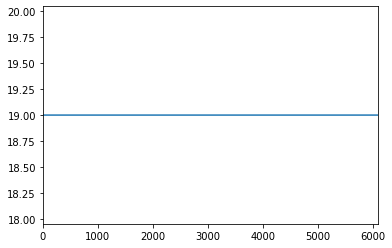

In [52]:
%matplotlib inline
df.natom.plot()

In [83]:
h2o = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
""")

In [84]:
h2o.nuclear_repulsion_energy()

9.168193296424349

In [89]:
print(df.iloc[0].xyz.decode("utf-8") )

19
gdb 1	3.1580357	1.2436329	1.1060216	1.1312	77.92	-0.21236	0.02396	0.23632	1176.6995	0.155411	-422.593067	-422.583794	-422.58285	-422.62703	34.695	
C	-1.8396130083	 0.5292955664	 3.1820679223	-0.414977
C	-2.146536134	-0.1644674918	 1.8425113894	 0.232941
C	-3.586600184	 0.1326587167	 1.3866819689	-0.415379
O	-1.9452668697	-1.5736417154	 1.9580687171	-0.461014
C	-1.1644615826	 0.2689585055	 0.7910045705	 0.388553
C	-0.2471162449	-0.3975622829	 0.0428984233	-0.278918
C	 0.3852095134	 0.5870284364	-0.7883677644	-0.178412
C	-0.1971400753	 1.7724752692	-0.4801599455	-0.025883
O	-1.1464285779	 1.5977410694	 0.4827597736	-0.201531
H	-2.5655496903	 0.2227697011	 3.9444233135	 0.100196
H	-0.8376996067	 0.2552388729	 3.5215923743	 0.128535
H	-1.8910976269	 1.6166367216	 3.0809448095	 0.130435
H	-4.3011711473	-0.171260251	 2.1607772826	 0.100233
H	-3.7248895561	 1.2003322827	 1.1965844054	 0.130552
H	-3.807483374	-0.4187666041	 0.469412708	 0.128541
H	-2.5619847116	-1.8978764082	 2.6220936647	 

In [90]:
xyz = df.iloc[0].xyz.decode("utf-8")

In [65]:
def get_ml_results(features, targets, trainsize,featurenames):
    from sklearn.gaussian_process.kernels import ConstantKernel, RBF
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.kernel_ridge import KernelRidge
    from sklearn.svm import SVR
    import numpy as np
    uniques, indices = np.unique(targets, return_index=True)
    npoint = len(targets)
    nunique=len(uniques)
    print("Number of data points    : {}".format(npoint))
    print("Number of unique points  : {}".format(nunique))
    print("Number of training points: {}".format(int(npoint*trainsize)))
    print("Number of features       : {}".format(len(featurenames)))
    trainX, testX, trainY, testY = train_test_split(features,targets,train_size=trainsize,random_state=7*247)
    run_model(LinearRegression(), trainX, testX, trainY, testY,featurenames)
    run_model(DecisionTreeRegressor(), trainX, testX, trainY, testY,featurenames)
    run_model(RandomForestRegressor(n_estimators=20), trainX, testX, trainY, testY,featurenames)
    run_model(SVR(), trainX, testX, trainY, testY,featurenames)
    run_model(KernelRidge(alpha=0.1), trainX, testX, trainY, testY,featurenames)

def run_model(model, trainX, testX, trainY, testY, featurenames):
    import numpy as np
    import matplotlib.pyplot as plt
    modelname = str(model.__class__).split('.')[-1].split('\'')[0]
    model.fit(trainX, trainY)
    pred = model.predict(testX)
    score = model.score(testX,testY)
    print('***************************************')
    print(f'{modelname:25}')
    if hasattr(model, 'feature_importances_'):
        print(f'features importances')
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        print(f'features coefs')
        importances = abs(model.coef_)
    else:
        importances = 0 
        print(f'features importance not available')
    print(f'features: {featurenames}')
    print('importances:',importances)
    
    meanerror = np.mean(abs((pred - testY)))
    maxerror  = np.max(abs((pred - testY)))

    print(f'R^2 score: {score:.3f}')
    print(f'Mean absolute error: {meanerror:.2f}')
    print(f'Max  absolute error: {maxerror:.2f}')

    plt.figure()
    plt.plot(pred,linestyle='None', marker='o', color='b', markersize=3,markerfacecolor=None, alpha=1)
    plt.plot(testY,linestyle='None', marker='s', color='r', markersize=6, alpha=0.5)
    plt.title(f'{modelname}, MAE={meanerror:.2f}')


(6092, 1) (6092,)
Number of data points    : 6092
Number of unique points  : 4364
Number of training points: 1218
Number of features       : 1
***************************************
LinearRegression         
features coefs
features: ['nre']
importances: [0.08851929]
R^2 score: 0.608
Mean absolute error: 751.68 kcal/mol
Max  absolute error: 4050.52 kcal/mol
***************************************
DecisionTreeRegressor    
features importances
features: ['nre']
importances: [1.]
R^2 score: 0.301
Mean absolute error: 977.77 kcal/mol
Max  absolute error: 5727.91 kcal/mol
***************************************
RandomForestRegressor    
features importances
features: ['nre']
importances: [1.]
R^2 score: 0.477
Mean absolute error: 849.36 kcal/mol
Max  absolute error: 5244.04 kcal/mol


/home/keceli/.conda/envs/jhub_chembox/lib//python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


***************************************
SVR                      
features importance not available
features: ['nre']
importances: 0
R^2 score: 0.558
Mean absolute error: 779.05 kcal/mol
Max  absolute error: 4144.37 kcal/mol
***************************************
KernelRidge              
features importance not available
features: ['nre']
importances: 0
R^2 score: -1.257
Mean absolute error: 1761.70 kcal/mol
Max  absolute error: 6326.67 kcal/mol


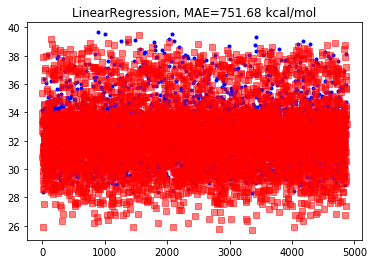

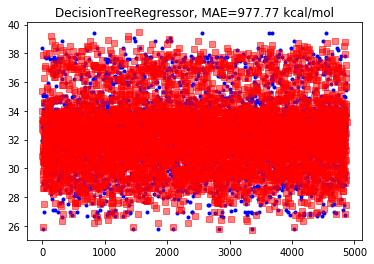

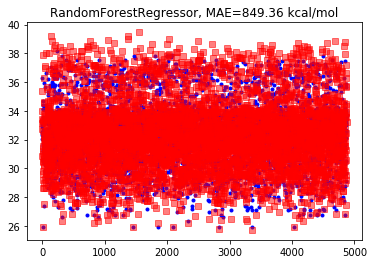

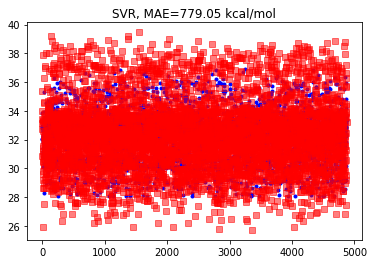

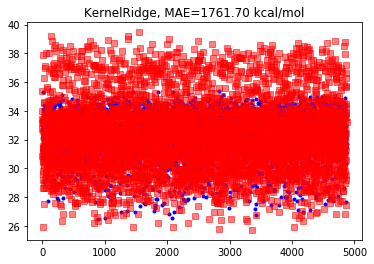

In [103]:
#exclude_columns = [target,'atomic']#,'atomic','ccsd(2)_t','ccsd','scf','nre','one-electron','two-electron']
#featurenames = [col for col in mydf.columns if col not in exclude_columns]
#featurenames = ['scf','nre','one-electron','two-electron']
featurenames = [f'coulomb_{i}' for i in range(1,20)] #,'A','B','C']
featurenames =['nre']
target = 'Cv'
print(df[featurenames].values.shape,df[target].values.shape )
get_ml_results(df[featurenames].values,df[target].values,0.2,featurenames)

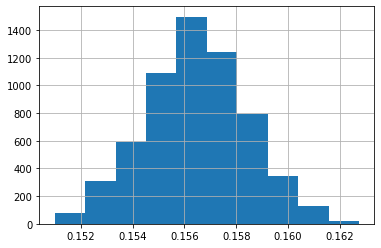

In [81]:
df.zpve.hist()

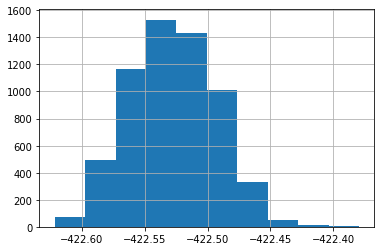

In [84]:
df.H.hist()

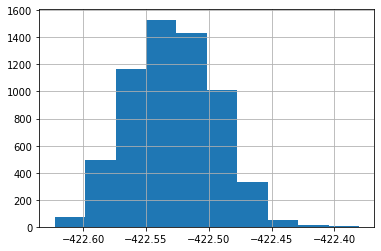

In [86]:
df.U.hist()

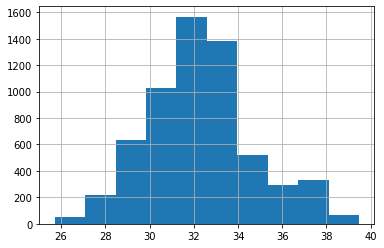

In [87]:
df.Cv.hist()

(50, 1) (50, 1)
Number of data points    : 50
Number of unique points  : 50
Number of training points: 10
Number of features       : 0
***************************************
LinearRegression         
features coefs
features: 
importances: [[1.]]
R^2 score: 1.000
Mean absolute error: 0.00 kcal/mol
Max  absolute error: 0.00 kcal/mol
***************************************
DecisionTreeRegressor    
features importances
features: 
importances: [1.]
R^2 score: 0.964
Mean absolute error: 2096.67 kcal/mol
Max  absolute error: 6149.59 kcal/mol
***************************************
RandomForestRegressor    
features importances
features: 
importances: [1.]
R^2 score: 0.982
Mean absolute error: 2040.28 kcal/mol
Max  absolute error: 5773.09 kcal/mol
***************************************
SVR                      
features importance not available
features: 
importances: 0
R^2 score: 0.553
Mean absolute error: 1642.27 kcal/mol
Max  absolute error: 4478.21 kcal/mol
*****************************

/home/keceli/.conda/envs/jhub_chembox/lib/python3.6/site-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/keceli/.conda/envs/jhub_chembox/lib//python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/keceli/.conda/envs/jhub_chembox/lib//python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


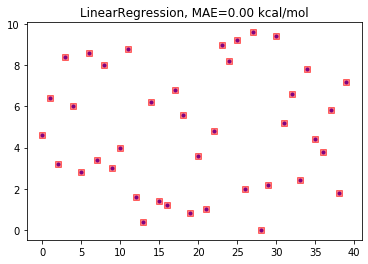

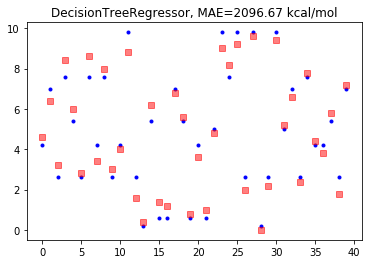

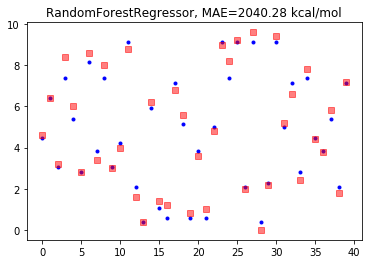

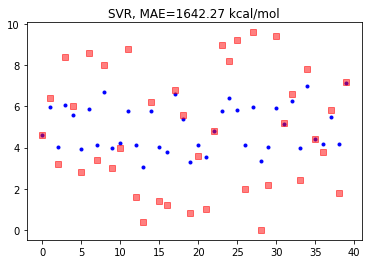

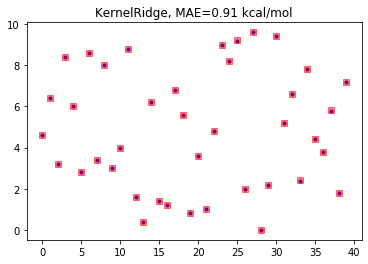

In [105]:
import numpy as np
x = np.arange(0,10,0.2).reshape(-1, 1)
x2 = np.square(np.sqrt(x))
print(x.shape,x2.shape)
get_ml_results(x,x2,trainsize=0.2,featurenames='')

In [ ]:
# %load '/home/keceli/Datascience/keceli/chem_datasets/QM7/nn-qm7/nn.py'
import numpy

class Module:
	def update(self,lr): pass
	def average(self,nn,a): pass
	def backward(self,DY): pass
	def forward(self,X): pass

class Sequential(Module):

	def __init__(self,modules):
		self.modules = modules
	
	def forward(self,X):
		for m in self.modules: X = m.forward(X)
		return X
	
	def backward(self,DY):
		for m in self.modules[::-1]: DY = m.backward(DY)
		return DY
		
	def update(self,lr):
		for m in self.modules: X = m.update(lr)
		
	def average(self,nn,a):
		for m,n in zip(self.modules,nn.modules): m.average(n,a)

class Input(Module):

	def __init__(self,X):
		self.step  = 1.0
		self.noise = 1.0
		self.triuind = (numpy.arange(23)[:,numpy.newaxis] <= numpy.arange(23)[numpy.newaxis,:]).flatten()
		self.max = 0
		for _ in range(10): self.max = numpy.maximum(self.max,self.realize(X).max(axis=0))
		X = self.expand(self.realize(X))
		self.nbout = X.shape[1]
		self.mean = X.mean(axis=0)
		self.std = (X - self.mean).std()
	
	def realize(self,X):
		def _realize_(x):
			inds = numpy.argsort(-(x**2).sum(axis=0)**.5+numpy.random.normal(0,self.noise,x[0].shape))
			x = x[inds,:][:,inds]*1
			x = x.flatten()[self.triuind]
			return x
		return numpy.array([_realize_(z) for z in X])

	def expand(self,X):
		Xexp = []
		for i in range(X.shape[1]):
			for k in numpy.arange(0,self.max[i]+self.step,self.step):
				Xexp += [numpy.tanh((X[:,i]-k)/self.step)]
		return numpy.array(Xexp).T
	
	def normalize(self,X): return (X-self.mean)/self.std
	
	def forward(self,X): return self.normalize(self.expand(self.realize(X))).astype('float32')

class Output(Module):

	def __init__(self,T):
		self.tmean = T.mean()
		self.tstd  = T.std()
		self.nbinp = 1

	def forward(self,X):
		self.X = X.flatten()
		return self.X*self.tstd+self.tmean

	def backward(self,DY):
		return (DY/self.tstd).astype('float32')[:,numpy.newaxis]

class Linear(Module):

	def __init__(self,m,n):

		self.tr = m**.5 / n**.5
		self.lr = 1 / m**.5
		
		self.W = numpy.random.normal(0,1 / m**.5,[m,n]).astype('float32')
		self.A = numpy.zeros([m]).astype('float32')
		self.B = numpy.zeros([n]).astype('float32')

	def forward(self,X):
		self.X = X
		Y = numpy.dot(X-self.A,self.W)+self.B
		return Y

	def backward(self,DY):
		self.DW = numpy.dot((self.X-self.A).T,DY)
		self.DA = -(self.X-self.A).sum(axis=0)
		self.DB = DY.sum(axis=0) + numpy.dot(self.DA,self.W)
		DX = self.tr * numpy.dot(DY,self.W.T)
		return DX

	def update(self,lr):
		self.W -= lr*self.lr*self.DW
		self.B -= lr*self.lr*self.DB
		self.A -= lr*self.lr*self.DA

	def average(self,nn,a):
		self.W = a*nn.W + (1-a)*self.W
		self.B = a*nn.B + (1-a)*self.B
		self.A = a*nn.A + (1-a)*self.A


class Sigmoid(Module):
	
	def forward(self,X):
		self.Y = numpy.tanh(X/1.5)
		return 1.5*self.Y
		
	def backward(self,DY):
		return DY * (1-self.Y**2)



In [ ]:
# %load '/home/keceli/Datascience/keceli/chem_datasets/QM7/nn-qm7/nntrain.py'
import os,pickle,sys,numpy,nn,copy,scipy,scipy.io

# --------------------------------------------
# Parameters
# --------------------------------------------
seed  = 3453
split = int(sys.argv[1]) # test split

mb    = 25     # size of the minibatch
hist  = 0.1    # fraction of the history to be remembered

# --------------------------------------------
# Load data
# --------------------------------------------
numpy.random.seed(seed)
if not os.path.exists('qm7.mat'): os.system('wget http://www.quantum-machine.org/data/qm7.mat')
dataset = scipy.io.loadmat('qm7.mat')

# --------------------------------------------
# Extract training data
# --------------------------------------------
P = dataset['P'][range(0,split)+range(split+1,5)].flatten()
X = dataset['X'][P]
T = dataset['T'][0,P]

# --------------------------------------------
# Create a neural network
# --------------------------------------------
I,O = nn.Input(X),nn.Output(T)
nnsgd = nn.Sequential([I,nn.Linear(I.nbout,400),nn.Sigmoid(),nn.Linear(400,100),nn.Sigmoid(),nn.Linear(100,O.nbinp),O])
nnsgd.modules[-2].W *= 0
nnavg = copy.deepcopy(nnsgd)

# --------------------------------------------
# Train the neural network
# --------------------------------------------
for i in range(1,1000001):

	if i > 0:     lr = 0.001  # learning rate
	if i > 500:   lr = 0.0025
	if i > 2500:  lr = 0.005
	if i > 12500: lr = 0.01

	r = numpy.random.randint(0,len(X),[mb])
	Y = nnsgd.forward(X[r])
	nnsgd.backward(Y-T[r])
	nnsgd.update(lr)
	nnavg.average(nnsgd,(1/hist)/((1/hist)+i))
	nnavg.nbiter = i

	if i % 100 == 0: pickle.dump(nnavg,open('nn-%d.pkl'%split,'w'),pickle.HIGHEST_PROTOCOL)



In [67]:
import scipy.io
import pandas as pd
dataset = scipy.io.loadmat('/home/keceli/Datascience/keceli/chem_datasets/QM7/qm7.mat')
"""
X (7165 x 23 x 23): Coulomb matrices
T (7165):  labels (atomization energies) 
P (5 x 1433): splits for cross-validation
Z (7165):   atomic charge 
R (7165 x 3): cartesian coordinate of each atom in the molecules.
"""
df = pd.DataFrame() #.from_dict(dataset)
df['X'] = pd.Series(list(dataset['X']))
df['T'] =  pd.Series(list(dataset['T'].transpose()))
df['Z'] = pd.Series(list(dataset['Z']))
df['R'] = pd.Series(list(dataset['R']))
N=7165
natoms=np.zeros(N)
nres=np.zeros(N)
angs2bohr=1.8897161646321
for i in range(N):
    natom = np.count_nonzero(df['Z'][i])
    positions = df['R'][i][:natom] * angs2bohr
    charges = df['Z'][i][:natom]
    nres[i] = get_nre(charges,positions)
df['NRE'] = pd.Series(nres)  

In [68]:
h2k=627.509608

df['AE']=np.array(*dataset['T']).transpose()
#df['NRE'] *= h2k

Number of data points    : 7165
Number of unique points  : 6789
Number of training points: 5015
Number of features       : 1
***************************************
LinearRegression         
features coefs
features: ['NRE']
importances: [0.00762465]
R^2 score: 0.283
Mean absolute error: 150.18
Max  absolute error: 752.80
***************************************
DecisionTreeRegressor    
features importances
features: ['NRE']
importances: [1.]
R^2 score: -0.077
Mean absolute error: 181.30
Max  absolute error: 1173.09
***************************************
RandomForestRegressor    
features importances
features: ['NRE']
importances: [1.]
R^2 score: 0.187
Mean absolute error: 157.29
Max  absolute error: 880.90


/home/keceli/.conda/envs/jhub_chembox/lib//python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


***************************************
SVR                      
features importance not available
features: ['NRE']
importances: 0
R^2 score: 0.000
Mean absolute error: 179.64
Max  absolute error: 1124.37
***************************************
KernelRidge              
features importance not available
features: ['NRE']
importances: 0
R^2 score: -0.008
Mean absolute error: 169.77
Max  absolute error: 1097.43


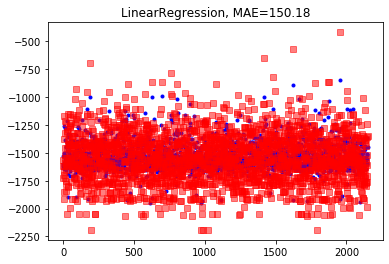

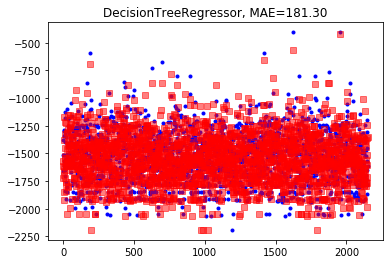

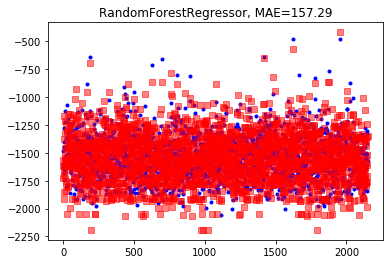

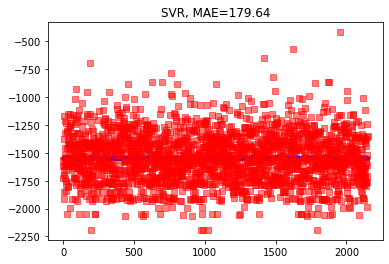

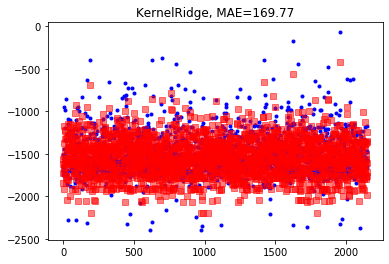

In [74]:
#df['NRE'] *= h2k
get_ml_results(df['NRE'].values.reshape(-1, 1),df['AE'].values,0.7,['NRE'])

In [ ]:
# SGDML http://quantum-machine.org/gdml/doc/
npzdata = np.load('/home/keceli/Datascience/keceli/chem_datasets/GDML/ethanol_ccsd_t-train.npz')
for key in npzdata.keys():
    try:
        print(f'{key}:{len(npzdata[key])}')
    except:
        print(key)
charges=npzdata['z']
nsample = len(npzdata['E'])
nre = np.zeros(nsample)
angs2bohr = 1.8897161646321
hartree2kcal = 627.509608
for i in range(nsample):
    nre[i] = hartree2kcal * get_nre(charges,angs2bohr*npzdata['R'][i])

In [93]:
# SGDML http://quantum-machine.org/gdml/doc/
npzdata = np.load('/home/keceli/Datascience/keceli/chem_datasets/GDML/benzene_ccsd_t-test.npz')
for key in npzdata.keys():
    try:
        print(f'{key}:{len(npzdata[key])}')
    except:
        print(key)
charges=npzdata['z']
nsample = len(npzdata['E'])
nre = np.zeros(nsample)
angs2bohr = 1.8897161646321
hartree2kcal = 627.509608
for i in range(nsample):
    nre[i] = hartree2kcal * get_nre(charges,angs2bohr*npzdata['R'][i])

E:500
name
F:500
theory
R:500
z:12
type
md5


Number of data points    : 500
Number of unique points  : 500
Number of training points: 250
Number of features       : 1
***************************************
LinearRegression         
features coefs
features: ['nre']
importances: [[0.00064731]]
R^2 score: 0.034
Mean absolute error: 1.92
Max  absolute error: 7.54
***************************************
DecisionTreeRegressor    
features importances
features: ['nre']
importances: [1.]
R^2 score: -0.681
Mean absolute error: 2.65
Max  absolute error: 13.08
***************************************
RandomForestRegressor    
features importances
features: ['nre']
importances: [1.]
R^2 score: -0.227
Mean absolute error: 2.32
Max  absolute error: 11.00
***************************************
SVR                      
features importance not available
features: ['nre']
importances: 0
R^2 score: -0.002
Mean absolute error: 1.97
Max  absolute error: 9.34
***************************************
KernelRidge              
features importance not a

/home/keceli/.conda/envs/jhub_chembox/lib/python3.6/site-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/keceli/.conda/envs/jhub_chembox/lib//python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/keceli/.conda/envs/jhub_chembox/lib//python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


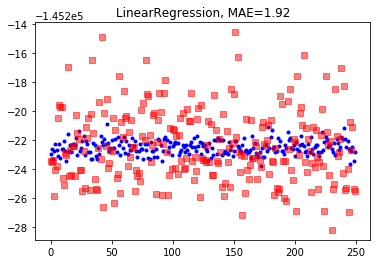

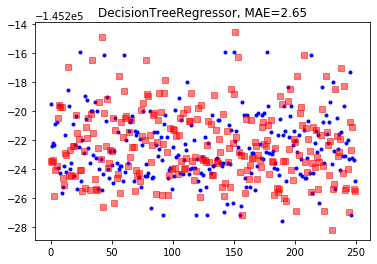

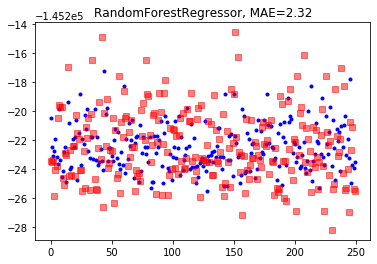

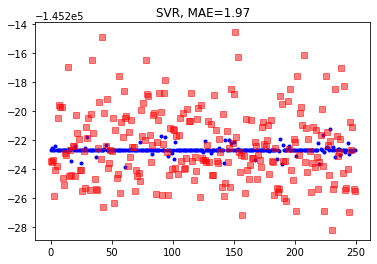

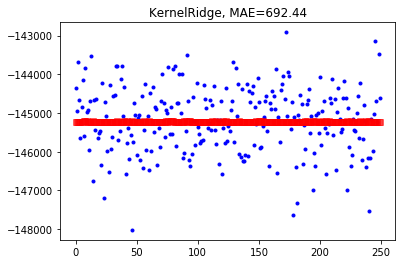

In [94]:
get_ml_results(nre.reshape(-1, 1),npzdata['E'],0.5,featurenames=['nre'])    

In [86]:
print(len(benzene['E']))

1000


(array([   3.,   12.,   83.,  396., 1248., 1986., 1870., 1131.,  388.,
          48.]),
 array([ 4. ,  5.9,  7.8,  9.7, 11.6, 13.5, 15.4, 17.3, 19.2, 21.1, 23. ]),
 <a list of 10 Patch objects>)

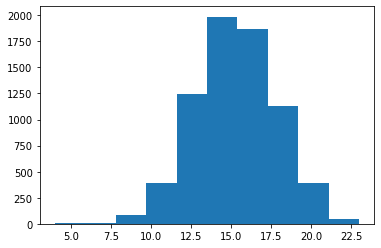

In [32]:
N=7165
natoms=np.zeros(N)
for i in range(N):
    natoms[i] = np.count_nonzero(df['Z'][i])
    
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(natoms)

In [31]:
get_nre(df['Z'][0][:3],df['R'][0][:3])

6.111964643001556

In [33]:
dataset['Z'].transpose().shape

(23, 7165)

In [19]:
dataset['X'].reshape()

array([[[36.858105 ,  2.9076326,  2.907612 , ...,  0.       ,
          0.       ,  0.       ],
        [ 2.9076326,  0.5      ,  0.29672  , ...,  0.       ,
          0.       ,  0.       ],
        [ 2.907612 ,  0.29672  ,  0.5      , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[36.858105 , 12.599944 ,  2.9019997, ...,  0.       ,
          0.       ,  0.       ],
        [12.599944 , 36.858105 ,  1.4731166, ...,  0.       ,
          0.       ,  0.       ],
        [ 2.9019997,  1.4731166,  0.5      , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.

In [35]:
import ase

In [45]:
mols = ase.Atoms(symbols=df.iloc[0]['Z'][:5],positions=df.iloc[0]['R'][:5],pbc=False)

In [50]:
charges

array([6., 1., 1., 1., 1.], dtype=float32)

In [11]:
charges = df.iloc[0]['Z'][:5]
positions=df.iloc[0]['R'][:5]
positions

array([[ 1.886438  , -0.00464873, -0.00823921],
       [ 3.9499245 , -0.00459203,  0.00782347],
       [ 1.1976895 ,  1.9404842 ,  0.00782347],
       [ 1.1849339 , -0.99726516,  1.6593875 ],
       [ 1.2119948 , -0.9589793 , -1.710958  ]], dtype=float32)

In [20]:

def get_nre(charges,positions,convert2bohr=False):
    import numpy as np
    nre = 0
    if convert2bohr:
        positions = positions * 1.8897161646321
    for i, zi in enumerate(charges):
        for j, zj in enumerate(charges):
            if i == j:
                continue
            R = np.linalg.norm(positions[i] - positions[j])
            nre += zi*zj/R
    return nre*0.5
#%timeit get_nre([1,1],np.array([[0.,0.,0.],[1.,0.,0.]]),convert2bohr=True)
def get_nre(charges,positions):
    """
    Return the nuclear repulsion energy for a given array of nuclear charges (1xN) and positions (Nx3).
    """
    import numpy as np
    nre = 0.
    ncharge = len(charges)
    for i in range(ncharge):
        for j in range(i):
            r = np.linalg.norm(positions[i] - positions[j])
            nre += charges[i]*charges[j]/r
    return nre
%timeit get_nre([1,1],np.array([[0.,0.,0.],[1.,0.,0.]]))

15.2 µs ± 755 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
get_nre([1,1],np.array([[0.,0.,0.],[1.,0.,0.]]),convert2bohr=True)

0.5291799999999922

In [9]:
import psi4

In [ ]:
mol = psi4.geometry()